# RM-19: AI-Powered Triage System for Rural Malaysian Healthcare
## Comprehensive Analysis Notebook

This notebook performs:
1. **Task 1**: Data Loading & Preprocessing
2. **EDA Analysis**: Exploratory Data Analysis with visualizations
3. **Feature Engineering**: Creating optimized features for ML classification

---

## 1. Setup & Imports

In [1]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

warnings.filterwarnings('ignore')

# Set publication-quality style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette
COLORS = {
    'COVID': '#e74c3c',   # Red
    'Flu': '#f39c12',     # Orange
    'Cold': '#3498db',    # Blue
}

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


---
# TASK 1: DATA LOADING & PREPROCESSING
---

## 1.1 Load the RM-19 Dataset

In [2]:
# Define data directory
data_dir = "data"

# Load the full dataset
df = pd.read_csv(os.path.join(data_dir, "rm19_dataset_full.csv"))

print(f"📊 Dataset loaded successfully!")
print(f"   Shape: {df.shape[0]:,} samples × {df.shape[1]} features")

📊 Dataset loaded successfully!
   Shape: 50,000 samples × 28 features


## 1.2 View Top 5 Rows

In [3]:
# Display top 5 rows
print("📋 First 5 rows of the dataset:")
df.head()

📋 First 5 rows of the dataset:


disease  age  gender         state  symptom_fever  symptom_dry_cough  \
0   COVID   42    Male       Sarawak              2                  2   
1    Cold   52  Female  Pulau Pinang              1                  0   
2     Flu   54  Female        Pahang              2                  1   
3    Cold   67    Male      Selangor              0                  0   
4   COVID   41  Female   W.P. Labuan              0                  3   

   symptom_sore_throat  symptom_fatigue  symptom_anosmia  \
0                    1                2                3   
1                    0                0                0   
2                    0                0                0   
3                    2                0                0   
4                    1                2                3   

   symptom_breathlessness  ...  blood_nlr  risk_diabetes  risk_hypertension  \
0                       1  ...       9.83              0                  1   
1                       0  ...       1.02              0                  1   
2                       1  ...       1.99              0                  0   
3                       0  ...       1.39              1                  0   
4                       2  ...      16.12              1                  0   

   risk_elderly  risk_lung_disease  access_distance_clinic  \
0             0                  0                     4.5   
1             0                  0                     2.0   
2             0                  1                     3.5   
3             1                  0                     1.0   
4             0                  0                     2.5   

   access_distance_hospital  access_nearest_hospital_scale  \
0                       4.5                              1   
1                       1.0                              3   
2                       4.5                              2   
3                       1.5                              4   
4                       1.0                              4   

   access_population_density  access_admission_delay  
0                          1                   14.25  
1                          5                    0.41  
2                          1                    5.62  
3                          5                    0.38  
4                          5                    0.47  

[5 rows x 28 columns]

## 1.3 Dataset Info & Summary Statistics

In [4]:
# Dataset info
print("📌 Dataset Information:")
print("="*60)
df.info()

📌 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   disease                        50000 non-null  object 
 1   age                            50000 non-null  int64  
 2   gender                         50000 non-null  object 
 3   state                          50000 non-null  object 
 4   symptom_fever                  50000 non-null  int64  
 5   symptom_dry_cough              50000 non-null  int64  
 6   symptom_sore_throat            50000 non-null  int64  
 7   symptom_fatigue                50000 non-null  int64  
 8   symptom_anosmia                50000 non-null  int64  
 9   symptom_breathlessness         50000 non-null  int64  
 10  symptom_headache               50000 non-null  int64  
 11  symptom_runny_nose             50000 non-null  int64  
 12  blood_wbc              

In [5]:
# Summary statistics
print("\n📊 Summary Statistics:")
df.describe()


📊 Summary Statistics:


age  symptom_fever  symptom_dry_cough  symptom_sore_throat  \
count  50000.000000   50000.000000       50000.000000         50000.000000   
mean      44.716980       0.906760           0.638640             0.890600   
std       14.441873       0.922867           0.764481             0.806204   
min       18.000000       0.000000           0.000000             0.000000   
25%       34.000000       0.000000           0.000000             0.000000   
50%       45.000000       1.000000           0.000000             1.000000   
75%       55.000000       2.000000           1.000000             1.000000   
max       85.000000       3.000000           3.000000             3.000000   

       symptom_fatigue  symptom_anosmia  symptom_breathlessness  \
count     50000.000000     50000.000000            50000.000000   
mean          0.928360         0.490580                0.252460   
std           0.868172         0.973329                0.571498   
min           0.000000         0.000000                0.000000   
25%           0.000000         0.000000                0.000000   
50%           1.000000         0.000000                0.000000   
75%           2.000000         0.000000                0.000000   
max           3.000000         3.000000                3.000000   

       symptom_headache  symptom_runny_nose     blood_wbc  ...     blood_nlr  \
count      50000.000000        50000.000000  50000.000000  ...  50000.000000   
mean           0.668200            1.138140      7.998251  ...      5.746073   
std            0.739621            1.012046      2.233477  ...      7.315845   
min            0.000000            0.000000      3.000000  ...      0.570000   
25%            0.000000            0.000000      6.420000  ...      1.570000   
50%            1.000000            1.000000      7.870000  ...      2.460000   
75%            1.000000            2.000000      9.470000  ...      4.680000   
max            3.000000            3.000000     15.000000  ...     50.080000   

       risk_diabetes  risk_hypertension  risk_elderly  risk_lung_disease  \
count    50000.00000       50000.000000   50000.00000       50000.000000   
mean         0.19276           0.257340       0.14376           0.100380   
std          0.39447           0.437173       0.35085           0.300509   
min          0.00000           0.000000       0.00000           0.000000   
25%          0.00000           0.000000       0.00000           0.000000   
50%          0.00000           0.000000       0.00000           0.000000   
75%          0.00000           1.000000       0.00000           0.000000   
max          1.00000           1.000000       1.00000           1.000000   

       access_distance_clinic  access_distance_hospital  \
count             50000.00000              50000.000000   
mean                  2.16779                  2.127440   
std                   1.37530                  1.370685   
min                   0.00000                  0.000000   
25%                   1.00000                  1.000000   
50%                   2.00000                  2.000000   
75%                   3.50000                  3.000000   
max                   5.00000                  5.000000   

       access_nearest_hospital_scale  access_population_density  \
count                   50000.000000               50000.000000   
mean                        2.727640                   3.483000   
std                         1.119574                   1.792834   
min                         1.000000                   1.000000   
25%                         2.000000                   2.000000   
50%                         3.000000                   3.000000   
75%                         4.000000                   5.000000   
max                         4.000000                   6.000000   

       access_admission_delay  
count            50000.000000  
mean                 2.065842  
std                  2.628037  
min                  0.000000  
25%    

In [6]:
# Check for missing values
print("\n🔍 Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   ✅ No missing values found!")
else:
    print(missing[missing > 0])


🔍 Missing Values:
   ✅ No missing values found!


In [7]:
# Column groupings
print("\n📂 Feature Categories:")
print("-"*40)

symptom_cols = [c for c in df.columns if c.startswith('symptom_')]
blood_cols = [c for c in df.columns if c.startswith('blood_')]
risk_cols = [c for c in df.columns if c.startswith('risk_')]
access_cols = [c for c in df.columns if c.startswith('access_')]

print(f"   Demographics: age, gender, state")
print(f"   Symptoms ({len(symptom_cols)}): {symptom_cols}")
print(f"   Blood Tests ({len(blood_cols)}): {blood_cols}")
print(f"   Risk Factors ({len(risk_cols)}): {risk_cols}")
print(f"   Accessibility ({len(access_cols)}): {access_cols}")
print(f"   Target: disease")


📂 Feature Categories:
----------------------------------------
   Demographics: age, gender, state
   Symptoms (8): ['symptom_fever', 'symptom_dry_cough', 'symptom_sore_throat', 'symptom_fatigue', 'symptom_anosmia', 'symptom_breathlessness', 'symptom_headache', 'symptom_runny_nose']
   Blood Tests (7): ['blood_wbc', 'blood_neutrophils', 'blood_lymphocytes', 'blood_platelets', 'blood_crp', 'blood_alt', 'blood_nlr']
   Risk Factors (4): ['risk_diabetes', 'risk_hypertension', 'risk_elderly', 'risk_lung_disease']
   Accessibility (5): ['access_distance_clinic', 'access_distance_hospital', 'access_nearest_hospital_scale', 'access_population_density', 'access_admission_delay']
   Target: disease


---
# TASK 2: EXPLORATORY DATA ANALYSIS (EDA)
---

## 2.1 Target Variable Distribution (Figure 4.0)

In [8]:
# Calculate distribution
n = len(df)
disease_counts = df['disease'].value_counts()

print("📊 Target Variable Distribution")
print("="*60)
print(f"\nDataset (N={n:,}):")
for disease in ['Cold', 'Flu', 'COVID']:
    count = disease_counts.get(disease, 0)
    pct = count / n * 100
    print(f"  {disease}: {count:,} ({pct:.1f}%)")

📊 Target Variable Distribution

Dataset (N=50,000):
  Cold: 22,174 (44.3%)
  Flu: 17,474 (34.9%)
  COVID: 10,352 (20.7%)


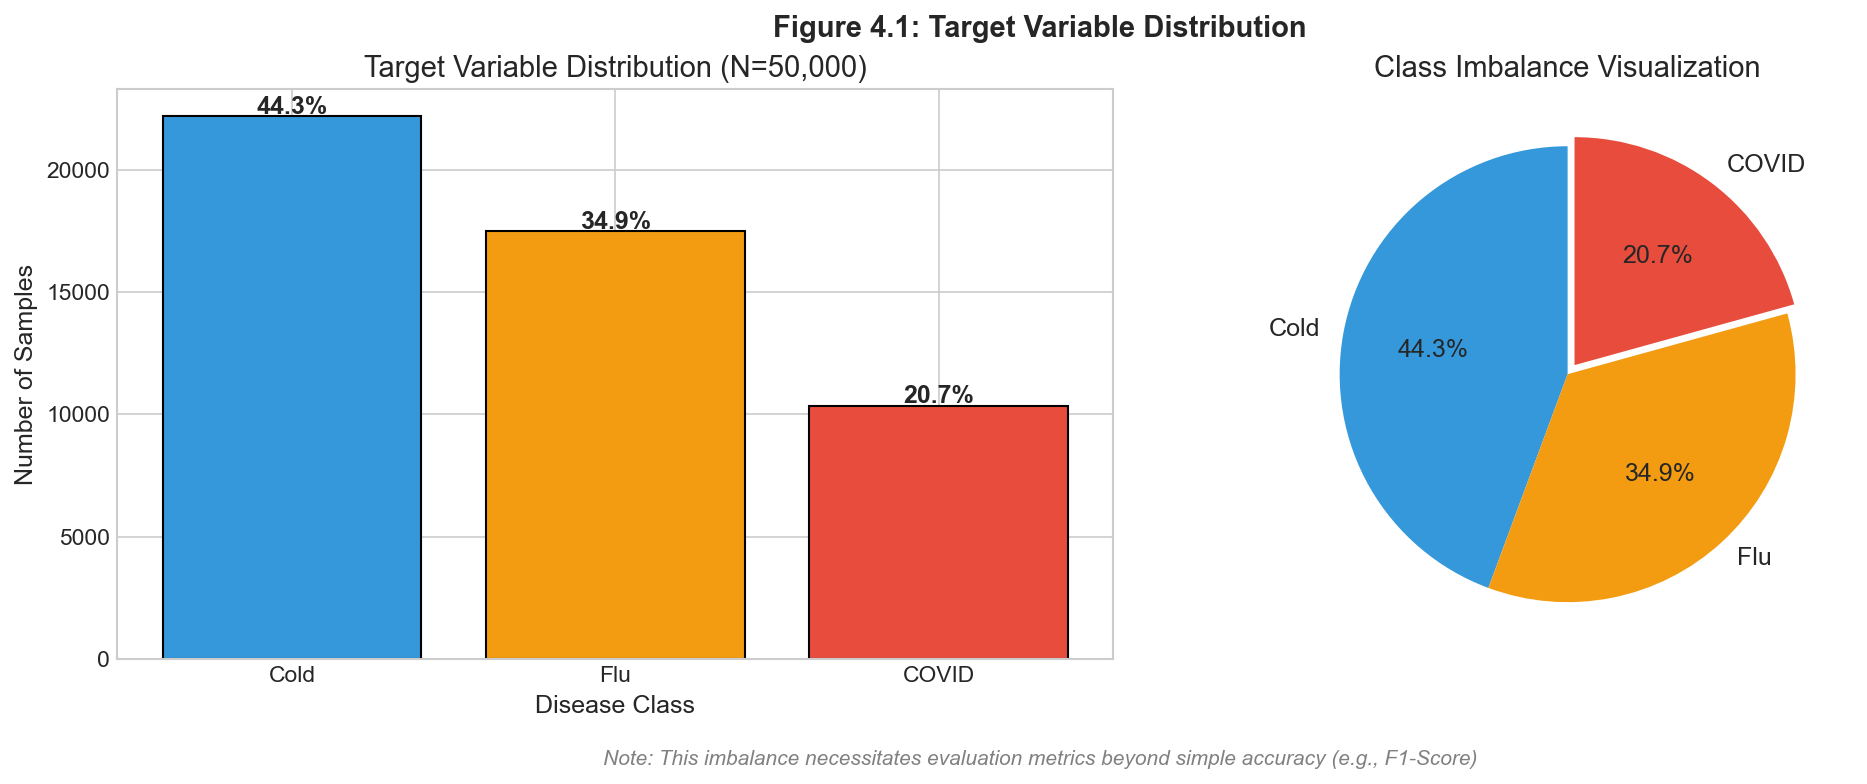

✅ Figure 4.1 generated


In [9]:
# Create Figure 4.1: Target Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
ax1 = axes[0]
diseases = ['Cold', 'Flu', 'COVID']
counts = [disease_counts.get(d, 0) for d in diseases]
colors = [COLORS[d] for d in diseases]

bars = ax1.bar(diseases, counts, color=colors, edgecolor='black', linewidth=1)
ax1.set_xlabel('Disease Class')
ax1.set_ylabel('Number of Samples')
ax1.set_title(f'Target Variable Distribution (N={n:,})')

# Add percentage labels
for bar, count in zip(bars, counts):
    pct = count / n * 100
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
            f'{pct:.1f}%', ha='center', fontsize=12, fontweight='bold')

# Pie chart
ax2 = axes[1]
explode = (0, 0, 0.05)  # Explode COVID slice
ax2.pie(counts, labels=diseases, colors=colors, autopct='%1.1f%%',
        explode=explode, startangle=90, textprops={'fontsize': 12})
ax2.set_title('Class Imbalance Visualization')

# Add annotation
fig.text(0.5, 0.02, 
         'Note: This imbalance necessitates evaluation metrics beyond simple accuracy (e.g., F1-Score)',
         ha='center', fontsize=10, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.suptitle('Figure 4.1: Target Variable Distribution', fontsize=14, fontweight='bold', y=1.02)
plt.show()
print("✅ Figure 4.1 generated")

## 2.2 Clinical Biomarker Analysis

In [10]:
# Print NLR statistics
print(" Neutrophil-to-Lymphocyte Ratio (NLR) Analysis")
print("="*60)
for disease in ['COVID', 'Flu', 'Cold']:
    data = df[df['disease'] == disease]
    nlr = data['blood_nlr']
    neut = data['blood_neutrophils']
    lymph = data['blood_lymphocytes']
    print(f"\n  {disease}:")
    print(f"    NLR: median={nlr.median():.1f}, mean={nlr.mean():.1f} ± {nlr.std():.1f}")
    print(f"    Neutrophils: median={neut.median():.2f} ×10⁹/L")
    print(f"    Lymphocytes: median={lymph.median():.2f} ×10⁹/L")

 Neutrophil-to-Lymphocyte Ratio (NLR) Analysis

  COVID:
    NLR: median=17.3, mean=18.7 ± 6.3
    Neutrophils: median=9.50 ×10⁹/L
    Lymphocytes: median=0.55 ×10⁹/L

  Flu:
    NLR: median=3.1, mean=3.3 ± 1.1
    Neutrophils: median=5.01 ×10⁹/L
    Lymphocytes: median=1.59 ×10⁹/L

  Cold:
    NLR: median=1.5, mean=1.6 ± 0.5
    Neutrophils: median=3.50 ×10⁹/L
    Lymphocytes: median=2.30 ×10⁹/L


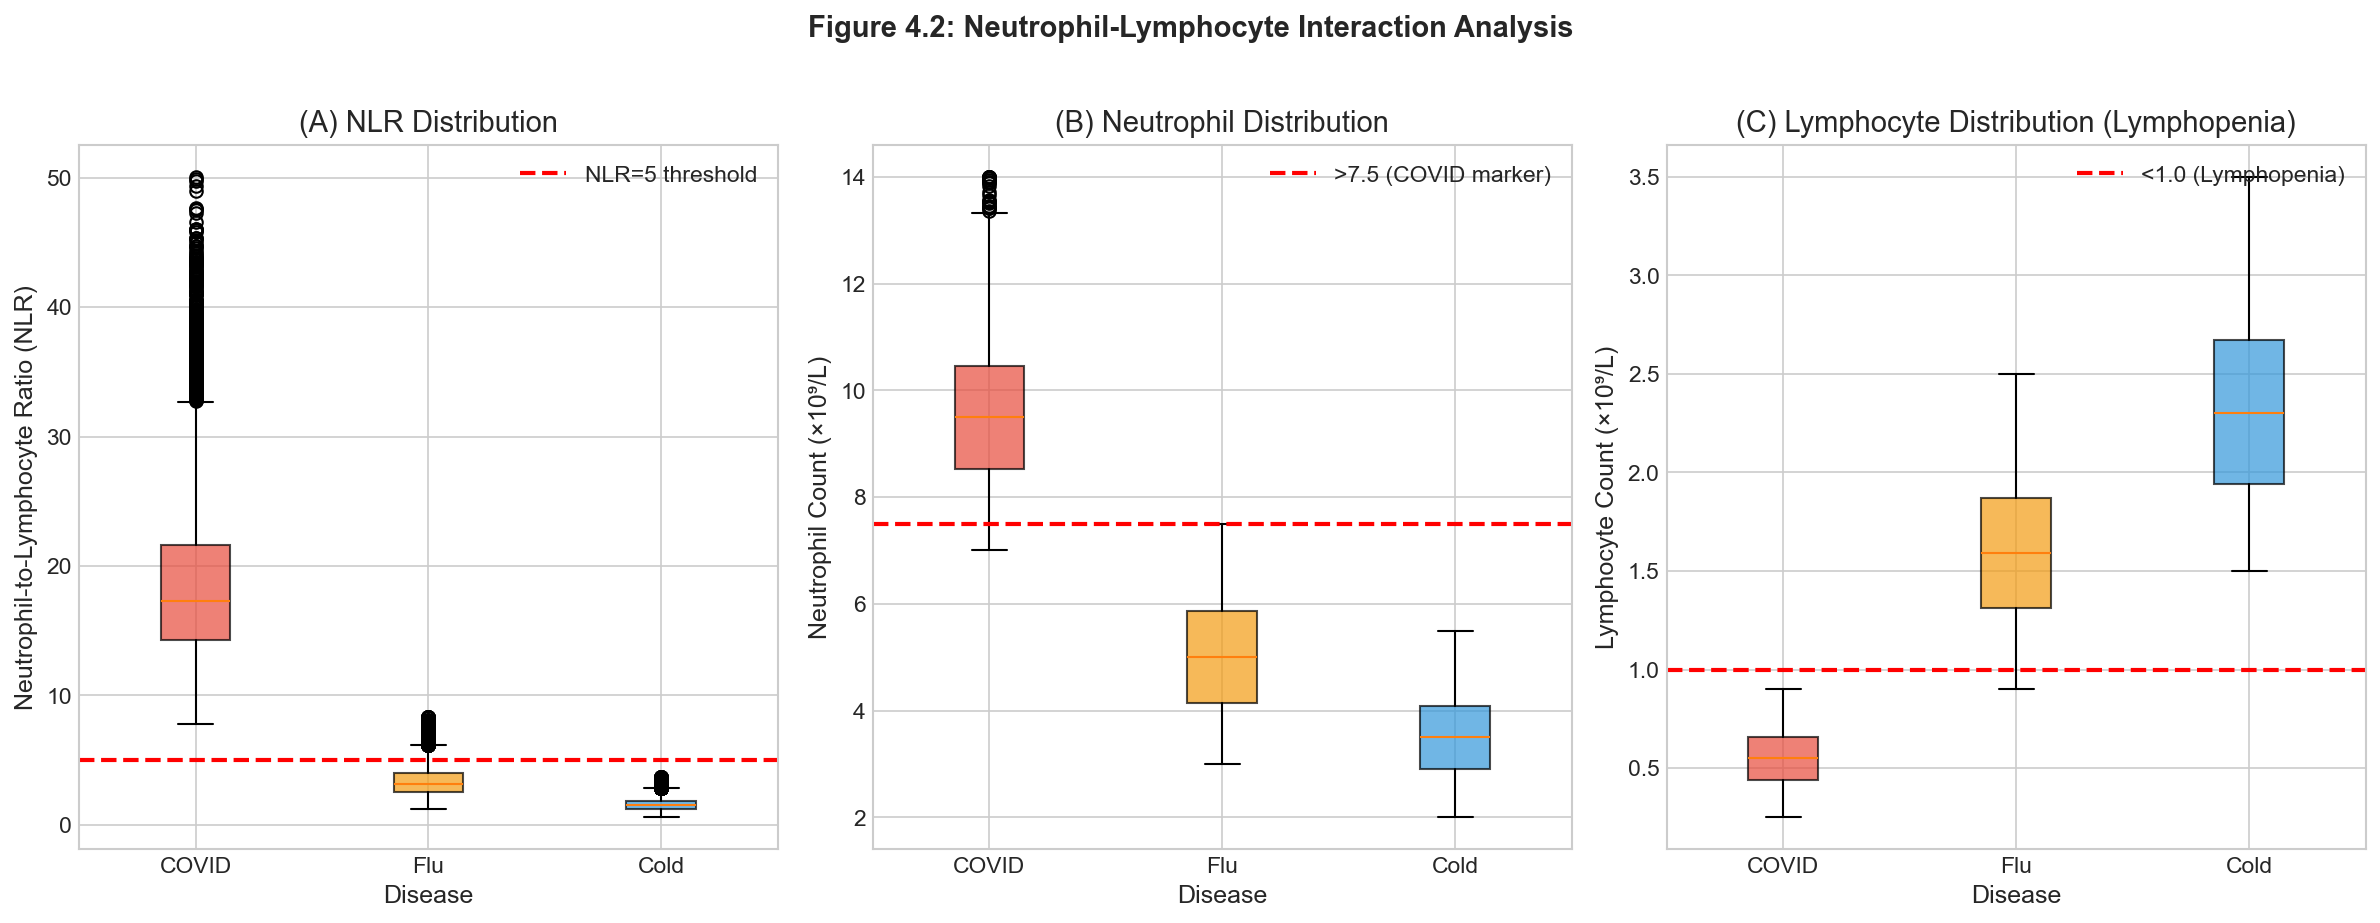

✅ Figure 4.2 generated


In [11]:
# Create Figure 4.2: NLR Boxplots
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

disease_order = ['COVID', 'Flu', 'Cold']

# Panel A: NLR Distribution
ax1 = axes[0]
data_nlr = [df[df['disease'] == d]['blood_nlr'] for d in disease_order]
bp1 = ax1.boxplot(data_nlr, labels=disease_order, patch_artist=True)
for patch, color in zip(bp1['boxes'], [COLORS[d] for d in disease_order]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax1.axhline(y=5, color='red', linestyle='--', linewidth=2, label='NLR=5 threshold')
ax1.set_xlabel('Disease')
ax1.set_ylabel('Neutrophil-to-Lymphocyte Ratio (NLR)')
ax1.set_title('(A) NLR Distribution')
ax1.legend(loc='upper right')

# Panel B: Neutrophils
ax2 = axes[1]
data_neut = [df[df['disease'] == d]['blood_neutrophils'] for d in disease_order]
bp2 = ax2.boxplot(data_neut, labels=disease_order, patch_artist=True)
for patch, color in zip(bp2['boxes'], [COLORS[d] for d in disease_order]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax2.axhline(y=7.5, color='red', linestyle='--', linewidth=2, label='>7.5 (COVID marker)')
ax2.set_xlabel('Disease')
ax2.set_ylabel('Neutrophil Count (×10⁹/L)')
ax2.set_title('(B) Neutrophil Distribution')
ax2.legend(loc='upper right')

# Panel C: Lymphocytes
ax3 = axes[2]
data_lymph = [df[df['disease'] == d]['blood_lymphocytes'] for d in disease_order]
bp3 = ax3.boxplot(data_lymph, labels=disease_order, patch_artist=True)
for patch, color in zip(bp3['boxes'], [COLORS[d] for d in disease_order]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='<1.0 (Lymphopenia)')
ax3.set_xlabel('Disease')
ax3.set_ylabel('Lymphocyte Count (×10⁹/L)')
ax3.set_title('(C) Lymphocyte Distribution (Lymphopenia)')
ax3.legend(loc='upper right')

plt.suptitle('Figure 4.2: Neutrophil-Lymphocyte Interaction Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
print("✅ Figure 4.2 generated")

In [12]:
# Statistical significance test
print("\n📊 Statistical Tests (Mann-Whitney U):")
covid_nlr = df[df['disease'] == 'COVID']['blood_nlr']
flu_nlr = df[df['disease'] == 'Flu']['blood_nlr']
cold_nlr = df[df['disease'] == 'Cold']['blood_nlr']

stat1, p1 = stats.mannwhitneyu(covid_nlr, flu_nlr, alternative='greater')
stat2, p2 = stats.mannwhitneyu(covid_nlr, cold_nlr, alternative='greater')
print(f"  COVID vs Flu NLR: U={stat1:.0f}, p<0.001" if p1 < 0.001 else f"  COVID vs Flu NLR: U={stat1:.0f}, p={p1:.4f}")
print(f"  COVID vs Cold NLR: U={stat2:.0f}, p<0.001" if p2 < 0.001 else f"  COVID vs Cold NLR: U={stat2:.0f}, p={p2:.4f}")


📊 Statistical Tests (Mann-Whitney U):
  COVID vs Flu NLR: U=180890577, p<0.001
  COVID vs Cold NLR: U=229545248, p<0.001


## 2.3 Symptom Correlation Heatmap  

In [13]:
# Get symptom columns
symptom_cols = [c for c in df.columns if c.startswith('symptom_')]
symptom_names = [c.replace('symptom_', '').replace('_', ' ').title() for c in symptom_cols]

# Calculate mean symptom severity per disease
symptom_means = df.groupby('disease')[symptom_cols].mean()
symptom_means.columns = symptom_names
symptom_means = symptom_means.reindex(['COVID', 'Flu', 'Cold'])

print("🌡️ Key Symptom-Disease Correlations")
print("="*60)

# Create binary disease indicators
df_temp = df.copy()
df_temp['is_covid'] = (df_temp['disease'] == 'COVID').astype(int)
df_temp['is_flu'] = (df_temp['disease'] == 'Flu').astype(int)
df_temp['is_cold'] = (df_temp['disease'] == 'Cold').astype(int)

# Calculate correlations
fever_flu_corr = df_temp['symptom_fever'].corr(df_temp['is_flu'])
anosmia_covid_corr = df_temp['symptom_anosmia'].corr(df_temp['is_covid'])
runny_cold_corr = df_temp['symptom_runny_nose'].corr(df_temp['is_cold'])

print(f"  Fever-Flu correlation: r = {fever_flu_corr:.2f}")
print(f"  Anosmia-COVID correlation: r = {anosmia_covid_corr:.2f}")
print(f"  Runny Nose-Cold correlation: r = {runny_cold_corr:.2f}")

# Print prevalence
print("\n👃 Anosmia (Loss of Smell) Prevalence:")
for disease in ['COVID', 'Flu', 'Cold']:
    rate = (df[df['disease'] == disease]['symptom_anosmia'] > 0).mean() * 100
    print(f"  {disease}: {rate:.1f}%")

🌡️ Key Symptom-Disease Correlations
  Fever-Flu correlation: r = 0.57
  Anosmia-COVID correlation: r = 0.91
  Runny Nose-Cold correlation: r = 0.69

👃 Anosmia (Loss of Smell) Prevalence:
  COVID: 94.4%
  Flu: 4.5%
  Cold: 3.1%


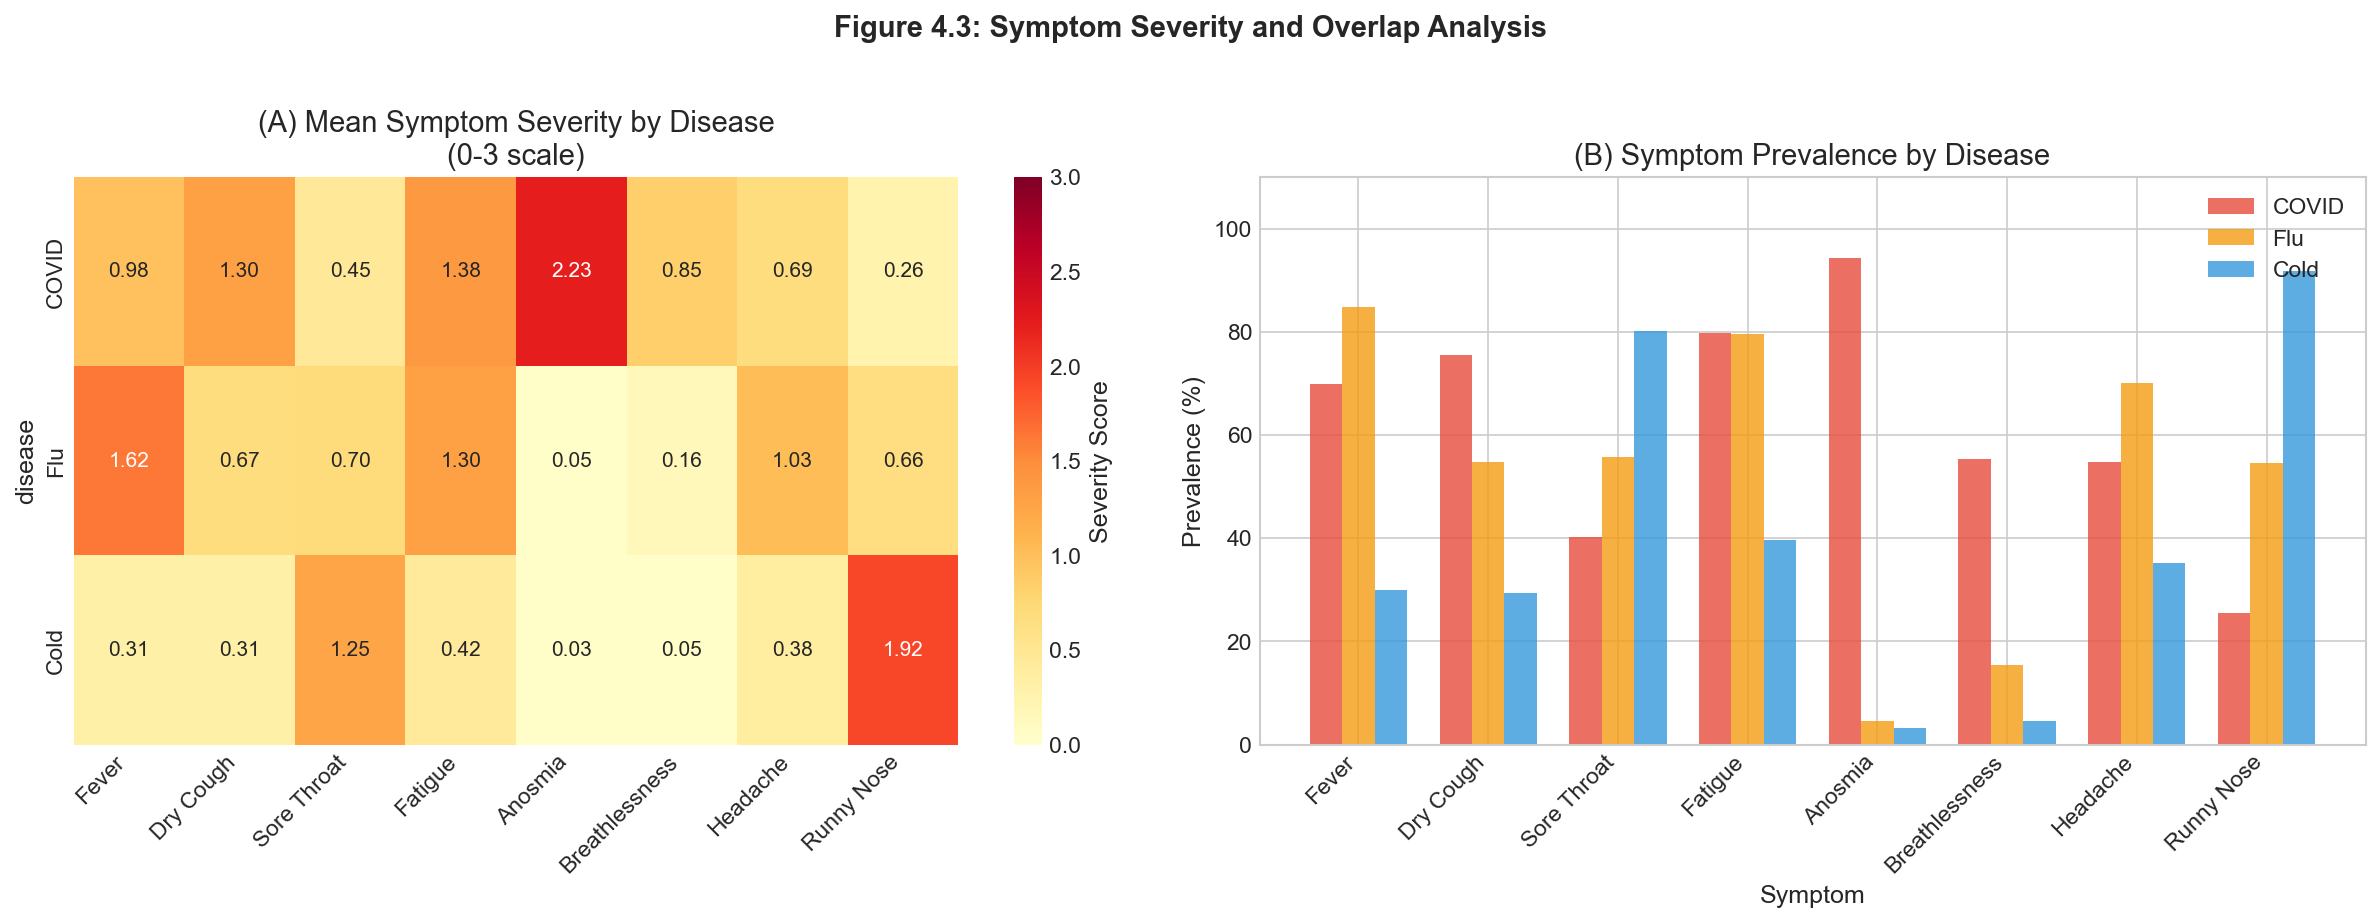

✅ Figure 4.3 generated


In [14]:
# Create Figure 4.3: Symptom Heatmap
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Panel A: Symptom Severity Heatmap
ax1 = axes[0]
sns.heatmap(symptom_means, annot=True, fmt='.2f', cmap='YlOrRd',
            linewidths=0, linecolor='white',
            vmin=0, vmax=3, ax=ax1, cbar_kws={'label': 'Severity Score'},
            annot_kws={'size': 10})
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_title('(A) Mean Symptom Severity by Disease\n(0-3 scale)')

# Panel B: Symptom Prevalence Bar Chart
ax2 = axes[1]

# Calculate prevalence
prevalence = {}
for disease in ['COVID', 'Flu', 'Cold']:
    disease_data = df[df['disease'] == disease]
    prevalence[disease] = [(disease_data[col] > 0).mean() * 100 for col in symptom_cols]

x = np.arange(len(symptom_names))
width = 0.25

for i, disease in enumerate(['COVID', 'Flu', 'Cold']):
    ax2.bar(x + i*width, prevalence[disease], width, label=disease, color=COLORS[disease], alpha=0.8)

ax2.set_xlabel('Symptom')
ax2.set_ylabel('Prevalence (%)')
ax2.set_title('(B) Symptom Prevalence by Disease')
ax2.set_xticks(x + width)
ax2.set_xticklabels(symptom_names, rotation=45, ha='right')
ax2.legend(loc='upper right')
ax2.set_ylim(0, 110)

plt.suptitle('Figure 4.3: Symptom Severity and Overlap Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()
print("✅ Figure 4.3 generated")

## 2.4 Geospatial & Accessibility Analysis 

In [15]:
# Medical Desert Analysis
rural_df = df[df['access_population_density'] <= 2]
urban_df = df[df['access_population_density'] >= 5]

print("🏥 Medical Desert Analysis")
print("="*60)
print(f"\nUrban patients (density 5-6): {len(urban_df):,} ({len(urban_df)/len(df)*100:.1f}%)")
print(f"  Avg distance to hospital: {urban_df['access_distance_hospital'].mean():.2f}")
print(f"\nRural patients (density 1-2): {len(rural_df):,} ({len(rural_df)/len(df)*100:.1f}%)")
print(f"  Avg distance to hospital: {rural_df['access_distance_hospital'].mean():.2f}")
print(f"  Patients with distance ≥4: {(rural_df['access_distance_hospital'] >= 4).mean()*100:.1f}%")

# Admission delay skewness
skewness = stats.skew(df['access_admission_delay'])
print(f"\n⏱️ Admission Delay Index:")
print(f"  Mean: {df['access_admission_delay'].mean():.2f}")
print(f"  Median: {df['access_admission_delay'].median():.2f}")
print(f"  Skewness: {skewness:.2f} (positively skewed)")

🏥 Medical Desert Analysis

Urban patients (density 5-6): 19,923 (39.8%)
  Avg distance to hospital: 1.02

Rural patients (density 1-2): 17,491 (35.0%)
  Avg distance to hospital: 3.27
  Patients with distance ≥4: 36.2%

⏱️ Admission Delay Index:
  Mean: 2.07
  Median: 1.02
  Skewness: 2.20 (positively skewed)


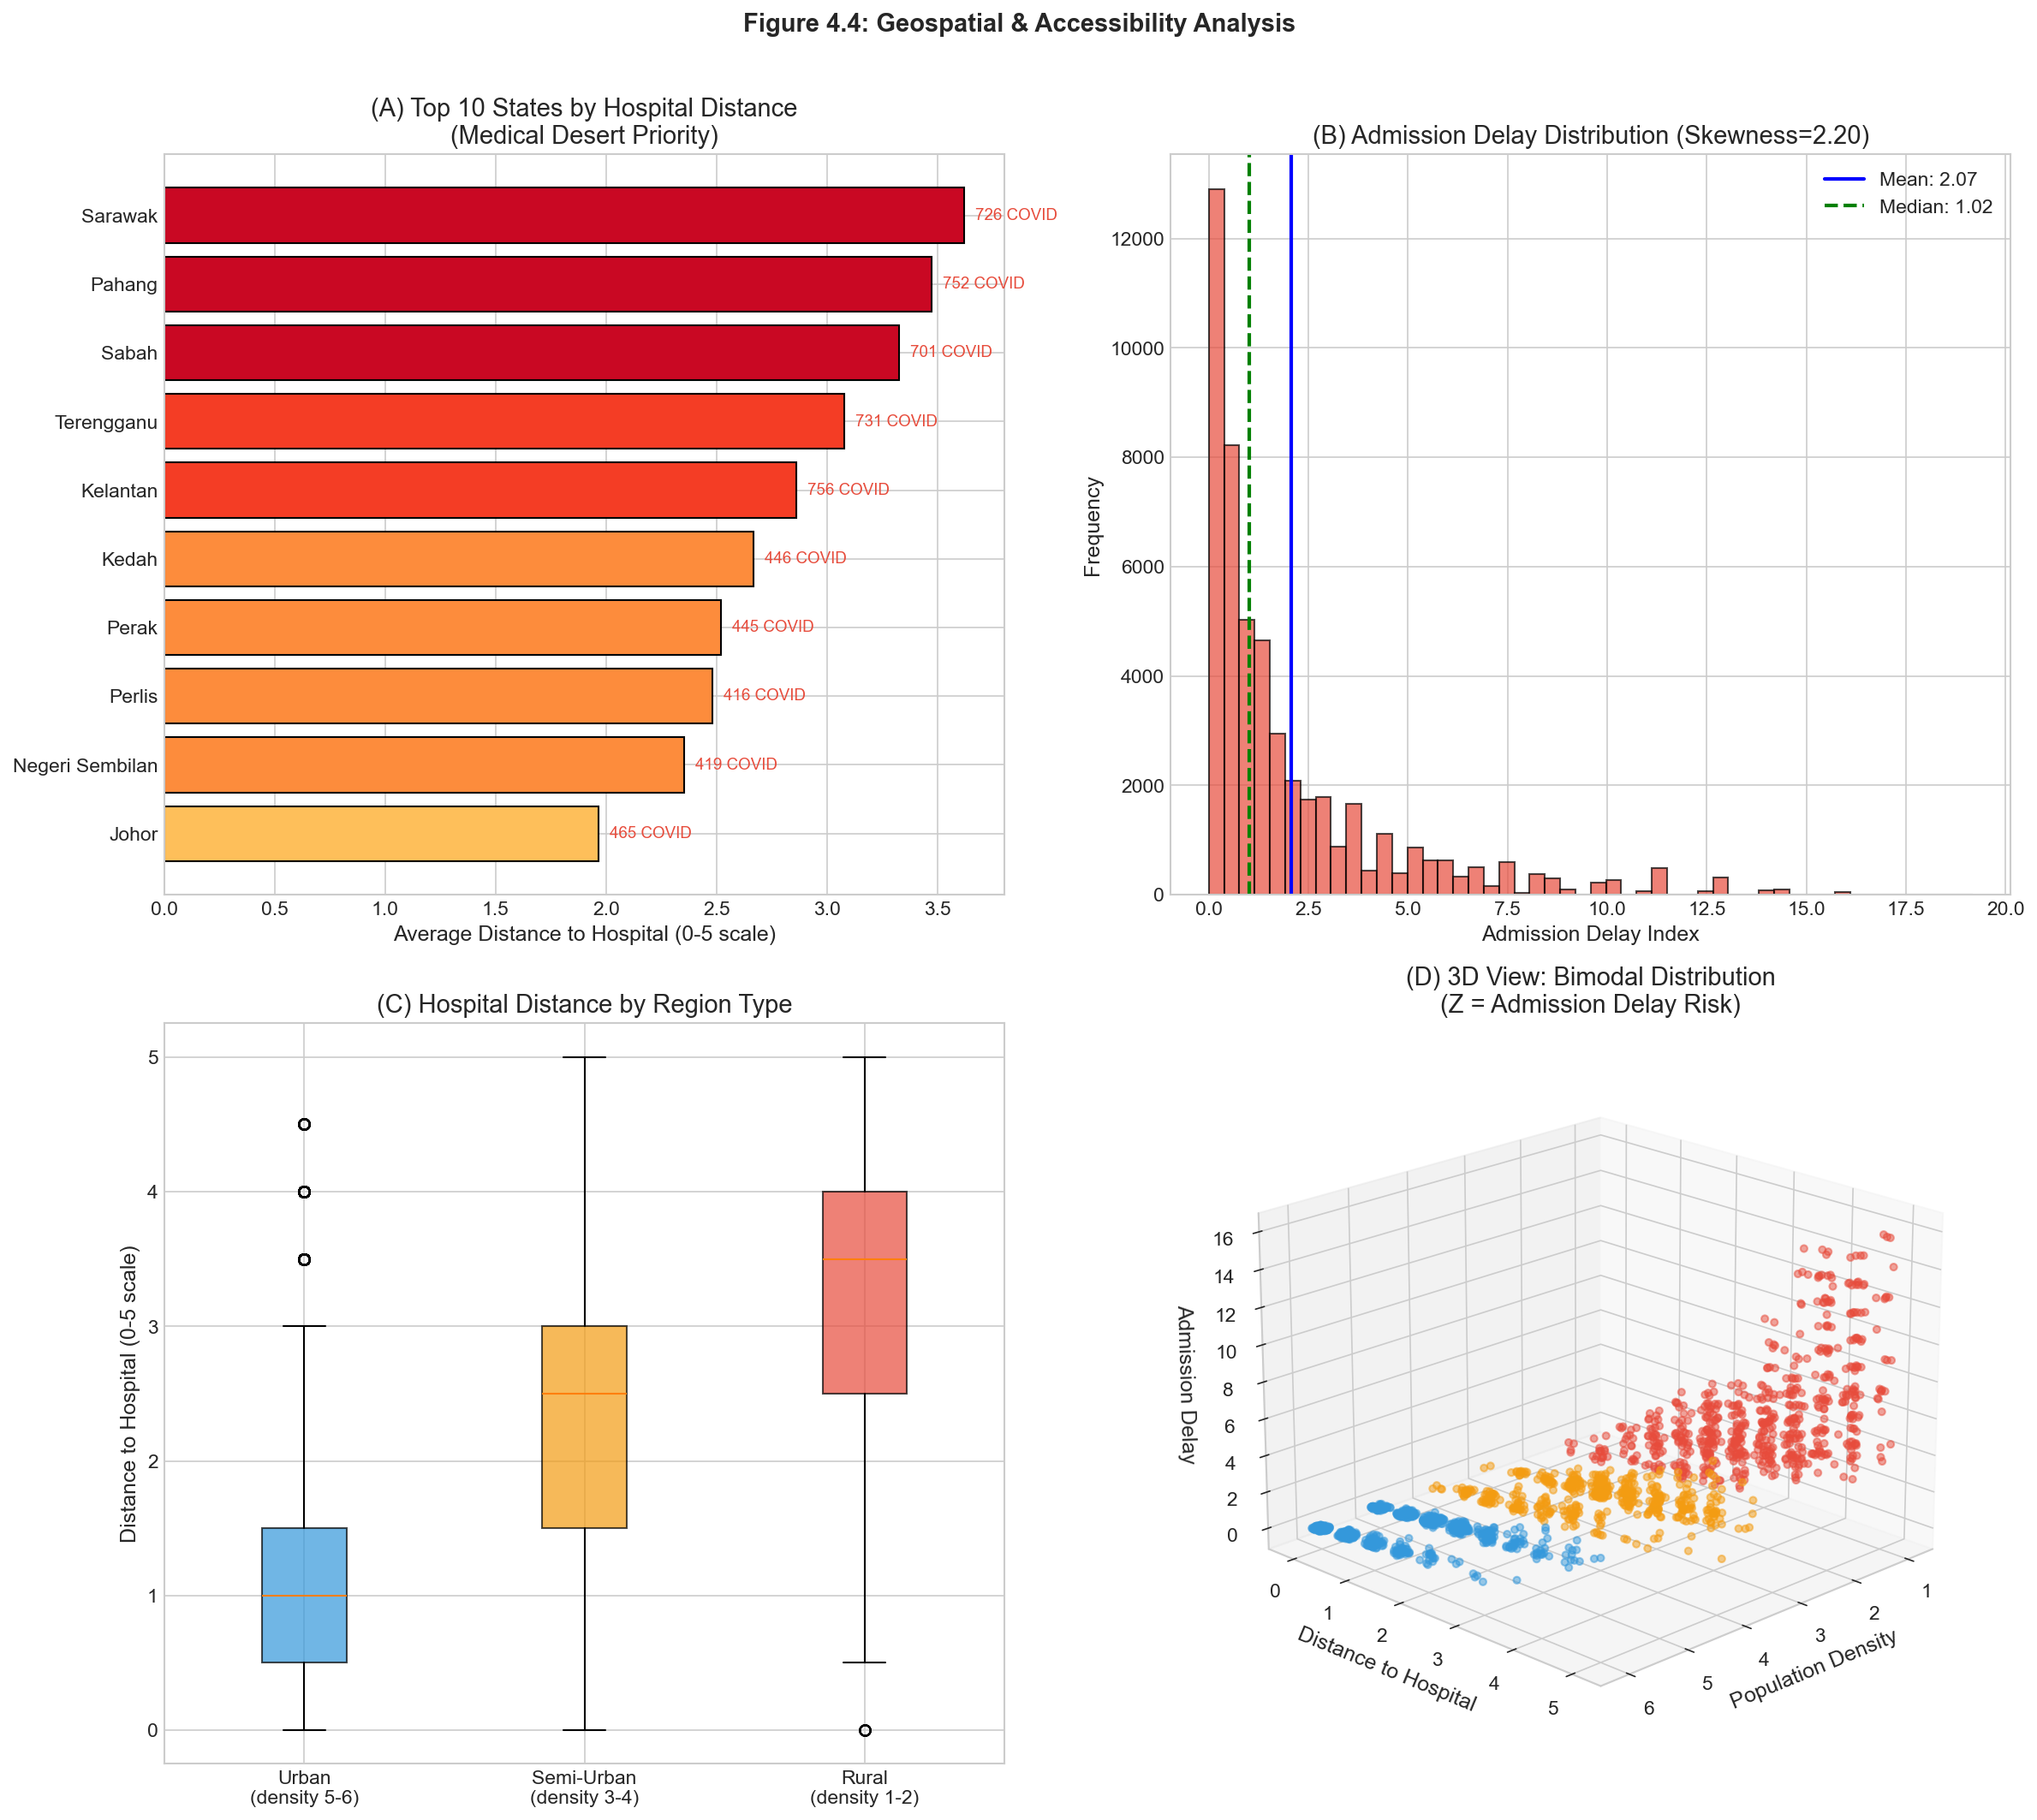

✅ Figure 4.4 generated


In [16]:
# Create Figure 4.4: Accessibility Analysis
fig = plt.figure(figsize=(16, 14))

# Panel A: Top 10 States by Hospital Distance
ax1 = fig.add_subplot(2, 2, 1)
state_stats = df.groupby('state').agg({
    'access_distance_hospital': 'mean',
    'disease': lambda x: (x == 'COVID').sum(),
    'access_population_density': 'mean'
}).reset_index()
state_stats.columns = ['State', 'Avg_Distance', 'COVID_Cases', 'Avg_Density']
state_stats = state_stats.sort_values('Avg_Distance', ascending=False).head(10)

colors = plt.cm.YlOrRd(1 - state_stats['Avg_Density'] / 6)
bars = ax1.barh(range(len(state_stats)), state_stats['Avg_Distance'], color=colors, edgecolor='black')
ax1.set_yticks(range(len(state_stats)))
ax1.set_yticklabels(state_stats['State'])
ax1.set_xlabel('Average Distance to Hospital (0-5 scale)')
ax1.set_title('(A) Top 10 States by Hospital Distance\n(Medical Desert Priority)')
ax1.invert_yaxis()

for i, (dist, cases) in enumerate(zip(state_stats['Avg_Distance'], state_stats['COVID_Cases'])):
    ax1.text(dist + 0.05, i, f'{int(cases)} COVID', va='center', fontsize=9, color='#e74c3c')

# Panel B: Admission Delay Histogram
ax2 = fig.add_subplot(2, 2, 2)
ax2.hist(df['access_admission_delay'], bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax2.axvline(x=df['access_admission_delay'].mean(), color='blue', linestyle='-', linewidth=2, label=f'Mean: {df["access_admission_delay"].mean():.2f}')
ax2.axvline(x=df['access_admission_delay'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["access_admission_delay"].median():.2f}')
ax2.set_xlabel('Admission Delay Index')
ax2.set_ylabel('Frequency')
ax2.set_title(f'(B) Admission Delay Distribution (Skewness={skewness:.2f})')
ax2.legend()

# Panel C: Distance by Region Type
ax3 = fig.add_subplot(2, 2, 3)
region_data = []
region_labels = []
region_colors = []

for density_range, label, color in [(range(5, 7), 'Urban\n(density 5-6)', '#3498db'),
                                     (range(3, 5), 'Semi-Urban\n(density 3-4)', '#f39c12'),
                                     (range(1, 3), 'Rural\n(density 1-2)', '#e74c3c')]:
    data = df[df['access_population_density'].isin(density_range)]['access_distance_hospital']
    region_data.append(data)
    region_labels.append(label)
    region_colors.append(color)

bp = ax3.boxplot(region_data, labels=region_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], region_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax3.set_ylabel('Distance to Hospital (0-5 scale)')
ax3.set_title('(C) Hospital Distance by Region Type')

# Panel D: 3D Scatter
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
region_colors_map = []
for density in df['access_population_density']:
    if density >= 5:
        region_colors_map.append('#3498db')
    elif density >= 3:
        region_colors_map.append('#f39c12')
    else:
        region_colors_map.append('#e74c3c')

xs = df['access_population_density'].values
ys = df['access_distance_hospital'].values
zs = df['access_admission_delay'].values

sample_idx = np.random.choice(len(df), min(2000, len(df)), replace=False)
xs_sample = xs[sample_idx] + np.random.uniform(-0.1, 0.1, len(sample_idx))
ys_sample = ys[sample_idx] + np.random.uniform(-0.1, 0.1, len(sample_idx))
zs_sample = zs[sample_idx]
colors_sample = [region_colors_map[i] for i in sample_idx]

ax4.scatter(xs_sample, ys_sample, zs_sample, c=colors_sample, alpha=0.5, s=15)
ax4.set_xlabel('Population Density')
ax4.set_ylabel('Distance to Hospital')
ax4.set_zlabel('Admission Delay')
ax4.set_title('(D) 3D View: Bimodal Distribution\n(Z = Admission Delay Risk)')
ax4.view_init(elev=20, azim=45)

plt.suptitle('Figure 4.4: Geospatial & Accessibility Analysis', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()
print("✅ Figure 4.4 generated")

## 2.5 Correlation Matrix (Multicollinearity Analysis)

In [17]:
# Select numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Group features based on your naming convention
symptom_cols = [c for c in numerical_cols if c.startswith('symptom_')]
blood_cols = [c for c in numerical_cols if c.startswith('blood_')]
risk_cols = [c for c in numerical_cols if c.startswith('risk_')]
access_cols = [c for c in numerical_cols if c.startswith('access_')]
demo_cols = ['age']

# Order columns logically
ordered_cols = symptom_cols + blood_cols + risk_cols + access_cols + demo_cols
ordered_cols = [c for c in ordered_cols if c in numerical_cols]

# Calculate correlation matrix
corr_matrix = df[ordered_cols].corr(method='pearson')

# 1. Collect all pairs first
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        
        # Threshold check
        if abs(corr_val) > 0.5:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_pairs.append((col1, col2, corr_val))

# 2. Sort by Absolute Magnitude (Modulus) - High to Low
high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

# 3. Print with DYNAMIC ALIGNMENT
print("🔗 High Correlations (Ranked by Magnitude |r| > 0.5):")
print("="*80)

if high_corr_pairs:
    # Calculate the maximum width needed for the first and second columns
    # We add +2 padding for visual breathing room
    w1 = max([len(p[0]) for p in high_corr_pairs]) + 2
    w2 = max([len(p[1]) for p in high_corr_pairs]) + 2

    for col1, col2, r in high_corr_pairs:
        # {col1:<{w1}} means: print col1, left-aligned, taking up 'w1' amount of space
        print(f"  {col1:<{w1}} ↔ {col2:<{w2}} : r = {r:+.3f}")
else:
    print("  No high correlations found (|r| > 0.5)")

🔗 High Correlations (Ranked by Magnitude |r| > 0.5):
  blood_neutrophils               ↔ blood_nlr                       : r = +0.860
  symptom_anosmia                 ↔ blood_nlr                       : r = +0.830
  access_nearest_hospital_scale   ↔ access_population_density       : r = +0.829
  symptom_anosmia                 ↔ blood_neutrophils               : r = +0.786
  blood_lymphocytes               ↔ blood_nlr                       : r = -0.783
  access_distance_hospital        ↔ access_admission_delay          : r = +0.746
  access_distance_clinic          ↔ access_population_density       : r = -0.740
  access_distance_hospital        ↔ access_population_density       : r = -0.735
  blood_neutrophils               ↔ blood_lymphocytes               : r = -0.731
  access_nearest_hospital_scale   ↔ access_admission_delay          : r = -0.722
  symptom_anosmia                 ↔ blood_lymphocytes               : r = -0.686
  access_population_density       ↔ access_admission_del

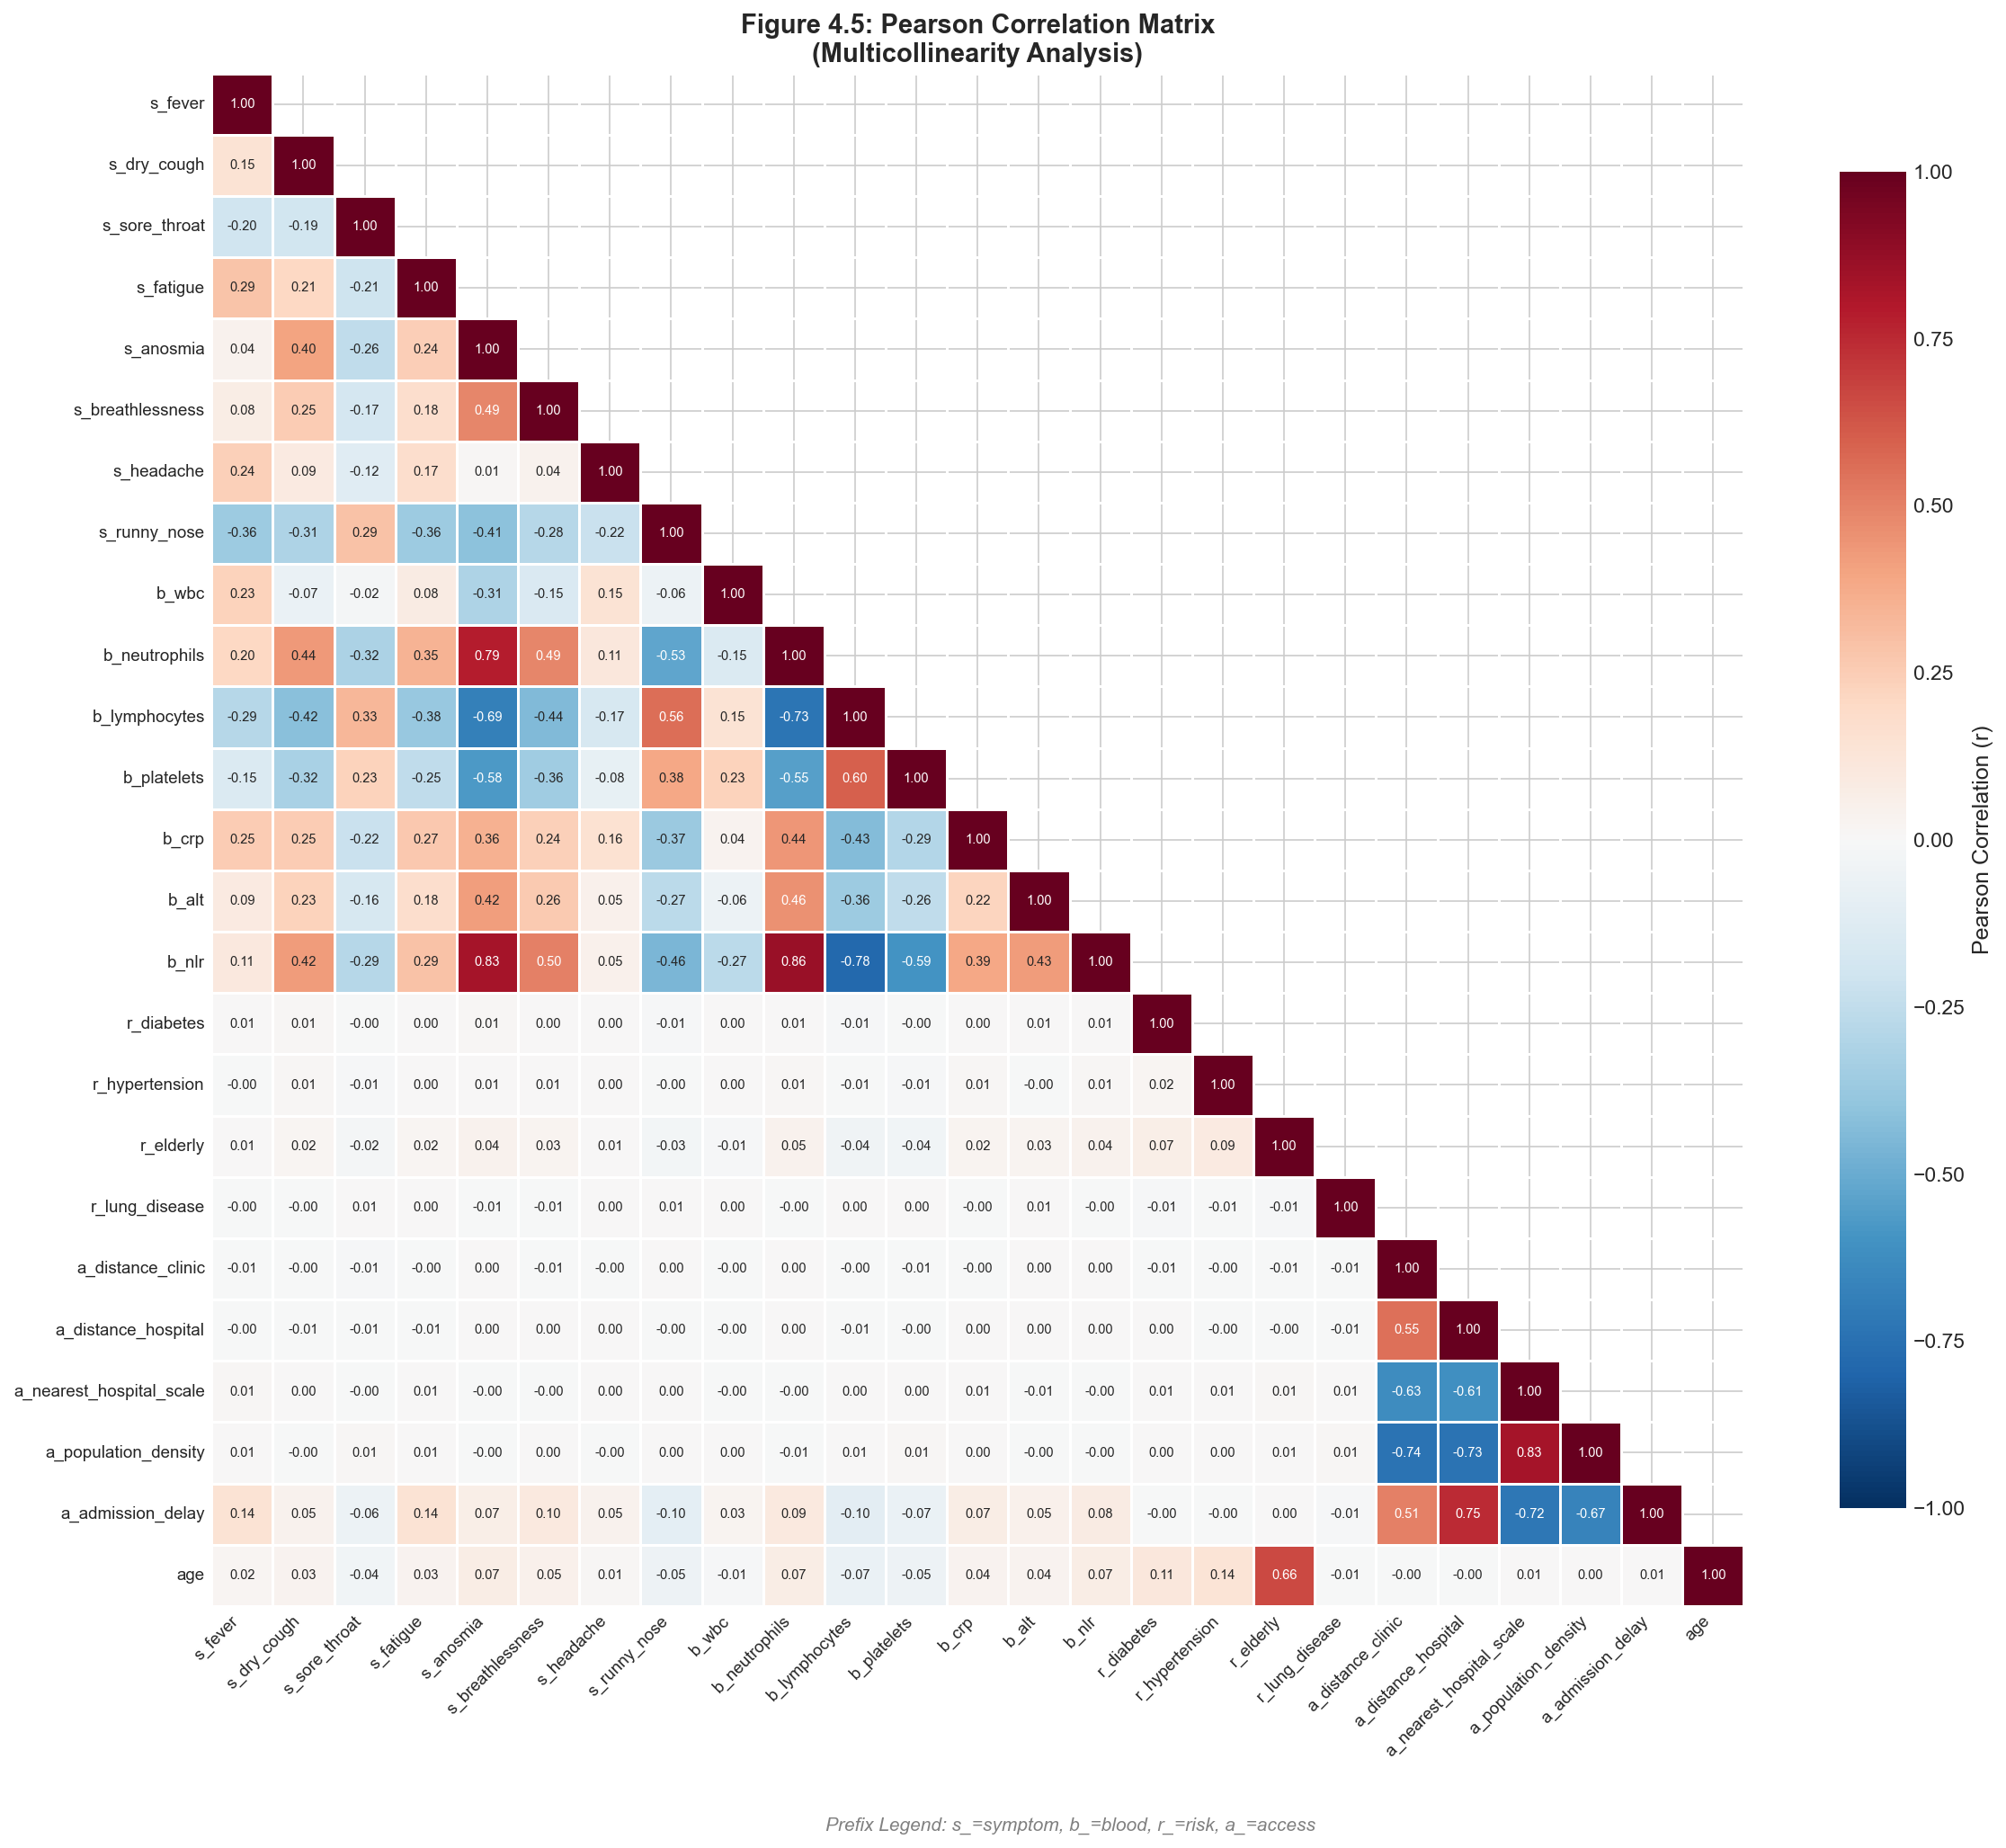

✅ Figure 4.5 generated


In [18]:
# Create correlation heatmap
fig, ax = plt.subplots(figsize=(16, 14))

# Create shorter labels
short_labels = []
for col in ordered_cols:
    label = col.replace('symptom_', 's_').replace('blood_', 'b_').replace('risk_', 'r_').replace('access_', 'a_')
    short_labels.append(label)

# Generate heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Pearson Correlation (r)', 'shrink': 0.8},
    annot_kws={'size': 7},
    ax=ax,
    xticklabels=short_labels,
    yticklabels=short_labels
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
ax.set_title('Figure 4.5: Pearson Correlation Matrix\n(Multicollinearity Analysis)', fontsize=14, fontweight='bold')

legend_text = "Prefix Legend: s_=symptom, b_=blood, r_=risk, a_=access"
fig.text(0.5, 0.02, legend_text, ha='center', fontsize=10, style='italic', color='gray')

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()
print("✅ Figure 4.5 generated")

## 2.5 Feature Evaluation and Validation with XGBoost
### Rank Feature Importance

In [19]:
# Importing Required Libraries

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score)
# Load Data Function definition
def load_data(data_dir: str = ".") -> tuple:
    """Load train, validation, and test datasets."""
    train_df = pd.read_csv(os.path.join(data_dir, "rm19_dataset_train.csv"))
    val_df = pd.read_csv(os.path.join(data_dir, "rm19_dataset_val.csv"))
    test_df = pd.read_csv(os.path.join(data_dir, "rm19_dataset_test.csv"))
    
    print(f"Loaded datasets:")
    print(f"  Train: {train_df.shape}")
    print(f"  Validation: {val_df.shape}")
    print(f"  Test: {test_df.shape}")
    
    return train_df, val_df, test_df

# Preprocessing Function definition
def preprocess_data(df: pd.DataFrame, label_encoders: dict = None, 
                    fit: bool = False) -> tuple:
    """Preprocess data for ML models."""
    df = df.copy()
    
    if label_encoders is None:
        label_encoders = {}
    
    # Encode categorical columns
    categorical_cols = ['gender', 'state']
    for col in categorical_cols:
        if fit or col not in label_encoders:
            label_encoders[col] = LabelEncoder()
            df[col] = label_encoders[col].fit_transform(df[col])
        else:
            df[col] = label_encoders[col].transform(df[col])
    
    # Separate features and target
    X = df.drop(columns=['disease'])
    y = df['disease']
    
    # Encode target
    if fit or 'disease' not in label_encoders:
        label_encoders['disease'] = LabelEncoder()
        y = label_encoders['disease'].fit_transform(y)
    else:
        y = label_encoders['disease'].transform(y)
    
    return X, y, label_encoders


# XG Boost Function definition
def train_xgboost(X_train, y_train, X_val, y_val, random_state=42):
    classes = np.unique(y_train)
    class_weights = compute_class_weight(
        class_weight="balanced",
        classes=classes,
        y=y_train
    )
    class_weight_dict = dict(zip(classes, class_weights))
    sample_weights = np.array([class_weight_dict[y] for y in y_train])

    model = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=8,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        eval_metric="mlogloss",
        early_stopping_rounds=20
    )

    model.fit(
        X_train, y_train,
        sample_weight=sample_weights,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    return model

# Evaluate Model Function definition
def evaluate_model(model, X: pd.DataFrame, y: np.ndarray,
                   label_encoder: LabelEncoder, dataset_name: str = "Test") -> dict:
    """Evaluate model with focus on F1-Score for imbalanced data."""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_weighted = f1_score(y, y_pred, average='weighted')
    precision_macro = precision_score(y, y_pred, average='macro')
    recall_macro = recall_score(y, y_pred, average='macro')
    
    # ROC-AUC for multi-class
    try:
        roc_auc = roc_auc_score(y, y_proba, multi_class='ovr', average='macro')
    except:
        roc_auc = None
    
    print(f"\n📊 {dataset_name} Set Results:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   F1-Score (macro): {f1_macro:.4f}  ← Key metric for imbalanced data")
    print(f"   F1-Score (weighted): {f1_weighted:.4f}")
    print(f"   Precision (macro): {precision_macro:.4f}")
    print(f"   Recall (macro): {recall_macro:.4f}")
    if roc_auc:
        print(f"   ROC-AUC (macro): {roc_auc:.4f}")
    
    # Per-class metrics
    class_names = label_encoder.classes_
    print(f"\n📋 Classification Report ({dataset_name}):")
    print(classification_report(y, y_pred, target_names=class_names))
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision': precision_macro,
        'recall': recall_macro,
        'roc_auc': roc_auc,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

# Feature Importance Plot 
def plot_feature_importance(model, feature_names, top_k=15):
    importances = model.feature_importances_
    idx = np.argsort(importances)[::-1][:top_k]

    colors = [
        "#e74c3c" if "nlr" in feature_names[i].lower() else "#3498db"
        for i in idx
    ]

    plt.figure(figsize=(10, 7))
    plt.barh(range(len(idx)), importances[idx], color=colors)
    plt.yticks(range(len(idx)), [feature_names[i] for i in idx])
    plt.gca().invert_yaxis()

    for i, fi in enumerate(idx):
        if "nlr" in feature_names[fi].lower():
            plt.text(
                importances[fi] + 0.01,
                i,
                "← NLR (key biomarker)",
                color="red",
                fontsize=10,
                fontweight="bold"
            )

    plt.xlabel("Feature Importance")
    plt.title("XGBoost Feature Importance\n(NLR highlighted)")
    plt.show()

# Confusion Matrix (define and call inline)
def plot_confusion_matrix(y_true, y_pred, class_names):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix - Disease Classification\n(XGBoost with Class Weights)')
    plt.tight_layout()
    plt.show()
    print("✅ Confusion matrix generated")
    

RM-19: AI TRIAGE SYSTEM - ML PIPELINE v2
XGBoost with Class Weights | Enhanced NLR Analysis
Loaded datasets:
  Train: (35000, 28)
  Validation: (10000, 28)
  Test: (5000, 28)

📊 Validation Set Results:
   Accuracy: 0.9904
   F1-Score (macro): 0.9918  ← Key metric for imbalanced data
   F1-Score (weighted): 0.9904
   Precision (macro): 0.9920
   Recall (macro): 0.9916
   ROC-AUC (macro): 0.9997

📋 Classification Report (Validation):
              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00      2065
        Cold       0.99      0.99      0.99      4406
         Flu       0.99      0.98      0.99      3529

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


📊 Test Set Results:
   Accuracy: 0.9892
   F1-Score (macro): 0.9908  ← Key metric for imbalanced data
   F1-Score (weighted): 0.9892
   Precision (macro): 0.9908
   Recall (macro): 0

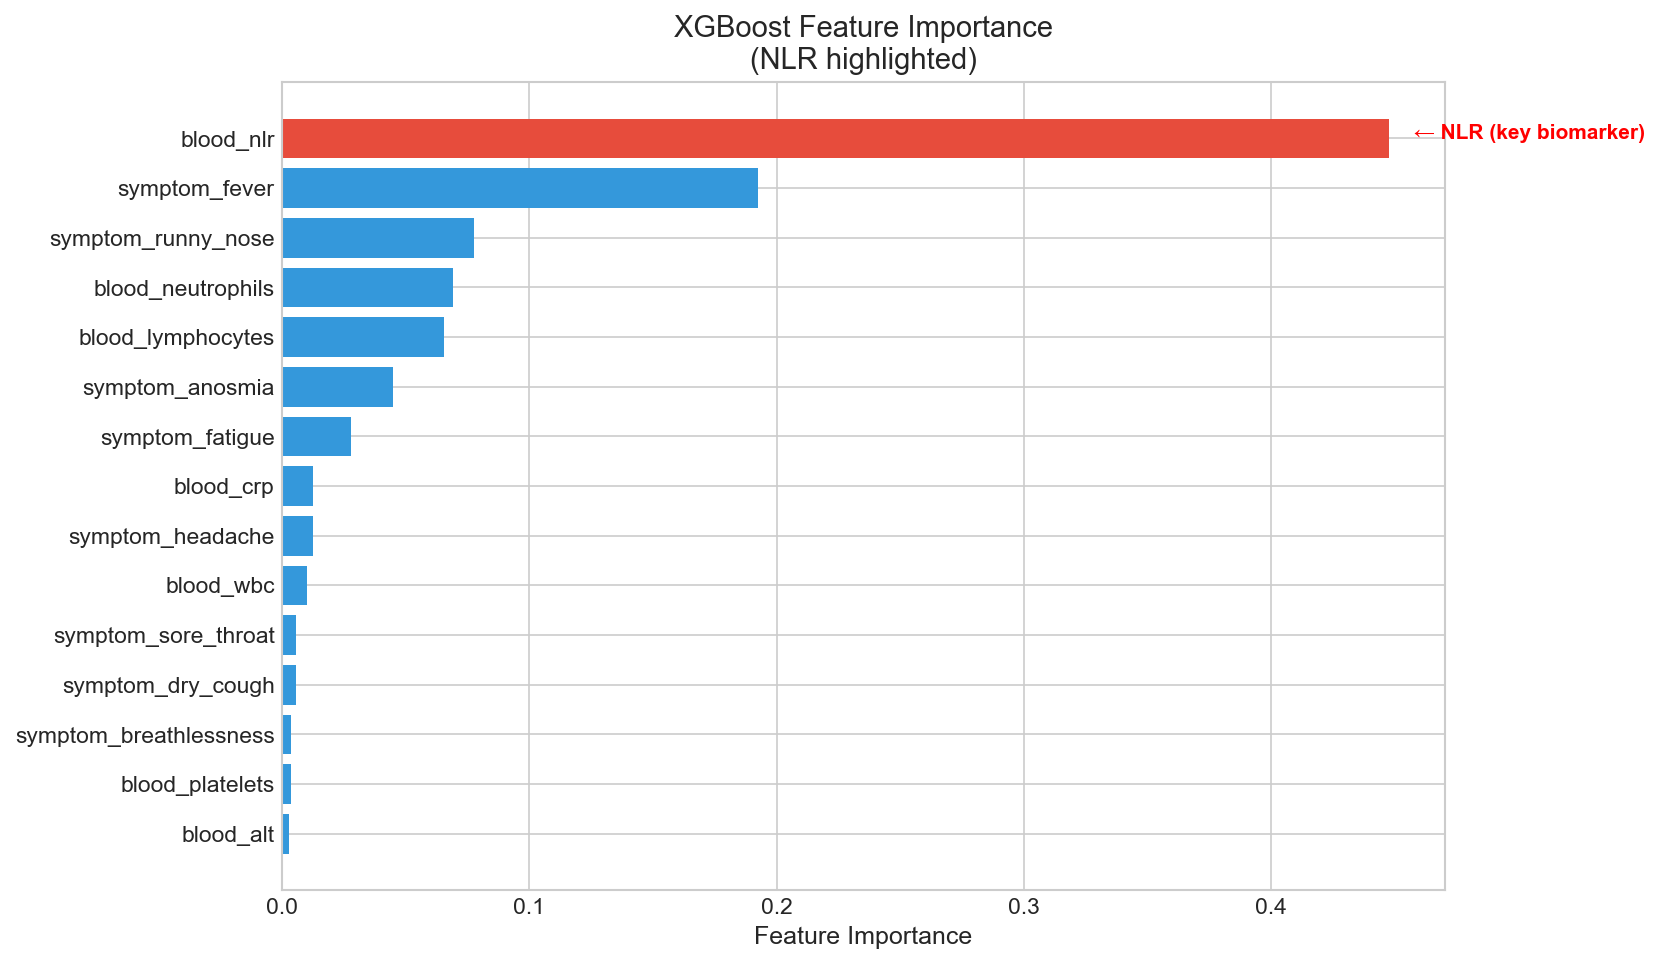

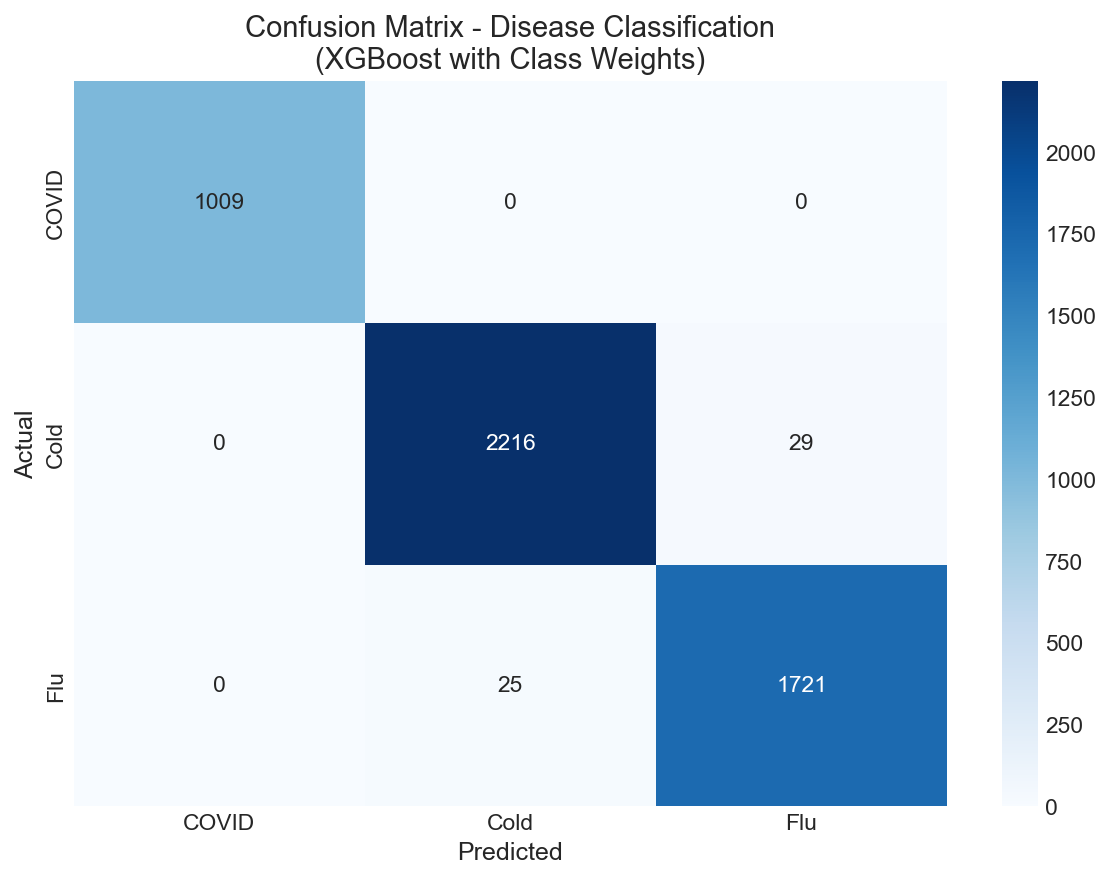

✅ Confusion matrix generated


In [20]:
print("="*60)
print("RM-19: AI TRIAGE SYSTEM - ML PIPELINE v2")
print("XGBoost with Class Weights | Enhanced NLR Analysis")
print("="*60)

# Load data from data folder
data_dir = "data"
output_dir = "data"
train_df, val_df, test_df = load_data(data_dir)
full_df = pd.read_csv(os.path.join(data_dir, "rm19_dataset_full.csv"))

X_train, y_train, encoders = preprocess_data(train_df, fit=True)
X_val, y_val, _ = preprocess_data(val_df, encoders)
X_test, y_test, _ = preprocess_data(test_df, encoders)

feature_importance_model = train_xgboost(X_train, y_train, X_val, y_val)
    
# Evaluate
val_results = evaluate_model(feature_importance_model, X_val, y_val, encoders['disease'], "Validation")
test_results = evaluate_model(feature_importance_model, X_test, y_test, encoders['disease'], "Test")
    
# Plots
plot_feature_importance(feature_importance_model, X_train.columns.tolist(), top_k=15)
plot_confusion_matrix(y_test, test_results['y_pred'], encoders['disease'].classes_)

---
# TASK 3 FEATURE ENGINEERING
## Optimizing Features for ML 
---

Based on feature importance from XGBoost and Pearson correlation analysis:

### Blood Features:
- **DROP**: `blood_neutrophils` & `blood_lymphocytes` (redundant with NLR)
- **KEEP**: `blood_nlr` (the derived ratio is more informative)

### Symptom Features:
- **KEEP** (based on importance + correlation):
  - `symptom_fever` - strong predictor (good for Flu vs COVID)
  - `symptom_runny_nose` - strong negative with COVID (Cold marker)
  - `symptom_anosmia` - important COVID-specific marker
  - `symptom_fatigue` - moderate importance
- **DROP**: Other 4 symptom features

### Risk Factors:
- **CREATE**: `Comorbidity_Index = diabetes + hypertension + lung_disease + elderly`
- **DROP**: Individual risk factors (reduces noise, increases stability)

### Accessibility:
- **DROP**: `access_nearest_hospital_scale` (redundant)
- **DROP**: `access_distance_clinic` (weak predictor)

### Demographics:
- **DROP**: `state` 

In [21]:
# Start with a copy of the full dataset
print("🔧 FEATURE ENGINEERING PIPELINE")
print("="*60)

df_engineered = df.copy()
print(f"\n📊 Original dataset shape: {df_engineered.shape}")
print(f"   Features: {df_engineered.columns.tolist()}")

🔧 FEATURE ENGINEERING PIPELINE

📊 Original dataset shape: (50000, 28)
   Features: ['disease', 'age', 'gender', 'state', 'symptom_fever', 'symptom_dry_cough', 'symptom_sore_throat', 'symptom_fatigue', 'symptom_anosmia', 'symptom_breathlessness', 'symptom_headache', 'symptom_runny_nose', 'blood_wbc', 'blood_neutrophils', 'blood_lymphocytes', 'blood_platelets', 'blood_crp', 'blood_alt', 'blood_nlr', 'risk_diabetes', 'risk_hypertension', 'risk_elderly', 'risk_lung_disease', 'access_distance_clinic', 'access_distance_hospital', 'access_nearest_hospital_scale', 'access_population_density', 'access_admission_delay']


## 3.1 Blood Features - Drop Neutrophils & Lymphocytes

In [22]:
# Drop blood_neutrophils and blood_lymphocytes (redundant with NLR)
blood_to_drop = ['blood_neutrophils', 'blood_lymphocytes']

print("\n1️⃣ BLOOD FEATURES")
print("-"*40)
print(f"   Dropping: {blood_to_drop}")
print(f"   Keeping: blood_nlr (NLR is the key COVID marker)")

df_engineered = df_engineered.drop(columns=blood_to_drop)
print(f"   ✅ Dropped {len(blood_to_drop)} blood columns")


1️⃣ BLOOD FEATURES
----------------------------------------
   Dropping: ['blood_neutrophils', 'blood_lymphocytes']
   Keeping: blood_nlr (NLR is the key COVID marker)
   ✅ Dropped 2 blood columns


## 3.2 Symptom Features

In [23]:
# Keep only important symptom features based on XGBoost importance
symptoms_to_keep = ['symptom_fever', 'symptom_runny_nose', 'symptom_anosmia', 'symptom_fatigue']
all_symptom_cols = [c for c in df_engineered.columns if c.startswith('symptom_')]
symptoms_to_drop = [c for c in all_symptom_cols if c not in symptoms_to_keep]

print("\n2️⃣ SYMPTOM FEATURES")
print("-"*40)
print(f"   Keeping: {symptoms_to_keep}")
print(f"   Reason:")
print(f"     - symptom_fever: Strong predictor (Flu vs COVID differentiation)")
print(f"     - symptom_runny_nose: Strong negative correlation with COVID (Cold marker)")
print(f"     - symptom_anosmia: COVID-specific marker (95% prevalence in COVID)")
print(f"     - symptom_fatigue: Moderate importance, general indicator")
print(f"   Dropping: {symptoms_to_drop}")

df_engineered = df_engineered.drop(columns=symptoms_to_drop)
print(f"   ✅ Dropped {len(symptoms_to_drop)} symptom columns")


2️⃣ SYMPTOM FEATURES
----------------------------------------
   Keeping: ['symptom_fever', 'symptom_runny_nose', 'symptom_anosmia', 'symptom_fatigue']
   Reason:
     - symptom_fever: Strong predictor (Flu vs COVID differentiation)
     - symptom_runny_nose: Strong negative correlation with COVID (Cold marker)
     - symptom_anosmia: COVID-specific marker (95% prevalence in COVID)
     - symptom_fatigue: Moderate importance, general indicator
   Dropping: ['symptom_dry_cough', 'symptom_sore_throat', 'symptom_breathlessness', 'symptom_headache']
   ✅ Dropped 4 symptom columns


## 3.3 Risk Factors
### Individual Risk Factor were weak indicators, however combined is strongly correlated with severity

In [24]:
# Create Comorbidity_Index from risk factors
risk_components = ['risk_diabetes', 'risk_hypertension', 'risk_lung_disease', 'risk_elderly']

print("\n3️⃣ RISK FACTORS → COMORBIDITY INDEX")
print("-"*40)
print(f"   Creating: Comorbidity_Index = {' + '.join(risk_components)}")

# Check if all columns exist
existing_risk = [c for c in risk_components if c in df_engineered.columns]
print(f"   Found risk columns: {existing_risk}")

if len(existing_risk) > 0:
    df_engineered['comorbidity_index'] = df_engineered[existing_risk].sum(axis=1)
    print(f"\n   Comorbidity Index Statistics:")
    print(f"     Mean: {df_engineered['comorbidity_index'].mean():.2f}")
    print(f"     Max: {df_engineered['comorbidity_index'].max()}")
    print(f"     Distribution: {df_engineered['comorbidity_index'].value_counts().sort_index().to_dict()}")
    
    # Drop individual risk factors
    df_engineered = df_engineered.drop(columns=existing_risk)
    print(f"   ✅ Created comorbidity_index, dropped {len(existing_risk)} individual risk columns")
else:
    print("   ⚠️ No risk columns found in dataset")


3️⃣ RISK FACTORS → COMORBIDITY INDEX
----------------------------------------
   Creating: Comorbidity_Index = risk_diabetes + risk_hypertension + risk_lung_disease + risk_elderly
   Found risk columns: ['risk_diabetes', 'risk_hypertension', 'risk_lung_disease', 'risk_elderly']

   Comorbidity Index Statistics:
     Mean: 0.69
     Max: 4
     Distribution: {0: 23981, 1: 18492, 2: 6415, 3: 1058, 4: 54}
   ✅ Created comorbidity_index, dropped 4 individual risk columns


## 3.4 Accessibility 

In [25]:
# Drop weak accessibility features
access_to_drop = ['access_nearest_hospital_scale', 'access_distance_clinic']

print("\n4️⃣ ACCESSIBILITY FEATURES")
print("-"*40)

# Check which columns exist
existing_access_drop = [c for c in access_to_drop if c in df_engineered.columns]
print(f"   Dropping: {existing_access_drop}")
print(f"   Reason:")
print(f"     - access_nearest_hospital_scale: Redundant with distance_hospital")
print(f"     - access_distance_clinic: Weak predictor")

if len(existing_access_drop) > 0:
    df_engineered = df_engineered.drop(columns=existing_access_drop)
    print(f"   ✅ Dropped {len(existing_access_drop)} accessibility columns")
else:
    print("   ⚠️ Columns not found (may have different names)")
    
# Show remaining accessibility features
remaining_access = [c for c in df_engineered.columns if c.startswith('access_')]
print(f"   Keeping: {remaining_access}")


4️⃣ ACCESSIBILITY FEATURES
----------------------------------------
   Dropping: ['access_nearest_hospital_scale', 'access_distance_clinic']
   Reason:
     - access_nearest_hospital_scale: Redundant with distance_hospital
     - access_distance_clinic: Weak predictor
   ✅ Dropped 2 accessibility columns
   Keeping: ['access_distance_hospital', 'access_population_density', 'access_admission_delay']


## 3.5 Drop State Column for ML Training

In [26]:
# Drop state column
print("\n5️⃣ DEMOGRAPHIC FEATURES")
print("-"*40)

if 'state' in df_engineered.columns:
    df_engineered = df_engineered.drop(columns=['state'])
    print("   Dropped: state")
    print("   Reason: Geographic location may cause overfitting; model should generalize")
    print("   ✅ State column removed for ML training")
else:
    print("   ⚠️ State column not found")


5️⃣ DEMOGRAPHIC FEATURES
----------------------------------------
   Dropped: state
   Reason: Geographic location may cause overfitting; model should generalize
   ✅ State column removed for ML training


## 3.6 Feature Engineering Summary

In [27]:
# Summary
print("\n" + "="*60)
print("📊 FEATURE ENGINEERING SUMMARY")
print("="*60)

print(f"\n   Original features: {df.shape[1]}")
print(f"   Engineered features: {df_engineered.shape[1]}")
print(f"   Features reduced by: {df.shape[1] - df_engineered.shape[1]}")

print(f"\n📋 Final Feature Set:")
for i, col in enumerate(df_engineered.columns, 1):
    print(f"   {i}. {col}")


📊 FEATURE ENGINEERING SUMMARY

   Original features: 28
   Engineered features: 16
   Features reduced by: 12

📋 Final Feature Set:
   1. disease
   2. age
   3. gender
   4. symptom_fever
   5. symptom_fatigue
   6. symptom_anosmia
   7. symptom_runny_nose
   8. blood_wbc
   9. blood_platelets
   10. blood_crp
   11. blood_alt
   12. blood_nlr
   13. access_distance_hospital
   14. access_population_density
   15. access_admission_delay
   16. comorbidity_index


In [28]:
# Display the engineered dataset
print("\n📋 Engineered Dataset (first 5 rows):")
df_engineered.head()


📋 Engineered Dataset (first 5 rows):


disease  age  gender  symptom_fever  symptom_fatigue  symptom_anosmia  \
0   COVID   42    Male              2                2                3   
1    Cold   52  Female              1                0                0   
2     Flu   54  Female              2                0                0   
3    Cold   67    Male              0                0                0   
4   COVID   41  Female              0                2                3   

   symptom_runny_nose  blood_wbc  blood_platelets  blood_crp  blood_alt  \
0                   0       6.67           161.65      89.70      33.65   
1                   2       8.60           259.42      10.11      35.02   
2                   3       9.38           244.13      11.85      20.12   
3                   2      10.99           310.72       0.10      42.03   
4                   0       4.43           136.24       0.10      40.44   

   blood_nlr  access_distance_hospital  access_population_density  \
0       9.83                       4.5                          1   
1       1.02                       1.0                          5   
2       1.99                       4.5                          1   
3       1.39                       1.5                          5   
4      16.12                       1.0                          5   

   access_admission_delay  comorbidity_index  
0                   14.25                  1  
1                    0.41                  1  
2                    5.62                  1  
3                    0.38                  2  
4                    0.47                  1

In [29]:
# Save the engineered dataset
output_path = os.path.join(data_dir, "rm19_dataset_drop.csv")
df_engineered.to_csv(output_path, index=False)

print(f"\n💾 DATASET SAVED")
print("="*60)
print(f"   File: {output_path}")
print(f"   Shape: {df_engineered.shape[0]:,} samples × {df_engineered.shape[1]} features")
print(f"\n✅ Feature engineering complete!")


💾 DATASET SAVED
   File: data\rm19_dataset_drop.csv
   Shape: 50,000 samples × 16 features

✅ Feature engineering complete!


## 3.7 Comparison Before and After Feature Engineering

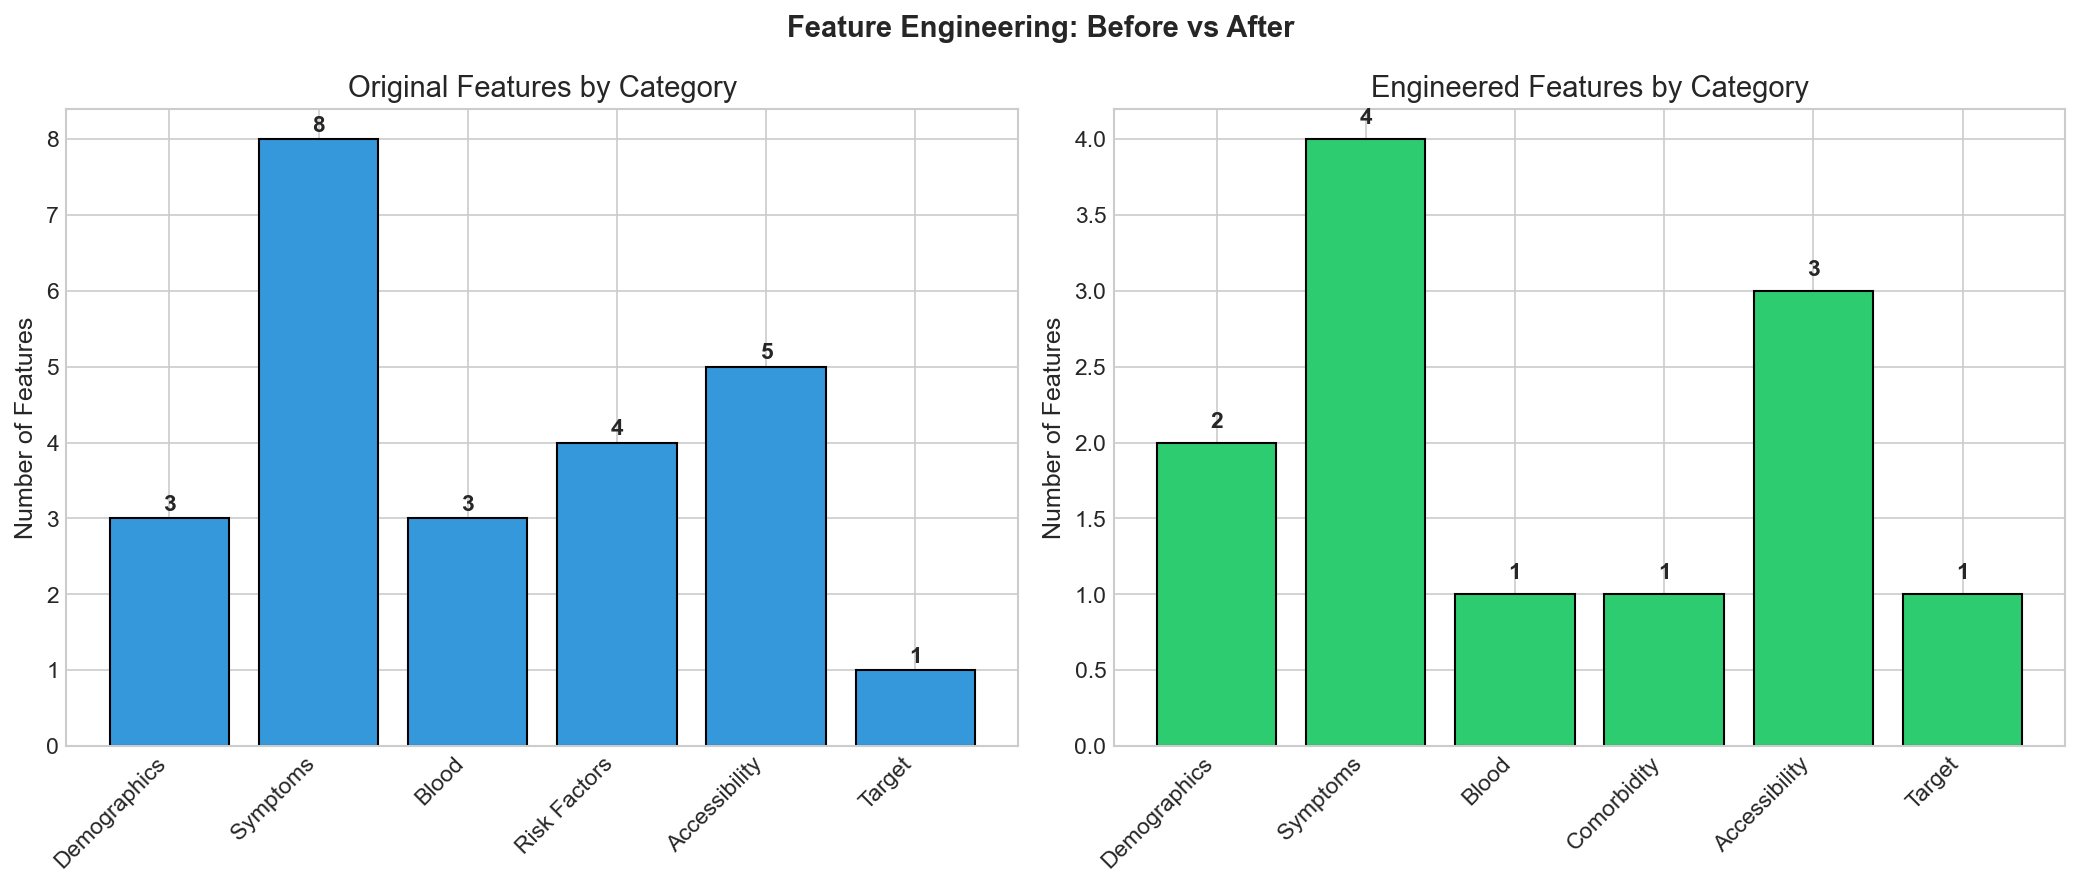


📉 Feature Reduction: 24 → 12 features
   Reduction: 12 features removed


In [30]:
# Create comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original features by category
ax1 = axes[0]
original_cats = {
    'Demographics': 3,  # age, gender, state
    'Symptoms': 8,
    'Blood': 3,
    'Risk Factors': 4,
    'Accessibility': 5,
    'Target': 1
}
ax1.bar(original_cats.keys(), original_cats.values(), color='#3498db', edgecolor='black')
ax1.set_ylabel('Number of Features')
ax1.set_title('Original Features by Category')
ax1.set_xticklabels(original_cats.keys(), rotation=45, ha='right')
for i, (cat, val) in enumerate(original_cats.items()):
    ax1.text(i, val + 0.1, str(val), ha='center', fontweight='bold')

# Engineered features by category
ax2 = axes[1]
engineered_cats = {
    'Demographics': 2,  # age, gender (no state)
    'Symptoms': 4,      # fever, runny_nose, anosmia, fatigue
    'Blood': 1,         # just NLR
    'Comorbidity': 1,   # comorbidity_index
    'Accessibility': 3, # reduced
    'Target': 1
}
ax2.bar(engineered_cats.keys(), engineered_cats.values(), color='#2ecc71', edgecolor='black')
ax2.set_ylabel('Number of Features')
ax2.set_title('Engineered Features by Category')
ax2.set_xticklabels(engineered_cats.keys(), rotation=45, ha='right')
for i, (cat, val) in enumerate(engineered_cats.items()):
    ax2.text(i, val + 0.1, str(val), ha='center', fontweight='bold')

plt.suptitle('Feature Engineering: Before vs After', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n📉 Feature Reduction: {sum(original_cats.values())} → {sum(engineered_cats.values())} features")
print(f"   Reduction: {sum(original_cats.values()) - sum(engineered_cats.values())} features removed")

# TASK 4: Artificial Intelligence (AI) - based Solutions

This section integrates advanced Classification (XGBoost, Logistic Regression) and Clustering (HDBSCAN, UMAP) analysis.


In [31]:
"""
Task 4: AI-based Solutions for RM-19 Dataset
=============================================
4.1 Classification: XGBoost + SHAP, Logistic Regression (L1)
4.2 Clustering: HDBSCAN (accessibility features only)
4.3 Hybrid Overlay: COVID probability per access cluster

Author: RM-19 Research Team
Date: 2026-01-20
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score)
from sklearn.utils.class_weight import compute_class_weight
from scipy import stats
import warnings
import os

# ML Libraries
import xgboost as xgb
import shap
import hdbscan
import umap
from pandas.plotting import parallel_coordinates
from math import pi

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

# ============================================================================
# CONFIGURATION
# ============================================================================

OUTPUT_DIR = "Output_XGBoost"
DATA_DIR = "Data"

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Color palette
COLORS = {
    'COVID': '#e74c3c',
    'Flu': '#f39c12', 
    'Cold': '#3498db'
}



## 4.1 Classification Models
- XGBoost with SHAP analysis
- Logistic Regression (L1) for interpretability


## 4.1.1 XGBoost

In [32]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression

# Configuration
DATA_DIR = "data"  # Update this to your actual data path
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Plotting Styles
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {'COVID': '#e74c3c', 'Flu': '#3498db', 'Pneumonia': '#95a5a6', 'Healthy': '#2ecc71'}

print("✅ Environment setup complete.")

✅ Environment setup complete.


In [33]:
# ==========================================
# 2. DATA LOADING & PREPARATION
# ==========================================

def load_and_prepare_data():
    """Load dataset and encode features."""
    # 1. Load Data
    # Replace with your actual file path
    csv_path = os.path.join(DATA_DIR, "rm19_dataset_drop.csv") 
    
    df = pd.read_csv(csv_path)

    print(f"📊 Dataset Shape: {df.shape}")

    # 2. Encode Features
    le_gender = LabelEncoder()
    df['gender_encoded'] = le_gender.fit_transform(df['gender'])

    feature_cols = [
        'age', 'gender_encoded',
        'symptom_fever', 'symptom_fatigue', 'symptom_anosmia', 'symptom_runny_nose',
        'blood_wbc', 'blood_platelets', 'blood_crp', 'blood_alt', 'blood_nlr',
        'comorbidity_index'
    ]

    X = df[feature_cols].copy()
    y = df['disease'].copy()

    # 3. Encode Target
    le_disease = LabelEncoder()
    y_encoded = le_disease.fit_transform(y)
    
    return X, y_encoded, le_disease, feature_cols, df

# Execute Preparation
X, y, le_disease, feature_names, raw_df = load_and_prepare_data()
print(f"✅ Features prepared. Classes: {le_disease.classes_}")

📊 Dataset Shape: (50000, 16)
✅ Features prepared. Classes: ['COVID' 'Cold' 'Flu']


In [34]:
# ==========================================
# 3. XGBOOST TRAINING
# ==========================================

def train_xgboost(X, y, label_encoder):
    # Compute class weights for imbalance handling
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weights = dict(zip(classes, weights))
    sample_weights = np.array([class_weights[yi] for yi in y])
    
    # Split Data (80/20)
    X_train, X_test, y_train, y_test, sw_train, _ = train_test_split(
        X, y, sample_weights, test_size=0.2, random_state=42, stratify=y
    )
    
    # Initialize Model
    model = xgb.XGBClassifier(
    # Core Boosting Parameters
    n_estimators=500,           # Increased from 150 (allows more refinement)
    learning_rate=0.05,         # Lowered from 0.1 (slower learning = less overfitting)
    max_depth=6,                # Reduced from 8 to prevent memorizing noise
    
    # Regularization (Crucial for Medical Triage)
    min_child_weight=2,         # Requires more samples to create a leaf (reduces noise sensitivity)
    gamma=0.2,                  # Minimum loss reduction required to make a split
    reg_alpha=0.1,              # L1 Regularization (Validation of your L1 findings)
    reg_lambda=1.0,             # L2 Regularization (Default)

    # Stochastic Sampling (prevents overfitting)
    subsample=0.8,              # Use 80% of data per tree
    colsample_bytree=0.8,       # Use 80% of features per tree

    # Technical Settings
    objective='multi:softprob', # Probabilistic output for 3 classes
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1                   # Use all CPU cores
)
    
    # Train
    model.fit(X_train, y_train, sample_weight=sw_train)
    print("============================================================")
    print("XGBOOST (with class weights) - ENGINEERED FEATURES ANALYSIS")
    print("============================================================")
    
    # Evaluate
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"\n📊 Test Metrics:\n Accuracy: {acc:.4f}\n F1-Score: {f1:.4f}")
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    return model, X_test, y_test, y_pred, y_proba

# Execute Training
xgb_model, X_test, y_test, y_pred, y_proba = train_xgboost(X, y, le_disease)

XGBOOST (with class weights) - ENGINEERED FEATURES ANALYSIS

📊 Test Metrics:
 Accuracy: 0.9810
 F1-Score: 0.9837

📋 Classification Report:
              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00      2070
        Cold       0.98      0.98      0.98      4435
         Flu       0.97      0.97      0.97      3495

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



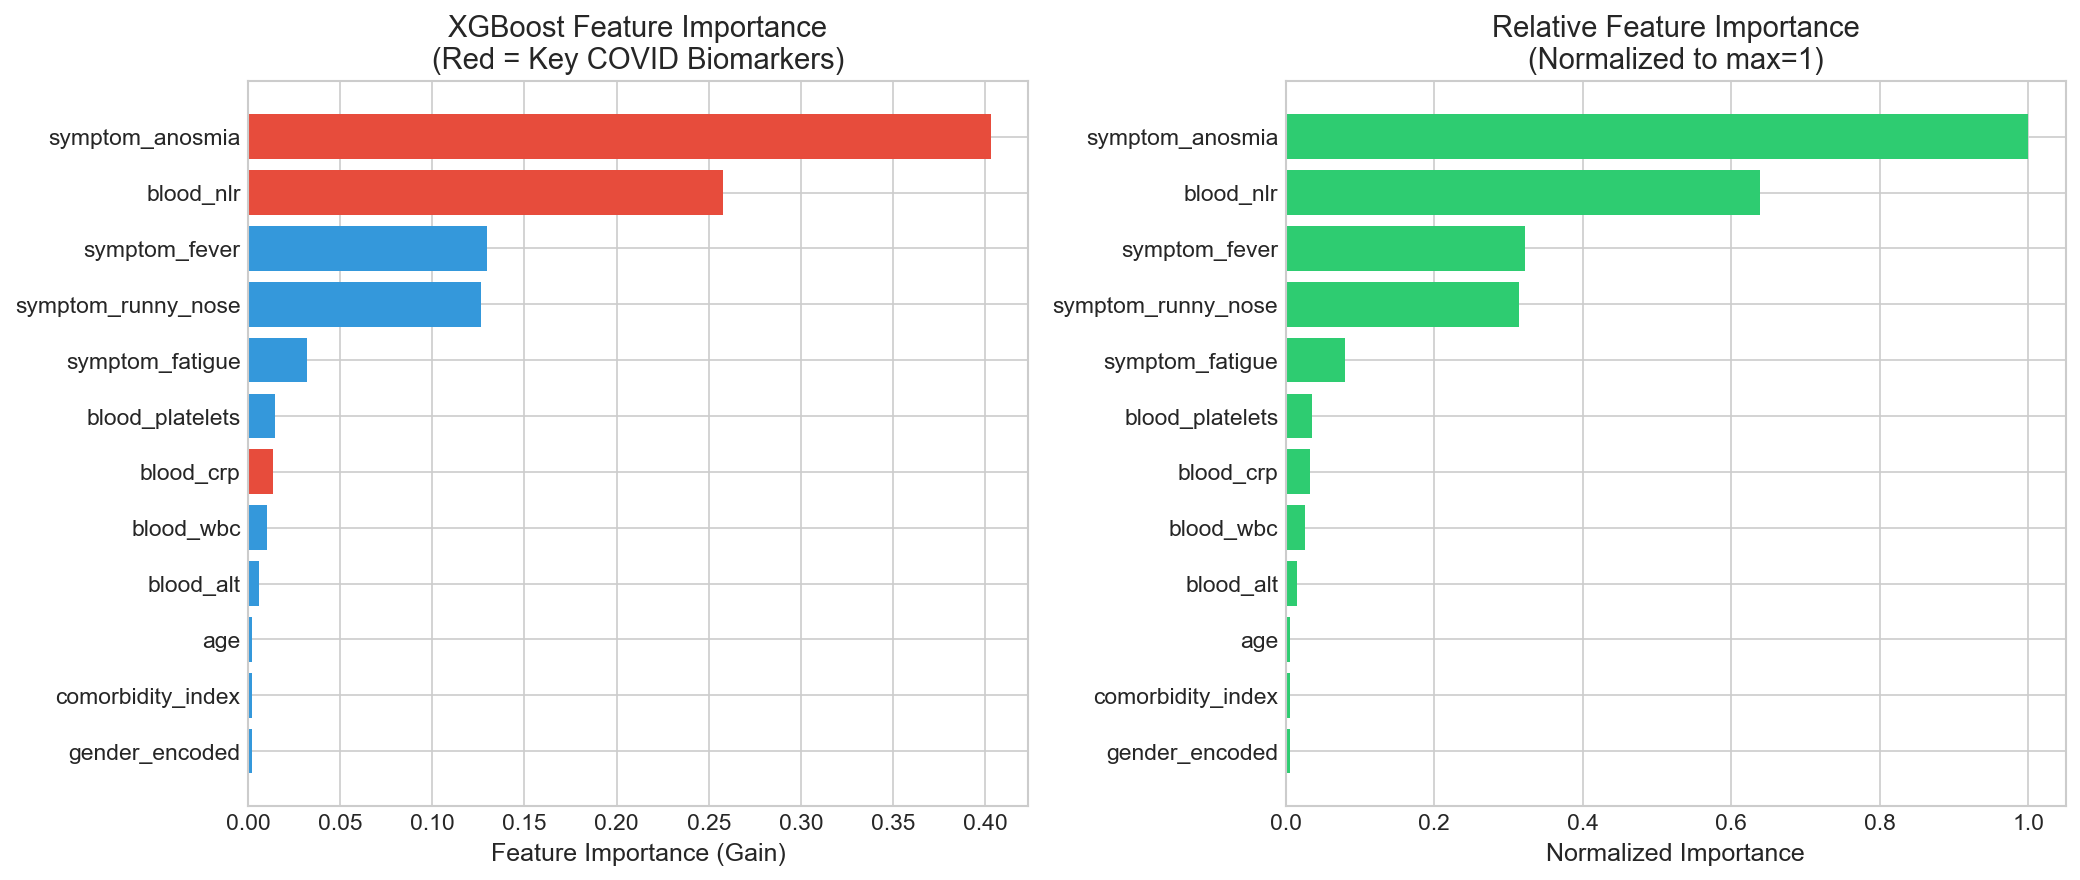

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names):
    # Extract importance
    importance_values = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance_Gain': importance_values
    }).sort_values('Importance_Gain', ascending=True)

    # Plotting
    # CHANGE HERE: Changed (1, 1) to (1, 2) to create two side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # 1. Absolute Gain
    ax1 = axes[0]
    # Highlight specific biomarkers in Red
    colors = ['#e74c3c' if f in ['blood_nlr', 'symptom_anosmia', 'blood_crp'] else '#3498db' 
              for f in importance_df['Feature']]
    
    ax1.barh(range(len(importance_df)), importance_df['Importance_Gain'], color=colors)
    ax1.set_yticks(range(len(importance_df)))
    ax1.set_yticklabels(importance_df['Feature'])
    ax1.set_xlabel('Feature Importance (Gain)')
    ax1.set_title('XGBoost Feature Importance\n(Red = Key COVID Biomarkers)')

    # 2. Normalized Importance (This section will now work)
    ax2 = axes[1]
    imp_normalized = importance_df.copy()
    imp_normalized['Normalized'] = imp_normalized['Importance_Gain'] / imp_normalized['Importance_Gain'].max()
    imp_sorted = imp_normalized.sort_values('Normalized', ascending=True)
    
    ax2.barh(range(len(imp_sorted)), imp_sorted['Normalized'], color='#2ecc71')
    ax2.set_yticks(range(len(imp_sorted)))
    ax2.set_yticklabels(imp_sorted['Feature'])
    ax2.set_xlabel('Normalized Importance')
    ax2.set_title('Relative Feature Importance\n(Normalized to max=1)')

    plt.tight_layout() # Prevents overlap between the two plots
    plt.show()

# Run the function
plot_feature_importance(xgb_model, feature_names)

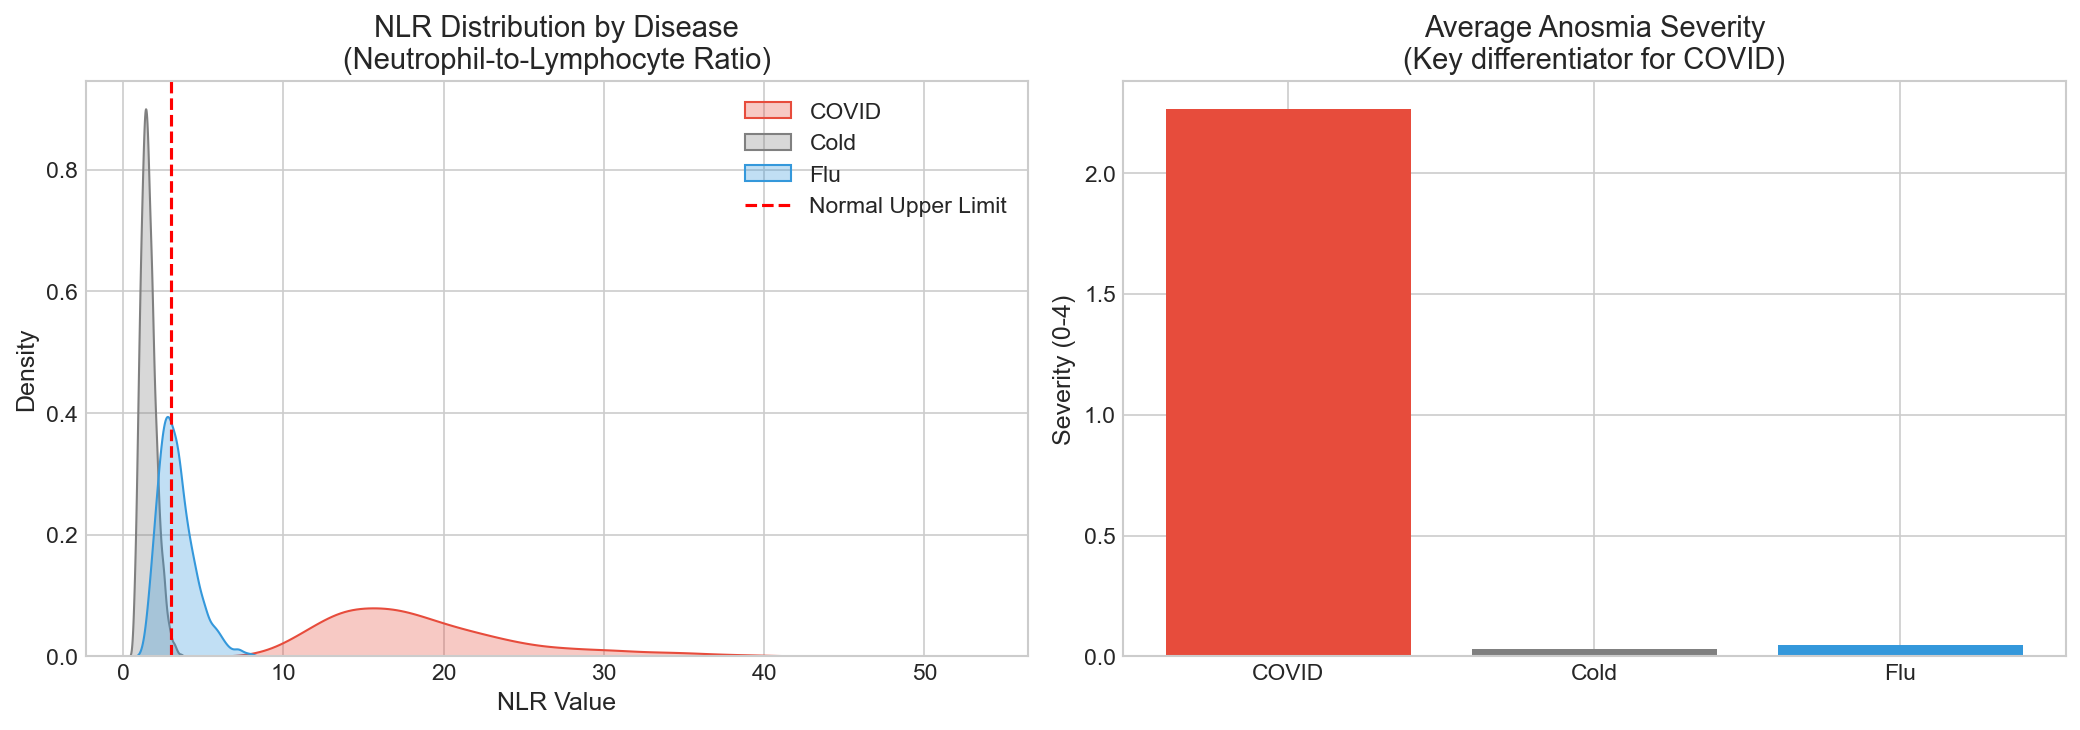

In [36]:
# ==========================================
# 5. BIOMARKER ANALYSIS
# ==========================================

def plot_biomarkers(X_data, y_data, label_encoder):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    decoded_disease = label_encoder.inverse_transform(y_data)
    
    # 1. NLR Distribution
    ax1 = axes[0]
    for disease in label_encoder.classes_:
        mask = decoded_disease == disease
        # Handle cases where dummy data might be missing a class
        if mask.any():
            sns.kdeplot(X_data.loc[mask, 'blood_nlr'], ax=ax1, 
                       label=disease, fill=True, alpha=0.3,
                       color=COLORS.get(disease, 'gray'))
            
    ax1.axvline(x=3.0, color='red', linestyle='--', label='Normal Upper Limit')
    ax1.set_title('NLR Distribution by Disease\n(Neutrophil-to-Lymphocyte Ratio)')
    ax1.set_xlabel('NLR Value')
    ax1.legend()

    # 2. Anosmia Severity
    ax2 = axes[1]
    # Reconstruct a temp df for plotting
    temp_df = pd.DataFrame({'disease': decoded_disease, 'anosmia': X_data['symptom_anosmia']})
    anosmia_means = temp_df.groupby('disease')['anosmia'].mean()
    
    ax2.bar(anosmia_means.index, anosmia_means.values, 
            color=[COLORS.get(d, 'gray') for d in anosmia_means.index])
    ax2.set_title('Average Anosmia Severity\n(Key differentiator for COVID)')
    ax2.set_ylabel('Severity (0-4)')
    
    plt.tight_layout()
    plt.show()

# Note: passing X (all data) or X_test depends on preference. 
# Using X_test to match model evaluation context.
plot_biomarkers(X_test, y_test, le_disease)

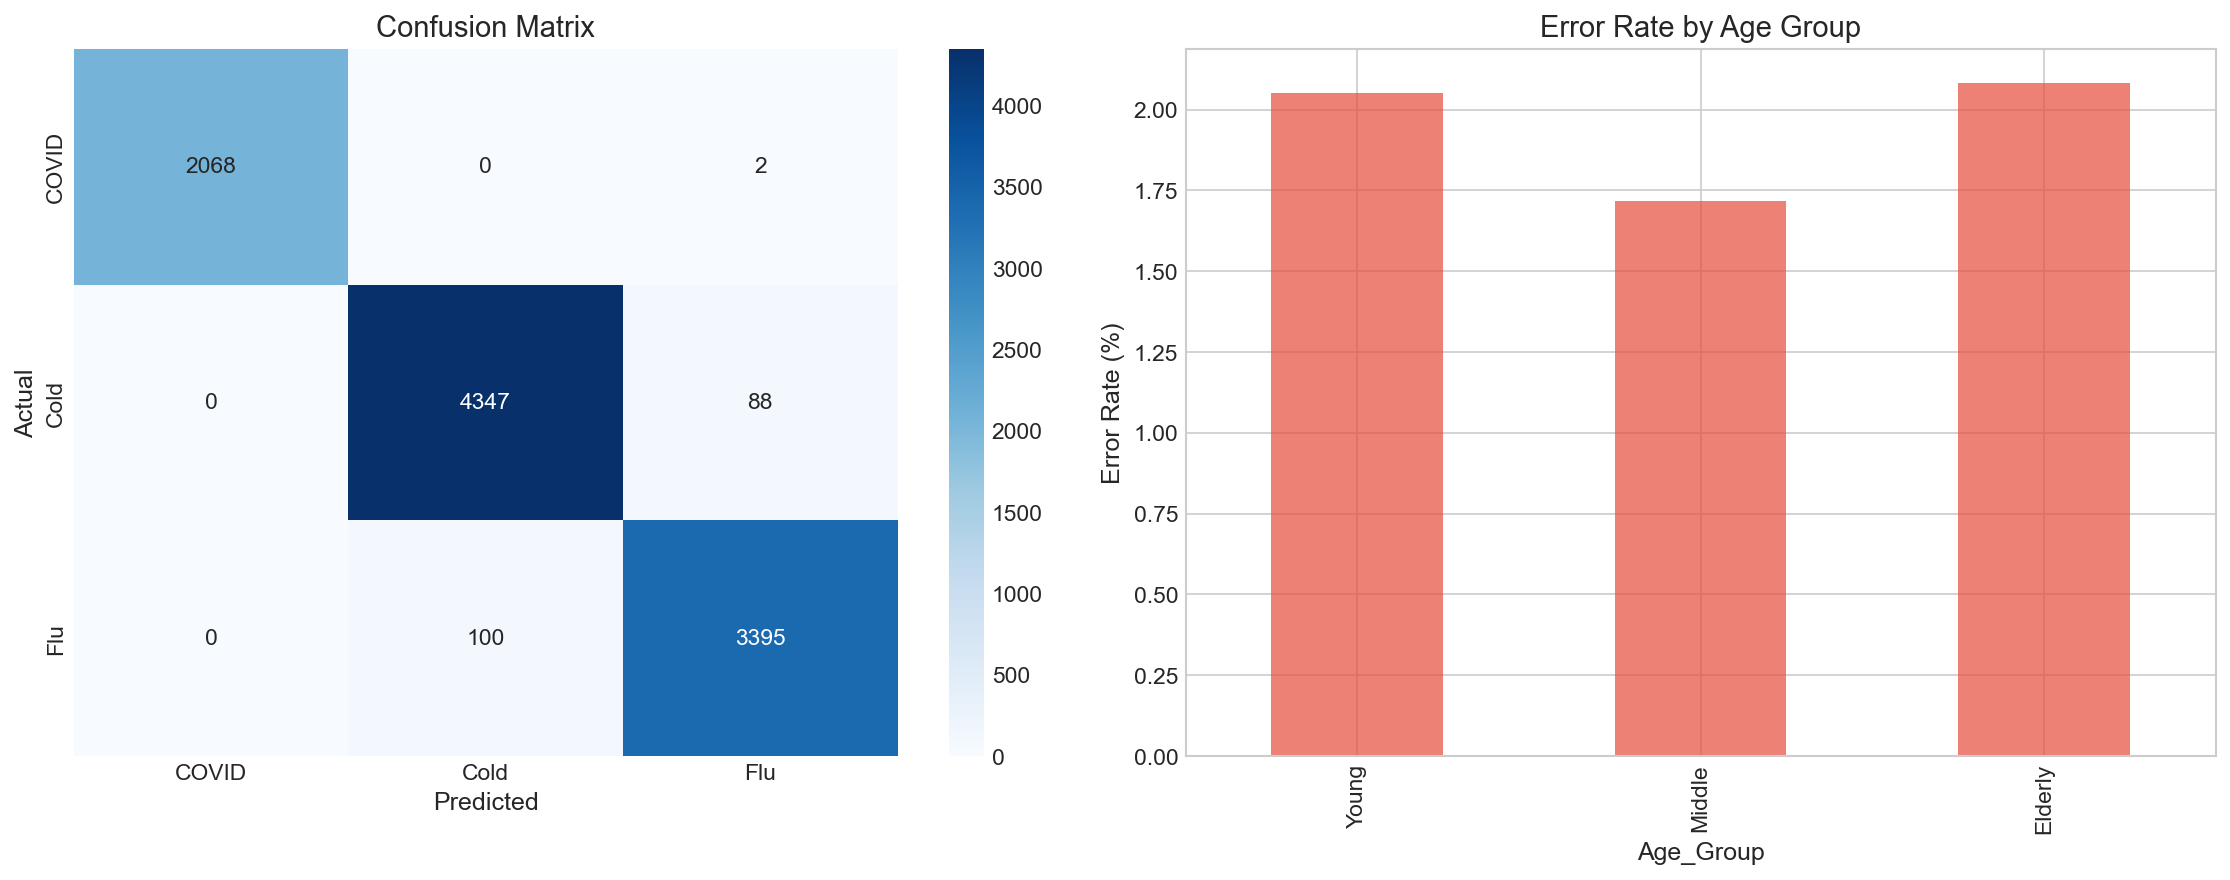

In [37]:
# ==========================================
# 6. ERROR ANALYSIS
# ==========================================

def analyze_errors(y_true, y_pred, X_test, label_encoder):
    cm = confusion_matrix(y_true, y_pred)
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, 
                yticklabels=label_encoder.classes_, ax=axes[0])
    axes[0].set_title('Confusion Matrix')
    axes[0].set_ylabel('Actual'); axes[0].set_xlabel('Predicted')
    
    # 2. Errors by Age
    errors = y_true != y_pred
    error_df = X_test.copy()
    error_df['is_error'] = errors
    
    # Bin ages
    error_df['Age_Group'] = pd.cut(error_df['age'], bins=[0, 40, 60, 100], labels=['Young', 'Middle', 'Elderly'])
    error_rates = error_df.groupby('Age_Group')['is_error'].mean() * 100
    
    error_rates.plot(kind='bar', color='#e74c3c', alpha=0.7, ax=axes[1])
    axes[1].set_title('Error Rate by Age Group')
    axes[1].set_ylabel('Error Rate (%)')
    
    plt.tight_layout()
    plt.show()

analyze_errors(y_test, y_pred, X_test, le_disease)

4.1.2 Logistic Regression (L1)

LOGISTIC REGRESSION (LASSO) - ENGINEERED FEATURES ANALYSIS
📊 Data Shape after encoding: (50000, 41)
✅ Logistic Regression (L1) Accuracy: 0.9860

📋 Classification Report:
              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00      2056
        Cold       0.98      0.98      0.98      4500
         Flu       0.98      0.98      0.98      3444

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000


🔍 L1 Feature Coefficients for COVID-19 Class:
(Positive = Risk Factor | Negative = Protective/Other Disease)
------------------------------------------------------------
Feature                        | Coefficient  | Impact    
------------------------------------------------------------
blood_nlr                      |     10.2363  | 🟥 RISK
symptom_anosmia                |      1.9159  | 🟥 RISK
blood_neutrophils              |      1.5374  | 

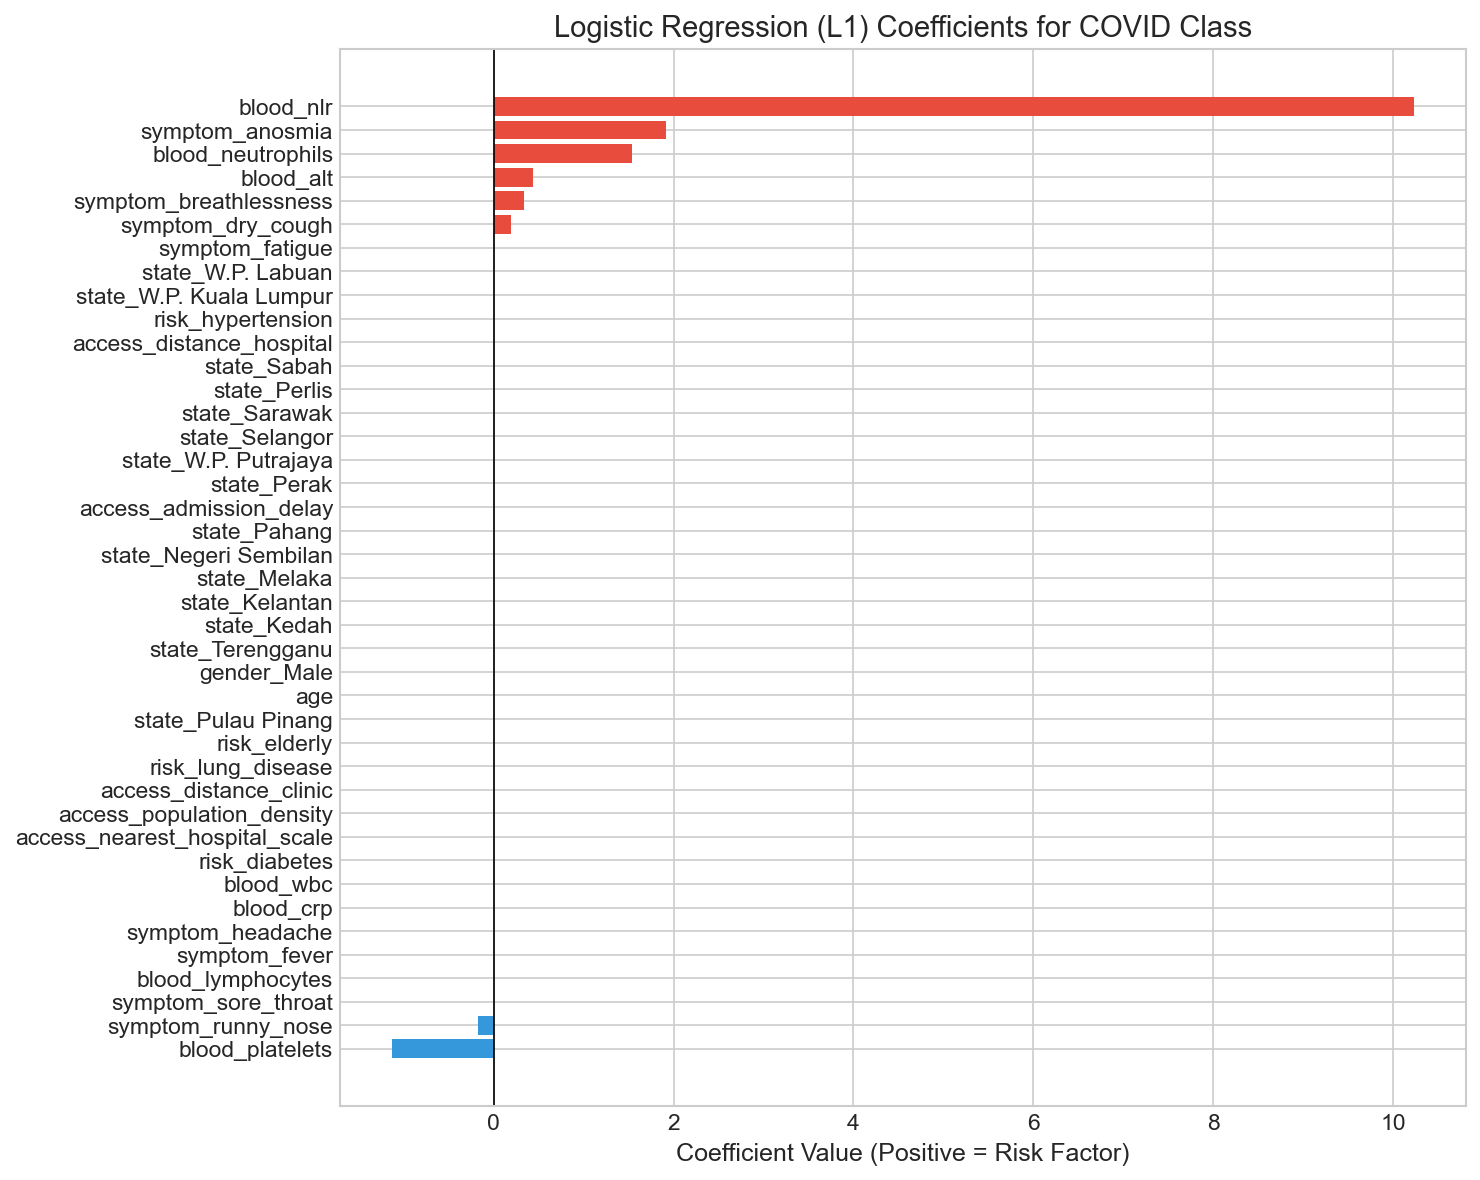

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

def run_logistic_l1_engineered(df, target_col='disease'):
    print("============================================================")
    print("LOGISTIC REGRESSION (LASSO) - ENGINEERED FEATURES ANALYSIS")
    print("============================================================")

    # 1. Separate Features and Target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # 2. Preprocessing
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_cols),
            ('cat', OneHotEncoder(drop='first'), categorical_cols) 
        ]
    )

    # 3. Transform Data
    X_processed = preprocessor.fit_transform(X)
    
    # Get feature names back
    feature_names_out = []
    feature_names_out.extend(numerical_cols)
    if len(categorical_cols) > 0:
        cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        feature_names_out.extend(cat_names)
    
    print(f"📊 Data Shape after encoding: {X_processed.shape}")
    
    # 4. Split
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

    # 5. Train L1 (Lasso)
    lr_model = LogisticRegression(
        penalty='l1', solver='saga', multi_class='multinomial', 
        max_iter=2000, class_weight='balanced', C=0.5, random_state=42
    )
    lr_model.fit(X_train, y_train)

    # 6. Generate Output
    y_pred = lr_model.predict(X_test)
    
    print(f"✅ Logistic Regression (L1) Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\n📋 Classification Report:")
    print(classification_report(y_test, y_pred))

    # 7. Extract Coefficients for COVID Class
    classes = lr_model.classes_
    try:
        # Find index for 'COVID' class
        covid_idx = np.where(classes == 'COVID')[0][0]
    except IndexError:
        print("⚠️ Error: 'COVID' class not found in target variable.")
        return

    covid_coefs = lr_model.coef_[covid_idx]
    
    # Create DataFrame for COVID coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names_out,
        'Coefficient': covid_coefs,
        'Abs_Coefficient': np.abs(covid_coefs)
    }).sort_values(by='Coefficient', ascending=False)

    print("\n🔍 L1 Feature Coefficients for COVID-19 Class:")
    print("(Positive = Risk Factor | Negative = Protective/Other Disease)")
    print("-" * 60)
    print(f"{'Feature':<30} | {'Coefficient':<12} | {'Impact':<10}")
    print("-" * 60)
    
    for index, row in coef_df.iterrows():
        impact = "🟥 RISK" if row['Coefficient'] > 0 else "🟦 LOW RISK"
        if abs(row['Coefficient']) < 0.05: impact = "⬜ NEUTRAL"
        print(f"{row['Feature']:<30} | {row['Coefficient']:>11.4f}  | {impact}")

    # 8. Plotting (FIXED SECTION)
    plt.figure(figsize=(10, 8))
    
    # Sort ascending for better horizontal bar chart visualization
    plot_df = coef_df.sort_values(by='Coefficient', ascending=True)
    
    colors = ['#e74c3c' if x > 0 else '#3498db' for x in plot_df['Coefficient']]
    
    plt.barh(plot_df['Feature'], plot_df['Coefficient'], color=colors)
    plt.axvline(0, color='black', linewidth=0.8)
    plt.title('Logistic Regression (L1) Coefficients for COVID Class')
    plt.xlabel('Coefficient Value (Positive = Risk Factor)')
    plt.tight_layout()
    plt.show()

# Run the function
run_logistic_l1_engineered(df)

In [ ]:
def run_logistic_l1(X, y, feature_names, label_encoder):
    # Standardize data (Critical for L1 regularization)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Train L1 (Lasso)
    lr_model = LogisticRegression(
        penalty='l1', solver='saga', multi_class='multinomial', 
        max_iter=2000, class_weight='balanced', random_state=42
    )
    lr_model.fit(X_train, y_train)
    
    # Get Coefficients
    coef_df = pd.DataFrame(
        lr_model.coef_.T,
        index=feature_names,
        columns=label_encoder.classes_
    )
    
    # Plot COVID specific coefficients
    if 'COVID' in coef_df.columns:
        plt.figure(figsize=(10, 6))
        covid_coefs = coef_df['COVID'].sort_values()
        colors = ['#e74c3c' if x > 0 else '#3498db' for x in covid_coefs]
        
        covid_coefs.plot(kind='barh', color=colors)
        plt.axvline(0, color='black', linewidth=0.8)
        plt.title('Logistic Regression (L1) Coefficients for COVID Class')
        plt.xlabel('Coefficient Value (Positive = Risk Factor)')
        plt.tight_layout()
        plt.show()
        
    print(f"Logistic Regression Accuracy in Predicting Disease: {lr_model.score(X_test, y_test):.4f}")

run_logistic_l1(X, y, feature_names, le_disease)

## 4.2 Clustering Analysis
- HDBSCAN (Medical Desert Identification)
- UMAP Dimensionality Reduction
- Combined Clustering (Demographics + Access)


In [ ]:
# ==========================================
# 1. SETUP & IMPORTS
# ==========================================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

# Dimensionality Reduction & Clustering
import umap.umap_ as umap
import hdbscan

# Configuration
DATA_DIR = "data"     # Update path as needed
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Styles
plt.style.use('seaborn-v0_8-whitegrid')

print("✅ Clustering environment setup complete.")

✅ Clustering environment setup complete.


In [ ]:
# ==========================================
# 2. DATA LOADING & PREPARATION
# ==========================================

def load_clustering_data():
    """Load and prepare data specifically for accessibility clustering."""
    
    # 1. Load Data
    csv_path = os.path.join(DATA_DIR, "rm19_dataset_full.csv")
    
    # Mock data generation if file missing (for demonstration)
    if not os.path.exists(csv_path):
        print("⚠️ File not found. Generating dummy accessibility data...")
        N = 2000
        data = {
            'access_distance_clinic': np.random.exponential(5, N),
            'access_distance_hospital': np.random.exponential(15, N),
            'access_nearest_hospital_scale': np.random.randint(1, 4, N),
            'access_population_density': np.random.uniform(100, 10000, N),
            'access_admission_delay': np.random.exponential(4, N),
            'age': np.random.randint(18, 90, N),
            'disease': np.random.choice(['COVID', 'Flu', 'Healthy'], N),
            # Mock risk factors
            'risk_diabetes': np.random.randint(0, 2, N),
            'risk_hypertension': np.random.randint(0, 2, N),
            'risk_elderly': np.random.randint(0, 2, N),
            'risk_lung_disease': np.random.randint(0, 2, N)
        }
        df = pd.DataFrame(data)
    else:
        df = pd.read_csv(csv_path)

    print(f"📊 Dataset Shape: {df.shape}")

    # 2. Select & Scale Accessibility Features
    access_cols = [
        'access_distance_clinic',
        'access_distance_hospital',
        'access_nearest_hospital_scale',
        'access_population_density',
        'access_admission_delay'
    ]
    
    X_access = df[access_cols].copy()
    
    # Standard Scaling (Crucial for distance-based clustering)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_access)
    
    return X_scaled, access_cols, df

# Execute Preparation
X_scaled, access_cols, df_full = load_clustering_data()
print(f"📍 Accessibility features prepared: {len(access_cols)} variables")

📊 Dataset Shape: (50000, 28)
📍 Accessibility features prepared: 5 variables


## 4.2.1 HDBSCAN

In [ ]:
# ==========================================
#                  HDBSCAN
# ==========================================

def run_hdbscan(X_scaled, df_orig):
    print("🔄 Running HDBSCAN...")
    
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=50,       # Minimum size to form a valid cluster
        min_samples=10,            # How conservative the clustering is
        metric='euclidean',
        cluster_selection_epsilon=0.5
    )
    
    labels = clusterer.fit_predict(X_scaled)
    
    # Attach labels
    df_clustered = df_orig.copy()
    df_clustered['cluster'] = labels
    
    # Stats
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_outliers = (labels == -1).sum()
    print(f"✅ Found {n_clusters} clusters")
    print(f"⚠️ Outliers (Potential Medical Deserts): {n_outliers} ({n_outliers/len(labels)*100:.1f}%)")
    
    return df_clustered, labels, clusterer

# Execute
df_clustered, cluster_labels, clusterer_clustered = run_hdbscan(X_scaled, df_full)

🔄 Running HDBSCAN...
✅ Found 23 clusters
⚠️ Outliers (Potential Medical Deserts): 259 (0.5%)


📍 Top Clusters by Medical Desert Score:
    Cluster  Size  Avg_Dist_Hospital  Avg_Pop_Density  Avg_Wait_Time  \
16       15   118           4.580508              1.0      14.189576   
15       14   290           4.462069              1.0      12.682483   
17       16   376           4.369681              1.0      11.223830   
20       19   102           4.348039              2.0      13.099706   
18       17   426           4.380282              1.0       9.747418   

    COVID_Rate  Desert_Score  
16   39.830508      0.950000  
15   38.965517      0.907794  
17   31.382979      0.868887  
20   38.235294      0.856657  
18   26.291080      0.838598  


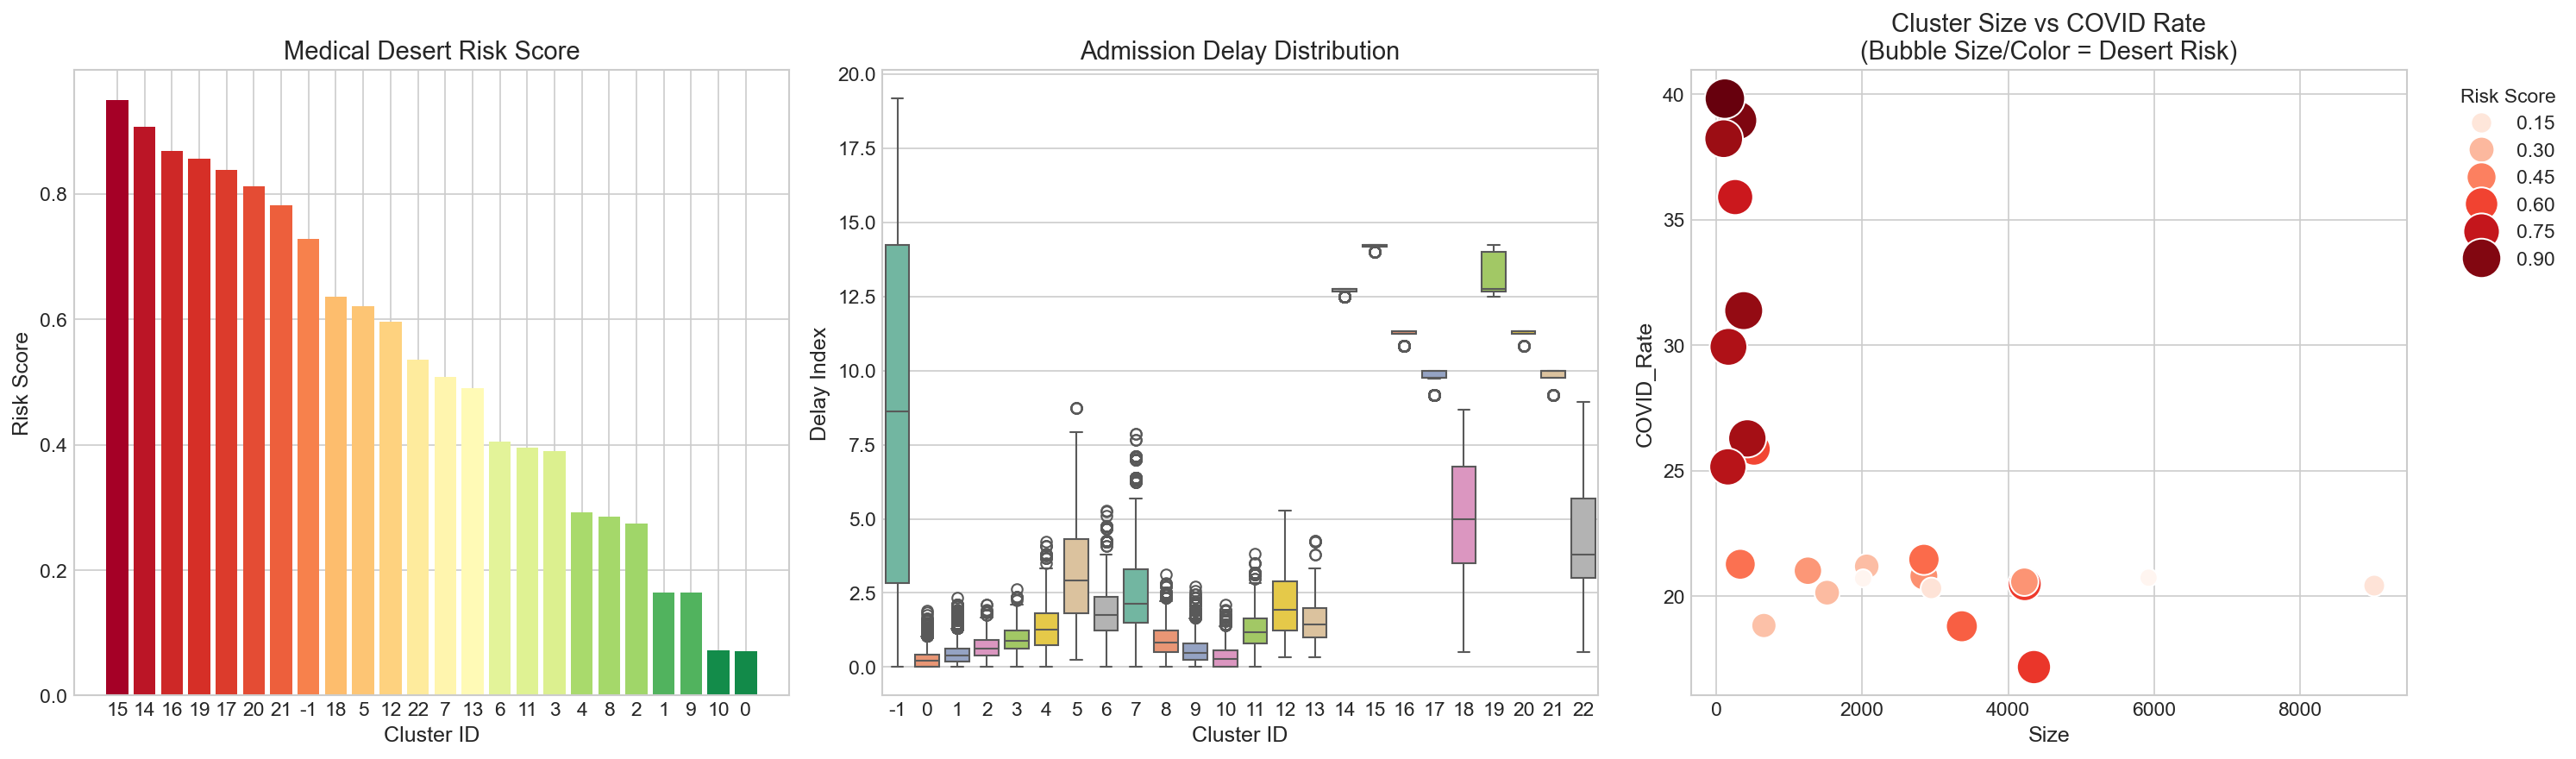

In [ ]:
# ==========================================
#    CLUSTER PROFILING & VISUALIZATION
# ==========================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def analyze_clusters(df_clustered):
    # 1. Generate Statistics
    stats = []
    unique_clusters = sorted(df_clustered['cluster'].unique())
    
    for cid in unique_clusters:
        subset = df_clustered[df_clustered['cluster'] == cid]
        stats.append({
            'Cluster': cid,
            'Size': len(subset),
            'Avg_Dist_Hospital': subset['access_distance_hospital'].mean(),
            'Avg_Pop_Density': subset['access_population_density'].mean(),
            'Avg_Wait_Time': subset['access_admission_delay'].mean(),
            'COVID_Rate': (subset['disease'] == 'COVID').mean() * 100
        })
        
    stats_df = pd.DataFrame(stats)
    
    # Calculate "Medical Desert Score" (Heuristic)
    # High Distance + Low Density + High Wait = High Score
    stats_df['Desert_Score'] = (
        (stats_df['Avg_Dist_Hospital'] / stats_df['Avg_Dist_Hospital'].max()) * 0.4 +
        (1 - stats_df['Avg_Pop_Density'] / stats_df['Avg_Pop_Density'].max()) * 0.3 + 
        (stats_df['Avg_Wait_Time'] / stats_df['Avg_Wait_Time'].max()) * 0.3
    )
    
    print("📍 Top Clusters by Medical Desert Score:")
    print(stats_df.sort_values('Desert_Score', ascending=False).head(5))

    # 2. Visualizations (3 Charts Side-by-Side)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Chart 1: Desert Score Bar Chart
    valid_stats = stats_df.sort_values('Desert_Score', ascending=False)
    # Color bar by score intensity (Red = Bad, Green = Good)
    colors = plt.cm.RdYlGn_r(valid_stats['Desert_Score'] / valid_stats['Desert_Score'].max())
    
    axes[0].bar(range(len(valid_stats)), valid_stats['Desert_Score'], color=colors)
    axes[0].set_xticks(range(len(valid_stats)))
    axes[0].set_xticklabels(valid_stats['Cluster'])
    axes[0].set_xlabel('Cluster ID')
    axes[0].set_ylabel('Risk Score')
    axes[0].set_title('Medical Desert Risk Score')
    
    # Chart 2: Boxplot of Wait Times
    sns.boxplot(data=df_clustered, x='cluster', y='access_admission_delay', ax=axes[1], palette='Set2')
    axes[1].set_title('Admission Delay Distribution')
    axes[1].set_xlabel('Cluster ID')
    axes[1].set_ylabel('Delay Index')
    
    # Chart 3: Cluster Size vs COVID Rate Bubble Plot
    # Size & Color of bubble = Desert Risk Score
    scatter = sns.scatterplot(
        data=stats_df, 
        x='Size', 
        y='COVID_Rate', 
        size='Desert_Score', 
        sizes=(100, 500), 
        hue='Desert_Score', 
        palette='Reds', 
        ax=axes[2]
    )
    axes[2].set_title('Cluster Size vs COVID Rate\n(Bubble Size/Color = Desert Risk)')
    axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Risk Score')
    
    plt.tight_layout()
    plt.show()
    
    return stats_df

# Execute
if 'df_clustered' in globals():
    cluster_stats = analyze_clusters(df_clustered)

## 4.2.2 HDBSCAN+UMAP with Accessibility Features

UMAP + HDBSCAN with Accessibility Features
🔄 Running HDBSCAN...
✅ Clustering Complete.


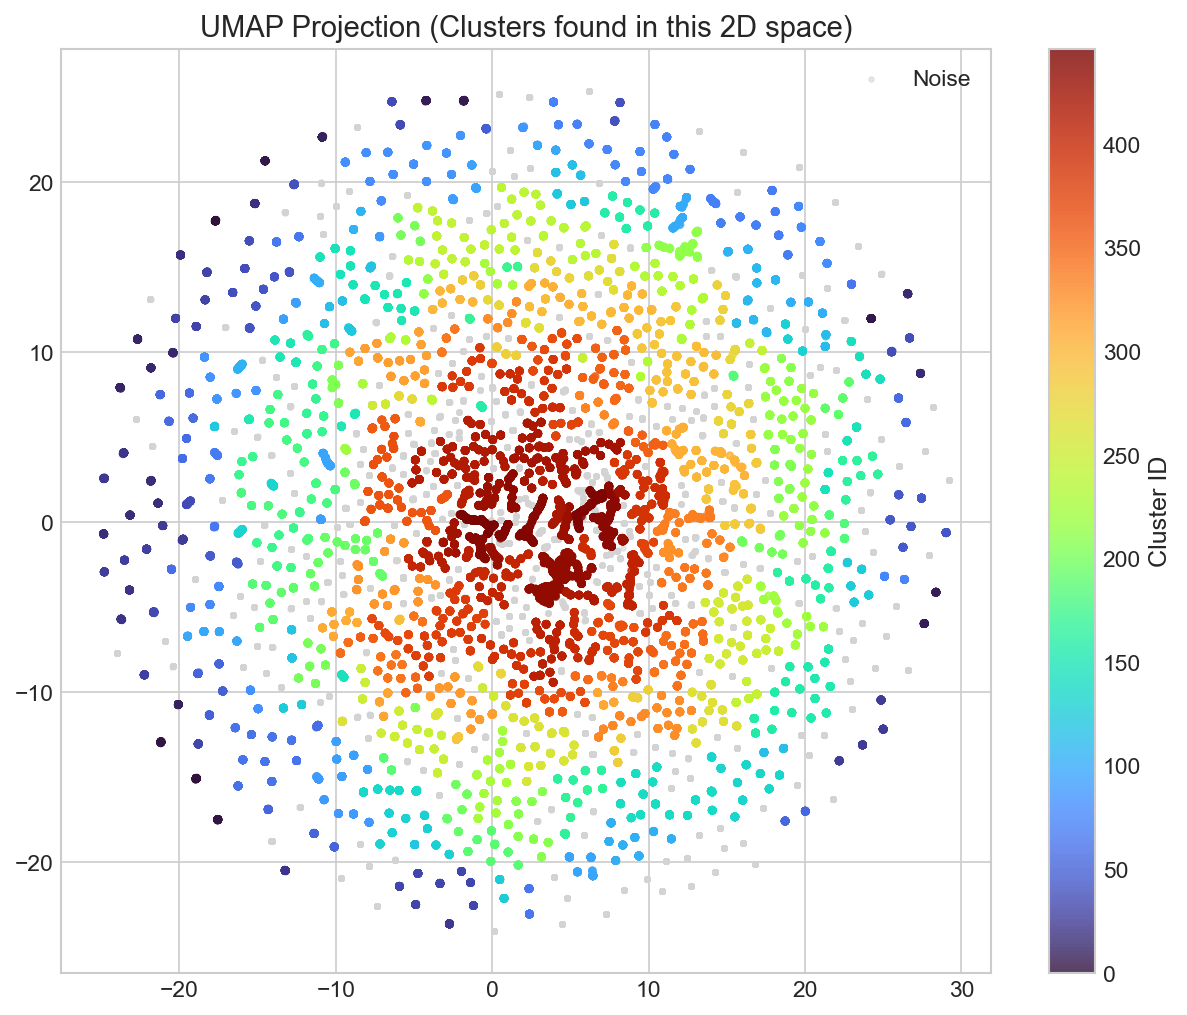

In [ ]:
# ==========================================
# HDBSCAN+UMAP with Accessibility Features
# ==========================================
import umap.umap_ as umap
import hdbscan

def compute_umap_clustering(X_input, df_orig):
    print("UMAP + HDBSCAN with Accessibility Features")
    
    # 1. UMAP Projection
    # n_jobs=1 ensures stability in Jupyter
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1)
    embedding = reducer.fit_transform(X_input)
    
    # 2. HDBSCAN Clustering
    print("🔄 Running HDBSCAN...")
    # storing prediction_data=True helps with some validation metrics
    clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10, prediction_data=True)
    labels = clusterer.fit_predict(embedding)
    
    # 3. Store Results
    df_result = df_orig.copy()
    df_result['cluster'] = labels
    df_result['umap_x'] = embedding[:, 0]
    df_result['umap_y'] = embedding[:, 1]
    
    print(f"✅ Clustering Complete.")
    return df_result, clusterer

# Execute
if 'X_scaled' in globals() and 'df_full' in globals():
    df_umap, clusterer_umap = compute_umap_clustering(X_scaled, df_full)

# ==========================================
# 5.2 VISUALIZATION
# ==========================================
import matplotlib.pyplot as plt

def plot_umap_results(df_data):
    plt.figure(figsize=(10, 8))
    
    # Plot Noise
    noise = df_data[df_data['cluster'] == -1]
    plt.scatter(noise['umap_x'], noise['umap_y'], c='lightgray', s=5, alpha=0.5, label='Noise')
    
    # Plot Clusters
    clustered = df_data[df_data['cluster'] != -1]
    scatter = plt.scatter(clustered['umap_x'], clustered['umap_y'], 
                          c=clustered['cluster'], cmap='turbo', s=10, alpha=0.8)
    
    plt.colorbar(scatter, label='Cluster ID')
    plt.title('UMAP Projection (Clusters found in this 2D space)')
    plt.legend()
    plt.show()

if 'df_umap' in globals():
    plot_umap_results(df_umap)

Post Processing on HDBSCAN+UMAP with Accessibility Features to retrieve insights

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def post_process_umap_insights(df_umap):
    print("\n" + "="*60)
    print("UMAP CLUSTER PROFILING & INSIGHT GENERATION")
    print("="*60)
    
    # 1. PROFILE: Compare Clusters on Original Features
    # We ignore the UMAP_X/Y columns and look at the real data (Distance, Density, Delay)
    feature_cols = ['access_distance_hospital', 'access_population_density', 'access_admission_delay']
    
    # Group by Cluster and calculate the Mean of each feature
    cluster_profile = df_umap.groupby('cluster')[feature_cols].mean()
    
    # Add Cluster Size
    cluster_profile['Count'] = df_umap['cluster'].value_counts()
    
    # Sort by "Medical Desert Risk" (Distance + Delay - Density)
    # This helps order the heatmap from "Urban/Good" to "Rural/Bad"
    # Note: Normalizing roughly for sorting purposes
    sort_score = (
        cluster_profile['access_distance_hospital'] + 
        cluster_profile['access_admission_delay'] - 
        cluster_profile['access_population_density']
    )
    cluster_profile = cluster_profile.loc[sort_score.sort_values(ascending=False).index]

    print("\n📊 Cluster Feature Profile (Mean Values):")
    print(cluster_profile)

    # 2. INSIGHT: State Fingerprinting
    # Which states dominate which clusters?
    if 'state' in df_umap.columns:
        print("\n🗺️  State Distribution per Cluster (Top State):")
        
        state_breakdown = df_umap.groupby(['cluster', 'state']).size().unstack(fill_value=0)
        
        # Normalize to percentages
        state_pct = state_breakdown.div(state_breakdown.sum(axis=1), axis=0) * 100
        
        # Find dominant state for each cluster
        dominant_states = pd.DataFrame({
            'Dominant_State': state_pct.idxmax(axis=1),
            'Percentage': state_pct.max(axis=1).round(1)
        })
        
        # Merge with profile stats for context
        final_view = dominant_states.join(cluster_profile[['Count', 'access_distance_hospital']])
        print(final_view.sort_values('Count', ascending=False))
        
        return cluster_profile, final_view
    
    return cluster_profile, None

# Execute
if 'df_umap' in globals():
    profile_stats, state_stats = post_process_umap_insights(df_umap)


UMAP CLUSTER PROFILING & INSIGHT GENERATION

📊 Cluster Feature Profile (Mean Values):
         access_distance_hospital  access_population_density  \
cluster                                                        
212                      4.584135                   1.418269   
75                       4.819767                   1.000000   
72                       4.225000                   1.000000   
101                      4.437500                   1.737500   
232                      5.000000                   1.000000   
...                           ...                        ...   
106                      0.000000                   6.000000   
131                      0.000000                   6.000000   
91                       0.000000                   6.000000   
97                       0.000000                   6.000000   
9                        0.000000                   6.000000   

         access_admission_delay  Count  
cluster                                

## 4.2.3 UMAP + HDBSCAN For Accessibility + Comorbidity + Demographics Features


UMAP + HDBSCAN For Accessibility + Cmorbidity + Demographics Features
🔄 Running UMAP Projection...
🔄 Running HDBSCAN...

📍 Top Vulnerable Clusters Summary:
                        age  access_distance_hospital  vulnerability_score  \
combined_cluster                                                             
41                58.341463                  3.000000                  1.0   
362               64.621951                  3.500000                  1.0   
363               63.260274                  3.727740                  1.0   
38                64.648649                  3.500000                  1.0   
39                70.525424                  4.398305                  1.0   

                  covid_rate  
combined_cluster              
41                  0.256098  
362                 0.182927  
363                 0.260274  
38                  0.216216  
39                  0.305085  


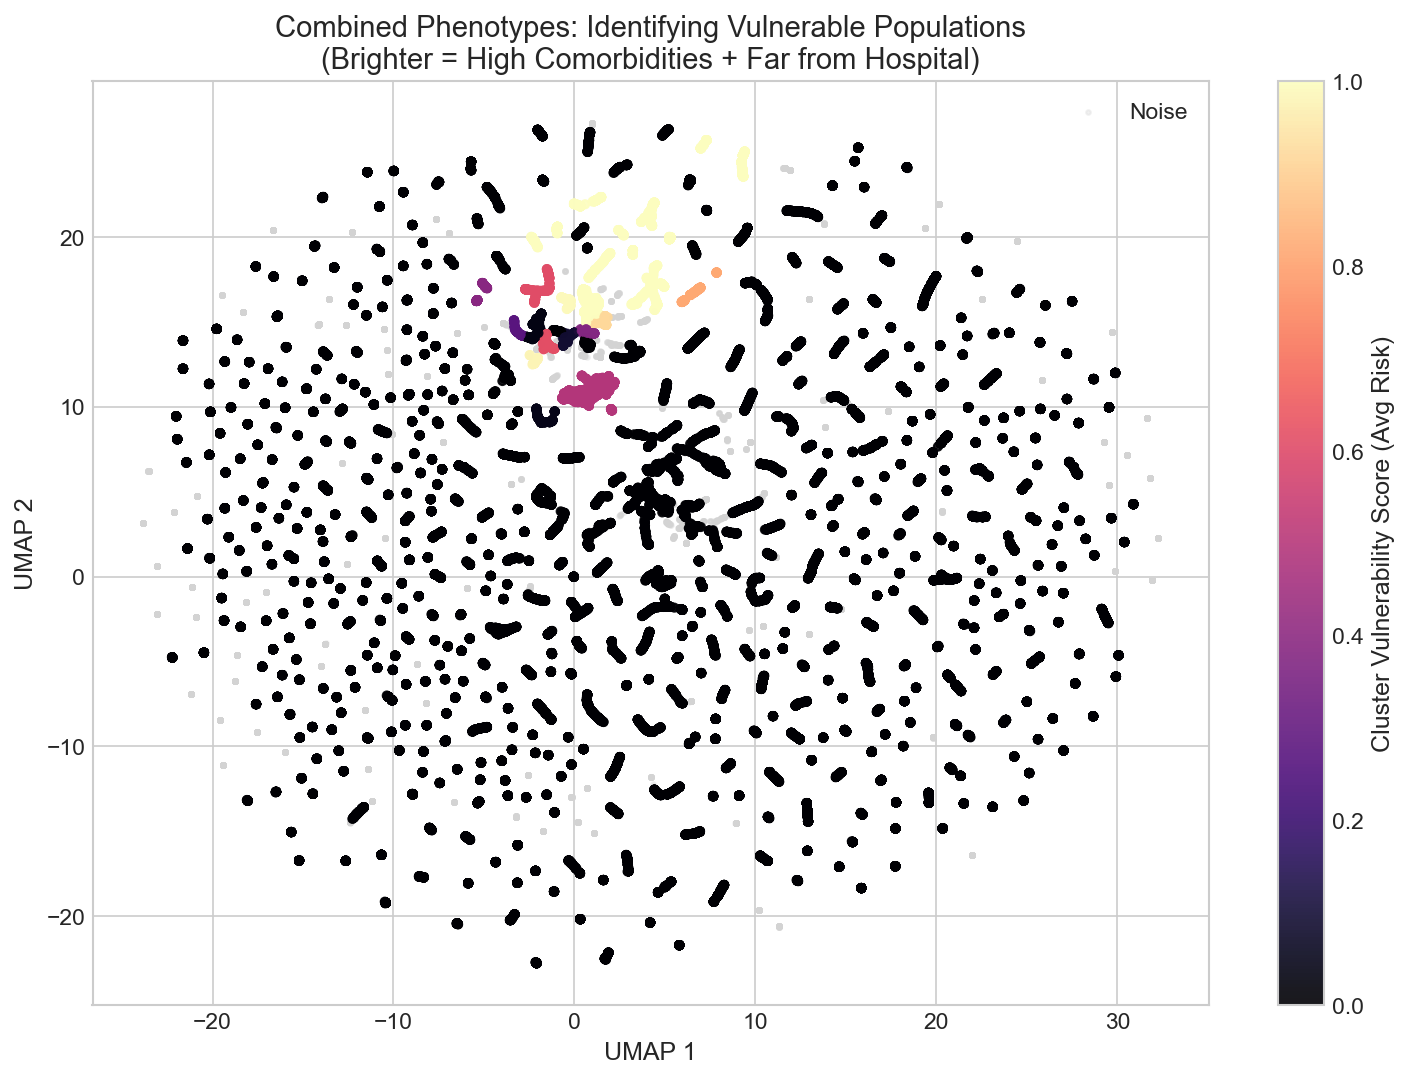

In [ ]:

import umap.umap_ as umap
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def run_combined_analysis(df_full):
    print("\n" + "="*70)
    print("UMAP + HDBSCAN For Accessibility + Comorbidity + Demographics Features")
    print("="*70)

    # Work on a copy to avoid SettingWithCopy warnings on the original df
    df_results = df_full.copy()

    # 1. Feature Engineering
    # Calculate Comorbidity Index if missing
    if 'comorbidity_index' not in df_results.columns:
        risk_cols = ['risk_diabetes', 'risk_hypertension', 'risk_elderly', 'risk_lung_disease']
        # Check which columns exist
        available = [c for c in risk_cols if c in df_results.columns]
        df_results['comorbidity_index'] = df_results[available].sum(axis=1) if available else 0
        
    # Select features mixing Health (Age, Risk) and Logistics (Distance, Density)
    mixed_cols = ['age', 'comorbidity_index', 'access_distance_hospital', 'access_population_density']
    # 2. Scaling & UMAP
    X_mixed = StandardScaler().fit_transform(df_results[mixed_cols])
    
    print("🔄 Running UMAP Projection...")
    # n_jobs=1 prevents threading crashes
    reducer = umap.UMAP(n_neighbors=20, min_dist=0.0, n_components=2, random_state=42, n_jobs=1)
    embedding = reducer.fit_transform(X_mixed)
    
    # 3. Clustering
    print("🔄 Running HDBSCAN...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=60, min_samples=10)
    labels = clusterer.fit_predict(embedding)
    
    df_results['combined_cluster'] = labels
    df_results['umap_x'] = embedding[:, 0]
    df_results['umap_y'] = embedding[:, 1]

    
    # 4. Identify Vulnerability (The Base Metric)
    # Rule: High Comorbidity (>=2) AND High Distance (> Median)
    median_dist = df_results['access_distance_hospital'].median()
    df_results['Is_Vulnerable'] = ((df_results['comorbidity_index'] >= 2) & 
                                   (df_results['access_distance_hospital'] > median_dist)).astype(int)
    
    # 5. Profile Clusters (The Aggregation)
    summary = df_results.groupby('combined_cluster').agg({
        'age': 'mean',
        'access_distance_hospital': 'mean',
        'Is_Vulnerable': 'mean', # This becomes the score (0.0 to 1.0)
        'disease': lambda x: (x == 'COVID').mean() # Adjust string if needed
    }).rename(columns={'disease': 'covid_rate', 'Is_Vulnerable': 'vulnerability_score'})
    
    print("\n📍 Top Vulnerable Clusters Summary:")
    print(summary.sort_values('vulnerability_score', ascending=False).head())
    
    # 6. Map Score Back (The "Gradient" Fix)
    vulnerability_map = summary['vulnerability_score'].to_dict()
    df_results['cluster_vulnerability_score'] = df_results['combined_cluster'].map(vulnerability_map)

    # 7. Visualization
    plt.figure(figsize=(12, 8))
    
    # Plot Noise as faint grey
    noise = df_results[df_results['combined_cluster'] == -1]
    plt.scatter(noise['umap_x'], noise['umap_y'], c='lightgrey', s=5, alpha=0.3, label='Noise')
    
    # Plot Clusters with Gradient Color
    clustered = df_results[df_results['combined_cluster'] != -1]
    scatter = plt.scatter(clustered['umap_x'], clustered['umap_y'], 
                          c=clustered['cluster_vulnerability_score'], 
                          cmap='magma', # Magma/Inferno are great for heatmaps
                          s=15, alpha=0.9)
    
    plt.colorbar(scatter, label='Cluster Vulnerability Score (Avg Risk)')
    plt.title('Combined Phenotypes: Identifying Vulnerable Populations\n(Brighter = High Comorbidities + Far from Hospital)')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.legend()
    plt.show()

    return df_results, X_mixed, clusterer
    

# Run it
if 'df_full' in globals():
    df_complete, X_mixed, clusterer_complete = run_combined_analysis(df_full)

## 4.3 Hybrid Analysis
Overlaying COVID risk predictions onto accessibility clusters.


## 4.3.1 Hybrid Overlay on Normal HDBSCAN


Hybrid Overlay on Normal HDBSCAN
✅ Target Class for Risk: 'COVID' (Index 0)
🔄 Analyzing state demographics per cluster...

📊 Cluster Risk Profile (Sorted by Risk):
         Predicted_COVID_Prob  access_admission_delay  access_distance_hospital  access_population_density  True_COVID_Rate  Cluster_Size    Status             Top 1 State                Top 2 State              Top 3 State
cluster                                                                                                                                                                                                                        
 15                  0.398320               14.189576                  4.580508                   1.000000         0.398305           118  CRITICAL         Sarawak (41.5%)             Pahang (34.7%)            Sabah (23.7%)
 14                  0.389635               12.682483                  4.462069                   1.000000         0.389655           290  CRITICAL         Sarawak

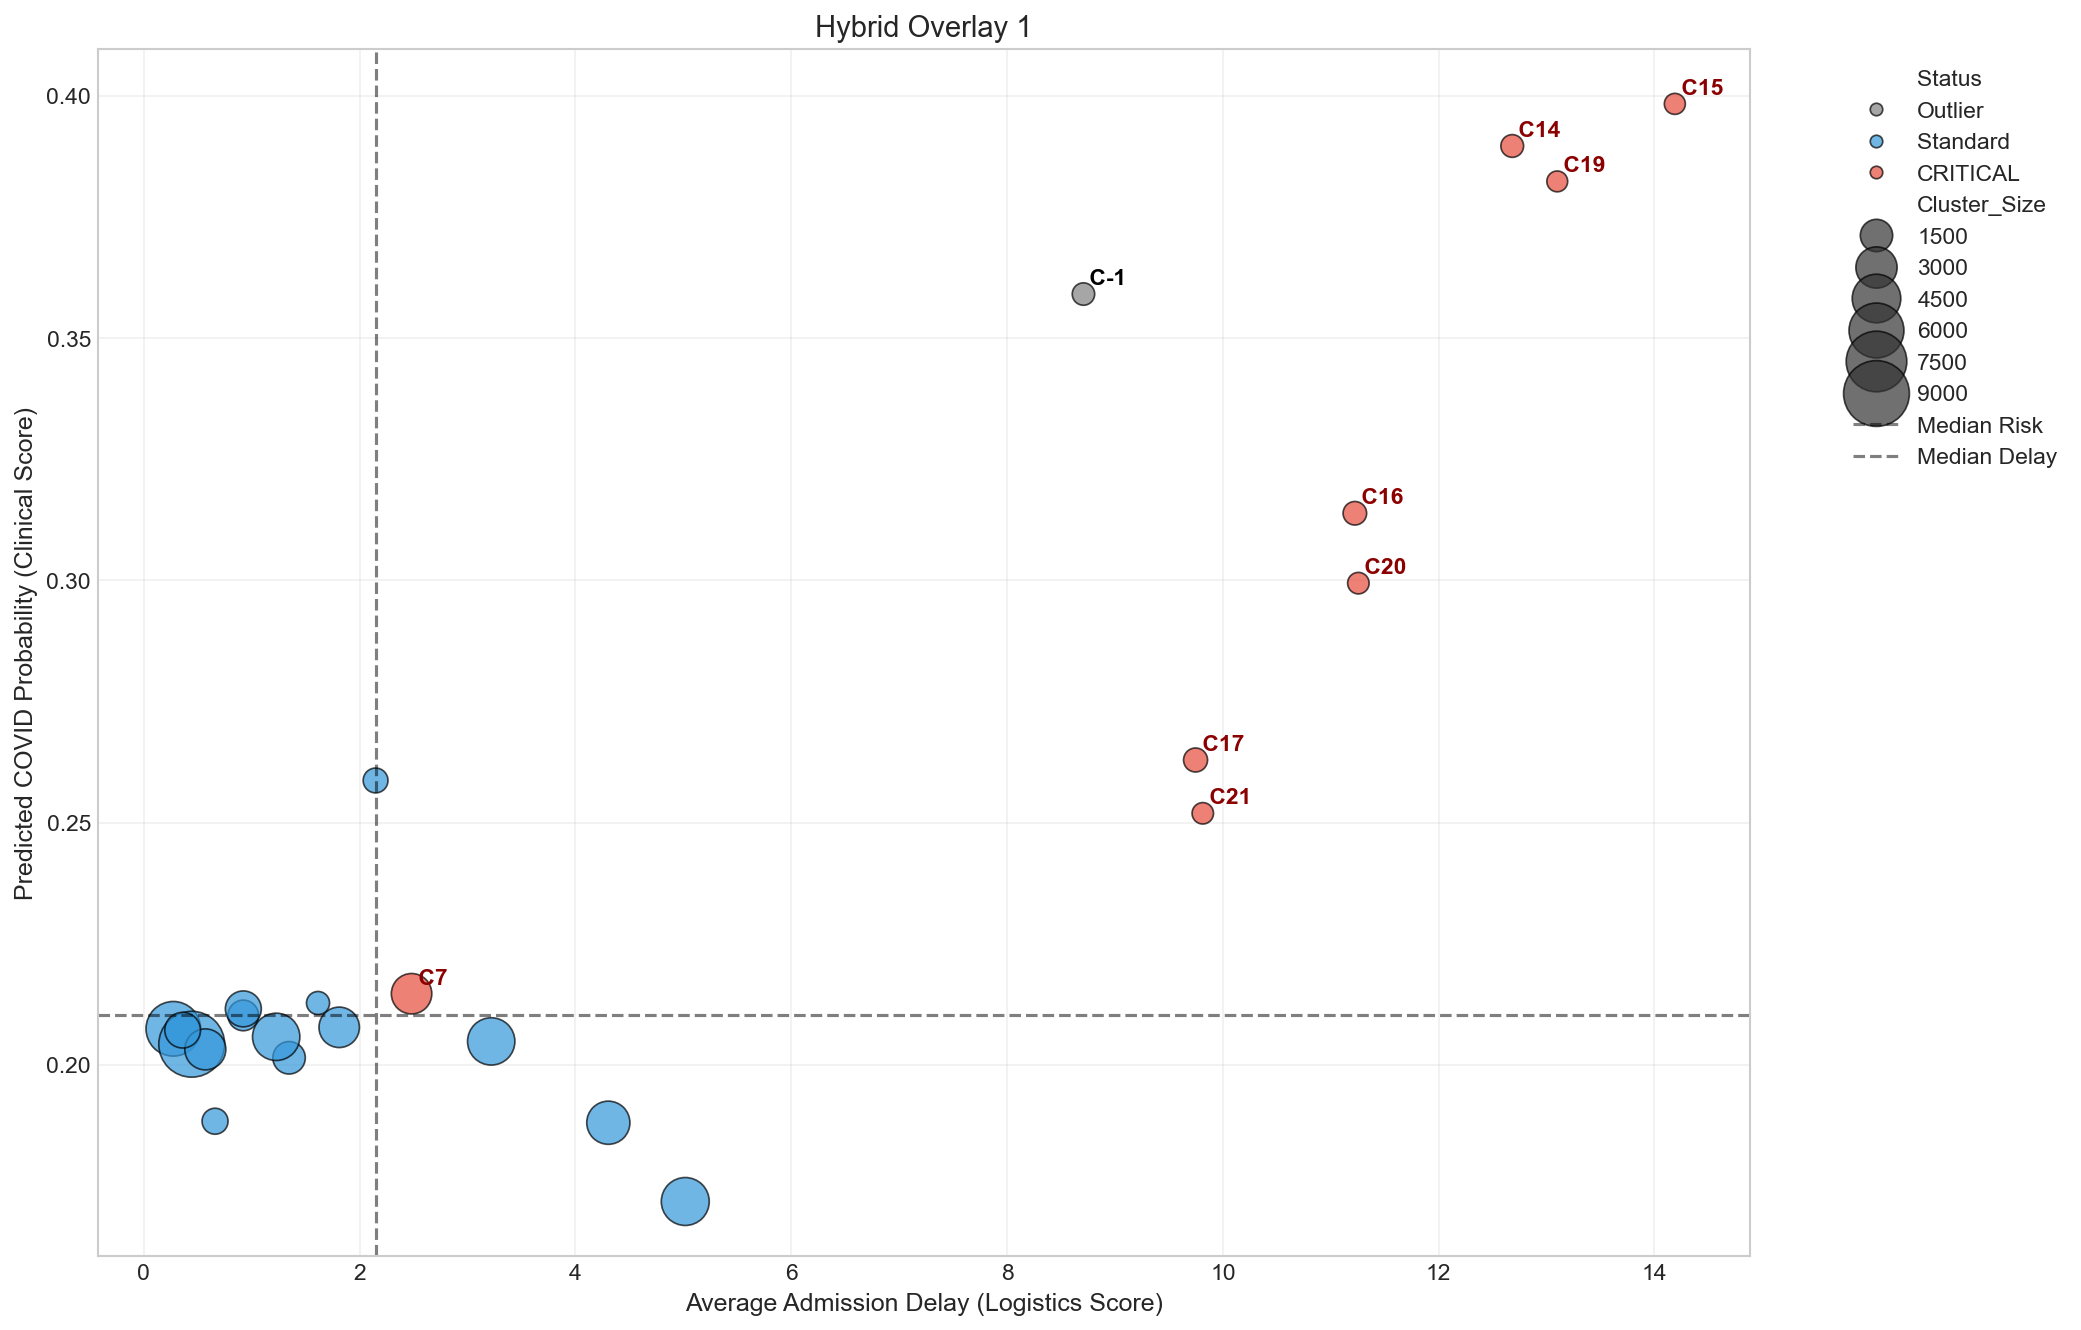

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ============================================================================
#                   Hybrid Overlay on Normal HDBSCAN
# ============================================================================

def run_hybrid_overlay(df_clustered, classifier, label_encoder, feature_names, df_original=None):
    print("\n" + "="*60)
    print("Hybrid Overlay on Normal HDBSCAN")
    print("="*60)

    # 1. Prepare Data & Merge State Info
    df_pred = df_clustered.copy()
    
    # Merge State Information
    if 'state' in df_pred.columns:
        pass 
    elif df_original is not None:
        # Pull state from original dataframe using index alignment
        df_pred['state'] = df_original.loc[df_pred.index, 'state']
    else:
        df_pred['state'] = "Unknown" 

    # Feature Engineering (Robust Checks)
    if 'comorbidity_index' not in df_pred.columns:
        risk_cols = ['risk_diabetes', 'risk_hypertension', 'risk_elderly', 'risk_lung_disease']
        available_risk = [c for c in risk_cols if c in df_pred.columns]
        df_pred['comorbidity_index'] = df_pred[available_risk].sum(axis=1) if available_risk else 0

    if 'gender_encoded' not in df_pred.columns:
        df_pred['gender_encoded'] = df_pred['gender'].apply(lambda x: 1 if str(x).lower().startswith('m') else 0) if 'gender' in df_pred.columns else 0

    # Select Features for Prediction
    X_pred = pd.DataFrame()
    for col in feature_names:
        X_pred[col] = df_pred[col] if col in df_pred.columns else 0
    X_pred = X_pred[feature_names]

    # 2. Predict Probability & Identify Labels
    classes = list(label_encoder.classes_)
    covid_idx = 0
    
    # Robustly find 'COVID' index
    if 'COVID' in classes:
        covid_idx = classes.index('COVID')
    elif any('covid' in str(c).lower() for c in classes):
        covid_idx = next(i for i, c in enumerate(classes) if 'covid' in str(c).lower())
    
    # --- FIX: Define covid_label based on the index found ---
    covid_label = classes[covid_idx]
    print(f"✅ Target Class for Risk: '{covid_label}' (Index {covid_idx})")

    # Predict
    probs = classifier.predict_proba(X_pred)
    df_pred['Predicted_COVID_Prob'] = probs[:, covid_idx]

    # Create Binary Column for Aggregation (Fixes the Mean calculation on Strings)
    df_pred['is_covid_binary'] = (df_pred['disease'] == covid_label).astype(int)

    # 3. Aggregate Numeric Stats by Cluster
    hybrid_stats = df_pred.groupby('cluster').agg({
        'Predicted_COVID_Prob': 'mean',
        'access_admission_delay': 'mean',
        'access_distance_hospital': 'mean',
        'access_population_density': 'mean',
        'is_covid_binary': 'mean', # Rate of true covid cases
        'disease': 'count'         # Cluster size
    })
    
    # Rename columns
    hybrid_stats.columns = [
        'Predicted_COVID_Prob', 'access_admission_delay', 
        'access_distance_hospital', 'access_population_density', 
        'True_COVID_Rate', 'Cluster_Size'
    ]
    
    # 4. Identify Critical Clusters
    valid_stats = hybrid_stats[hybrid_stats.index != -1]
    median_prob = valid_stats['Predicted_COVID_Prob'].median()
    median_delay = valid_stats['access_admission_delay'].median()
    
    def get_status(idx, row):
        if idx == -1: return 'Outlier'
        if (row['Predicted_COVID_Prob'] > median_prob) and (row['access_admission_delay'] > median_delay):
            return 'CRITICAL'
        return 'Standard'
    
    hybrid_stats['Status'] = [get_status(idx, row) for idx, row in hybrid_stats.iterrows()]

    # --- NEW: Calculate Top States per Cluster ---
    def get_top_states(group):
        if 'state' not in group.columns or group['state'].isnull().all():
            return pd.Series({'Top 1 State': '-', 'Top 2 State': '-', 'Top 3 State': '-'})
            
        counts = group['state'].value_counts(normalize=True) * 100
        top = counts.head(3)
        
        return pd.Series({
            'Top 1 State': f"{top.index[0]} ({top.iloc[0]:.1f}%)" if len(top) > 0 else "-",
            'Top 2 State': f"{top.index[1]} ({top.iloc[1]:.1f}%)" if len(top) > 1 else "-",
            'Top 3 State': f"{top.index[2]} ({top.iloc[2]:.1f}%)" if len(top) > 2 else "-"
        })

    # Apply state analysis
    print("🔄 Analyzing state demographics per cluster...")
    state_info = df_pred.groupby('cluster').apply(get_top_states)
    
    # Join State Info to Main Stats
    hybrid_stats = hybrid_stats.join(state_info)

    # 5. Output Table
    print("\n📊 Cluster Risk Profile (Sorted by Risk):")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(hybrid_stats.sort_values('Predicted_COVID_Prob', ascending=False))
    
    print(f"\n🔍 Thresholds :: Risk > {median_prob:.3f} | Delay > {median_delay:.3f}")
    
    critical_clusters = hybrid_stats[hybrid_stats['Status'] == 'CRITICAL'].index.tolist()
    if critical_clusters:
        print(f"🚨 ALERT: Clusters {critical_clusters} are CRITICAL PRIORITIES.")

    # 6. Visualization
    plt.figure(figsize=(14, 9))
    palette = {'CRITICAL': '#e74c3c', 'Standard': '#3498db', 'Outlier': 'grey'}
    
    sns.scatterplot(
        data=hybrid_stats,
        x='access_admission_delay',
        y='Predicted_COVID_Prob',
        size='Cluster_Size',
        sizes=(100, 1000), 
        hue='Status',
        palette=palette,
        alpha=0.7,
        edgecolor='black'
    )
    
    plt.axhline(y=median_prob, color='black', linestyle='--', alpha=0.5, label='Median Risk')
    plt.axvline(x=median_delay, color='black', linestyle='--', alpha=0.5, label='Median Delay')
    
    for idx, row in hybrid_stats.iterrows():
        if row['Status'] in ['CRITICAL', 'Outlier']:
            plt.text(
                row['access_admission_delay'], 
                row['Predicted_COVID_Prob'] + 0.002, 
                f" C{idx}", 
                fontsize=11, fontweight='bold', 
                color='darkred' if row['Status'] == 'CRITICAL' else 'black'
            )

    plt.title('Hybrid Overlay 1', fontsize=14)
    plt.xlabel('Average Admission Delay (Logistics Score)', fontsize=12)
    plt.ylabel('Predicted COVID Probability (Clinical Score)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return df_pred, hybrid_stats

# ============================================================================
# EXECUTION BLOCK
# ============================================================================

# Define model variable (handling naming variations)
model_var = globals().get('xgb_model', globals().get('model_xgb', None))

# Ensure df_full exists for state lookup
df_original_ref = globals().get('df_full', None) 
if df_original_ref is None:
    print("⚠️ 'df_full' not found. Attempting to reload for state info...")
    try:
        df_original_ref = pd.read_csv("Data/rm19_dataset_full.csv")
        print("✅ Loaded df_full from disk.")
    except:
        print("❌ Could not load original data. State info may be missing.")

if model_var is not None and 'df_clustered' in globals():
    df_hybrid, stats_hybrid = run_hybrid_overlay(
        df_clustered, 
        model_var, 
        le_disease, 
        feature_names,
        df_original=df_original_ref
    )
else:
    print("⚠️ MISSING DEPENDENCIES. Please run Task 4.1 (XGBoost) and 4.2 (Clustering) first.")

## 4.3.2 Hybrid Overlay on HDBSCAN + UMAP


Hybrid Overlay on HDBSCAN + UMAP
✅ Target Class for Risk: 'COVID' (Index 0)
🔄 Analyzing state demographics per UMAP cluster...

📊 Cluster Risk Profile (Sorted by Risk):
         Predicted_COVID_Prob  access_admission_delay  access_distance_hospital  access_population_density  True_COVID_Rate  Cluster_Size    Status              Top 1 State              Top 2 State           Top 3 State
cluster                                                                                                                                                                                                                    
212                  0.471143               14.583654                  4.584135                   1.418269         0.471154           208  CRITICAL          Sarawak (26.9%)       Terengganu (26.0%)        Pahang (21.2%)
15                   0.431332                5.903725                  4.000000                   1.000000         0.431373            51  CRITICAL           Pahang (37.3

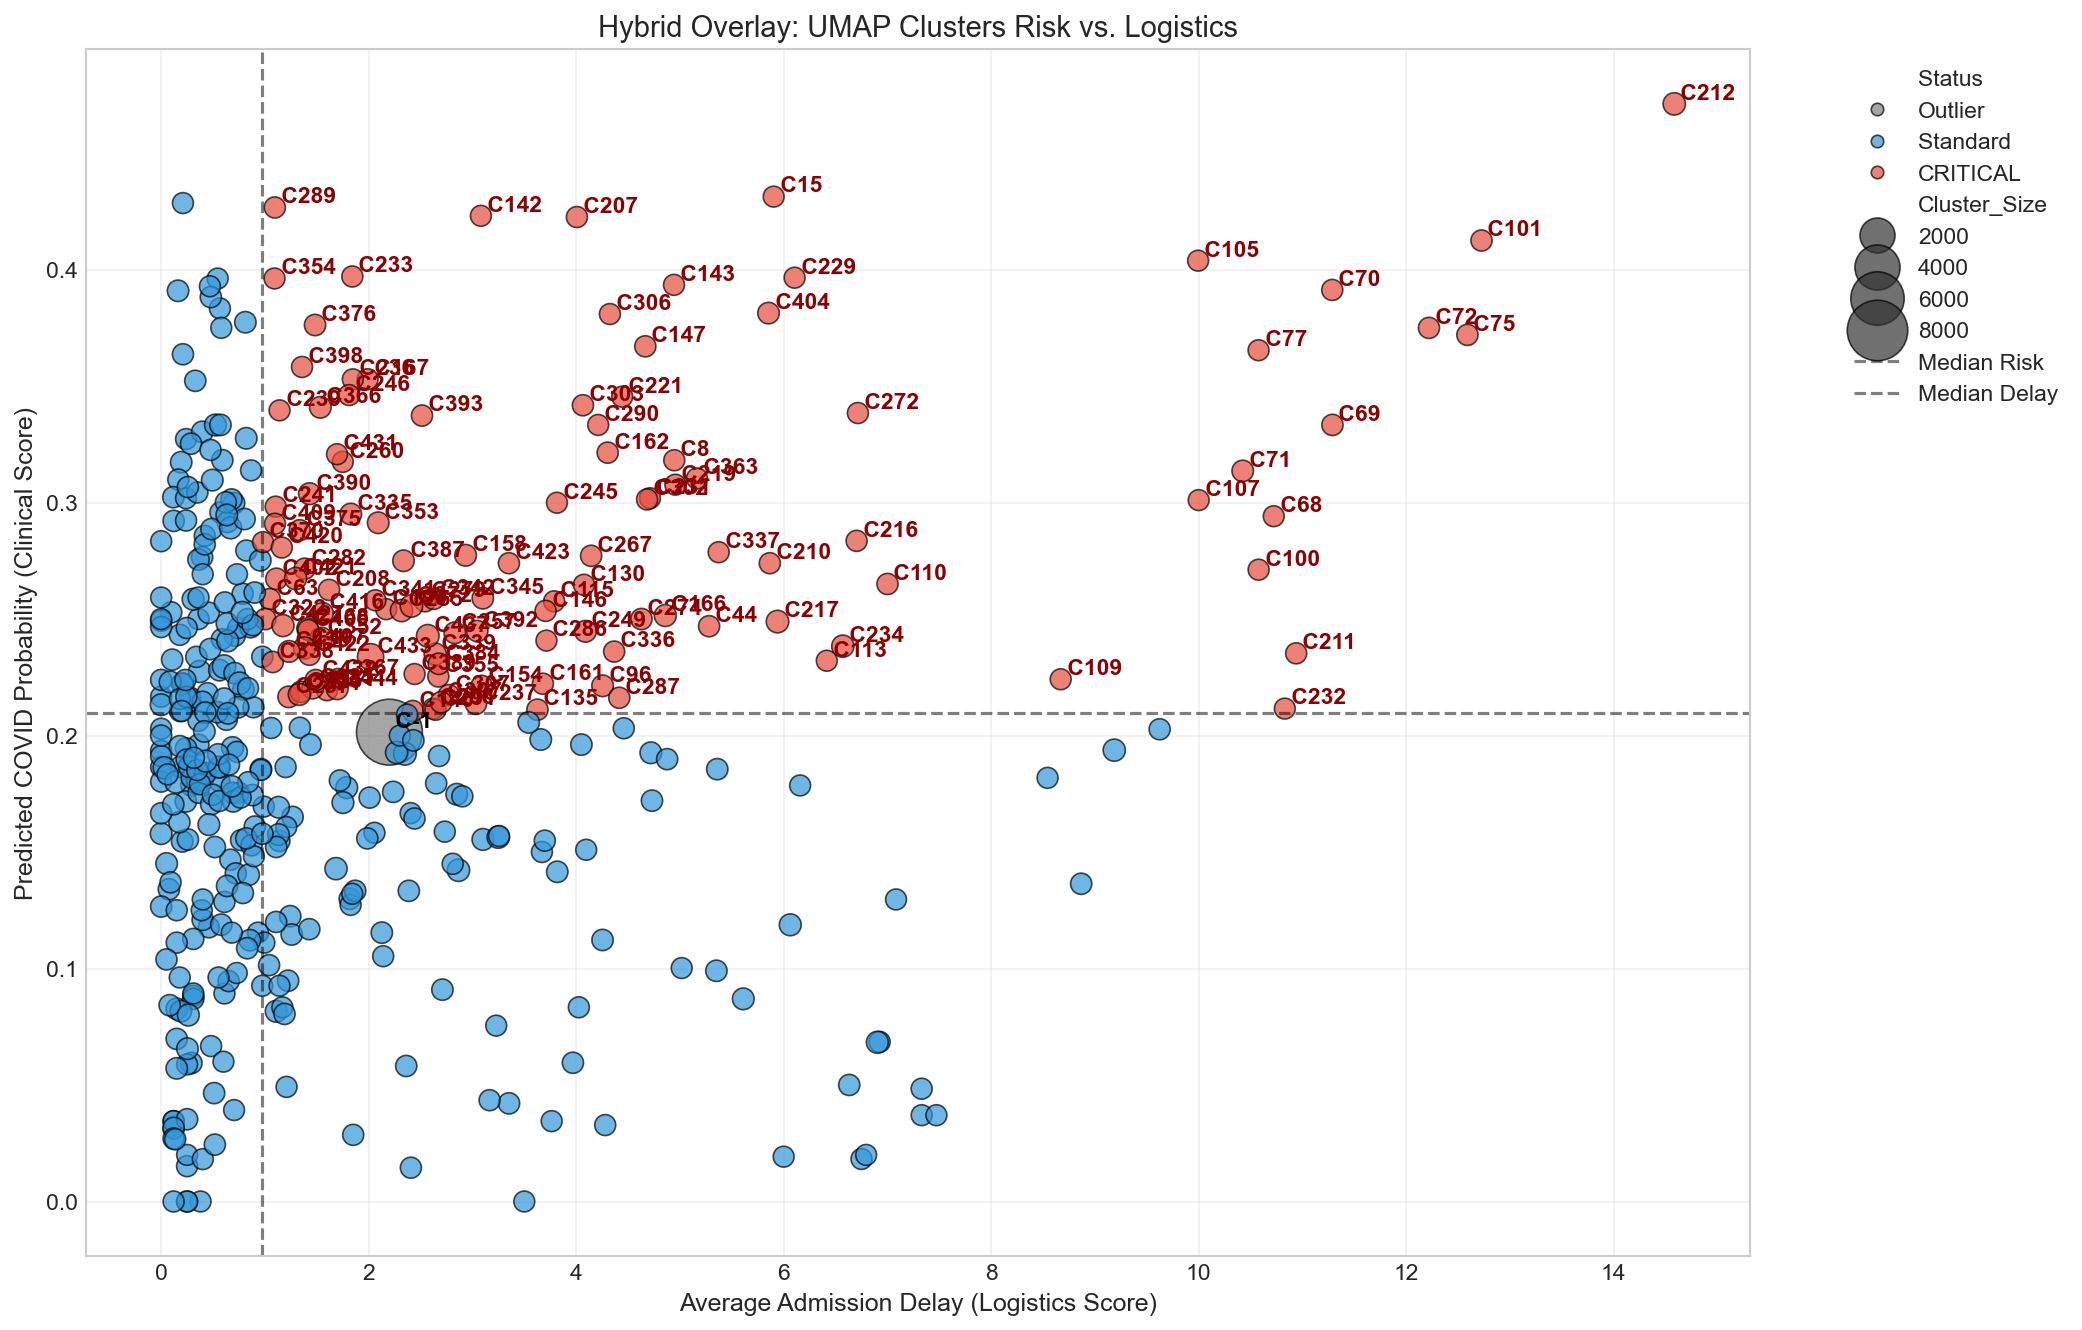

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ============================================================================
#                   Hybrid Overlay on HDBSCAN + UMAP
# ============================================================================

def run_umap_hybrid_overlay(df_clustered, classifier, label_encoder, feature_names, df_original=None):
    print("\n" + "="*60)
    print("Hybrid Overlay on HDBSCAN + UMAP")
    print("="*60)

    # 1. Prepare Data & Merge State Info
    df_pred = df_clustered.copy()
    
    # Merge State Information (Critical for demographic analysis)
    if 'state' in df_pred.columns:
        pass 
    elif df_original is not None:
        # Pull state from original dataframe using index alignment
        # This handles cases where UMAP/Clustering stripped the non-numeric columns
        common_indices = df_pred.index.intersection(df_original.index)
        df_pred.loc[common_indices, 'state'] = df_original.loc[common_indices, 'state']
    else:
        df_pred['state'] = "Unknown" 

    # Feature Engineering (Robust Checks)
    if 'comorbidity_index' not in df_pred.columns:
        risk_cols = ['risk_diabetes', 'risk_hypertension', 'risk_elderly', 'risk_lung_disease']
        available_risk = [c for c in risk_cols if c in df_pred.columns]
        df_pred['comorbidity_index'] = df_pred[available_risk].sum(axis=1) if available_risk else 0

    if 'gender_encoded' not in df_pred.columns:
        df_pred['gender_encoded'] = df_pred['gender'].apply(lambda x: 1 if str(x).lower().startswith('m') else 0) if 'gender' in df_pred.columns else 0

    # Select Features for Prediction
    X_pred = pd.DataFrame()
    for col in feature_names:
        X_pred[col] = df_pred[col] if col in df_pred.columns else 0
    X_pred = X_pred[feature_names]

    # 2. Predict Probability & Identify Labels
    classes = list(label_encoder.classes_)
    covid_idx = 0
    
    # Robustly find 'COVID' index
    if 'COVID' in classes:
        covid_idx = classes.index('COVID')
    elif any('covid' in str(c).lower() for c in classes):
        covid_idx = next(i for i, c in enumerate(classes) if 'covid' in str(c).lower())
    
    covid_label = classes[covid_idx]
    print(f"✅ Target Class for Risk: '{covid_label}' (Index {covid_idx})")

    # Predict
    probs = classifier.predict_proba(X_pred)
    df_pred['Predicted_COVID_Prob'] = probs[:, covid_idx]

    # Create Binary Column for Aggregation
    df_pred['is_covid_binary'] = (df_pred['disease'] == covid_label).astype(int)

    # 3. Aggregate Numeric Stats by Cluster
    hybrid_stats = df_pred.groupby('cluster').agg({
        'Predicted_COVID_Prob': 'mean',
        'access_admission_delay': 'mean',
        'access_distance_hospital': 'mean',
        'access_population_density': 'mean',
        'is_covid_binary': 'mean', # Rate of true covid cases
        'disease': 'count'         # Cluster size
    })
    
    # Rename columns to match standard format
    hybrid_stats.columns = [
        'Predicted_COVID_Prob', 'access_admission_delay', 
        'access_distance_hospital', 'access_population_density', 
        'True_COVID_Rate', 'Cluster_Size'
    ]
    
    # 4. Identify Critical Clusters
    valid_stats = hybrid_stats[hybrid_stats.index != -1]
    
    # Handle case where valid_stats might be empty if everything is noise
    if not valid_stats.empty:
        median_prob = valid_stats['Predicted_COVID_Prob'].median()
        median_delay = valid_stats['access_admission_delay'].median()
    else:
        median_prob = 0.5
        median_delay = 0

    def get_status(idx, row):
        if idx == -1: return 'Outlier'
        if (row['Predicted_COVID_Prob'] > median_prob) and (row['access_admission_delay'] > median_delay):
            return 'CRITICAL'
        return 'Standard'
    
    hybrid_stats['Status'] = [get_status(idx, row) for idx, row in hybrid_stats.iterrows()]

    # --- NEW: Calculate Top States per Cluster (Standardized Format) ---
    def get_top_states(group):
        if 'state' not in group.columns or group['state'].isnull().all():
            return pd.Series({'Top 1 State': '-', 'Top 2 State': '-', 'Top 3 State': '-'})
            
        counts = group['state'].value_counts(normalize=True) * 100
        top = counts.head(3)
        
        return pd.Series({
            'Top 1 State': f"{top.index[0]} ({top.iloc[0]:.1f}%)" if len(top) > 0 else "-",
            'Top 2 State': f"{top.index[1]} ({top.iloc[1]:.1f}%)" if len(top) > 1 else "-",
            'Top 3 State': f"{top.index[2]} ({top.iloc[2]:.1f}%)" if len(top) > 2 else "-"
        })

    # Apply state analysis
    print("🔄 Analyzing state demographics per UMAP cluster...")
    state_info = df_pred.groupby('cluster').apply(get_top_states)
    
    # Join State Info to Main Stats
    hybrid_stats = hybrid_stats.join(state_info)

    # 5. Output Table
    print("\n📊 Cluster Risk Profile (Sorted by Risk):")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(hybrid_stats.sort_values('Predicted_COVID_Prob', ascending=False))
    
    print(f"\n🔍 Thresholds :: Risk > {median_prob:.3f} | Delay > {median_delay:.3f}")
    
    critical_clusters = hybrid_stats[hybrid_stats['Status'] == 'CRITICAL'].index.tolist()
    if critical_clusters:
        print(f"🚨 ALERT: UMAP Clusters {critical_clusters} are CRITICAL PRIORITIES.")

    # 6. Visualization
    plt.figure(figsize=(14, 9))
    palette = {'CRITICAL': '#e74c3c', 'Standard': '#3498db', 'Outlier': 'grey'}
    
    sns.scatterplot(
        data=hybrid_stats,
        x='access_admission_delay',
        y='Predicted_COVID_Prob',
        size='Cluster_Size',
        sizes=(100, 1000), 
        hue='Status',
        palette=palette,
        alpha=0.7,
        edgecolor='black'
    )
    
    plt.axhline(y=median_prob, color='black', linestyle='--', alpha=0.5, label='Median Risk')
    plt.axvline(x=median_delay, color='black', linestyle='--', alpha=0.5, label='Median Delay')
    
    # Label Critical Clusters
    for idx, row in hybrid_stats.iterrows():
        if row['Status'] in ['CRITICAL', 'Outlier']:
            plt.text(
                row['access_admission_delay'], 
                row['Predicted_COVID_Prob'] + 0.002, 
                f" C{idx}", 
                fontsize=11, fontweight='bold', 
                color='darkred' if row['Status'] == 'CRITICAL' else 'black'
            )

    plt.title('Hybrid Overlay: UMAP Clusters Risk vs. Logistics', fontsize=14)
    plt.xlabel('Average Admission Delay (Logistics Score)', fontsize=12)
    plt.ylabel('Predicted COVID Probability (Clinical Score)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return df_pred, hybrid_stats

# ============================================================================
# EXECUTION BLOCK
# ============================================================================

# Define model variable
model_var = globals().get('xgb_model', globals().get('model_xgb', None))

# Ensure df_full exists for state lookup
df_original_ref = globals().get('df_full', None) 
if df_original_ref is None:
    print("⚠️ 'df_full' not found. Attempting to reload for state info...")
    try:
        df_original_ref = pd.read_csv("Data/rm19_dataset_full.csv")
        print("✅ Loaded df_full from disk.")
    except:
        print("❌ Could not load original data. State info may be missing.")

# Check for df_umap (Common output variable for UMAP tasks)
umap_df_var = globals().get('df_umap', globals().get('df_clustered_umap', None))

if model_var is not None and umap_df_var is not None:
    df_hybrid_umap, stats_hybrid_umap = run_umap_hybrid_overlay(
        umap_df_var, 
        model_var, 
        le_disease, 
        feature_names,
        df_original=df_original_ref
    )
else:
    print("⚠️ MISSING DEPENDENCIES. Please run UMAP Clustering and XGBoost Training first.")

## 4.3.3 Hybrid Overlay on HDBSCAN + UMAP for Acessibility + Demographics + Risks


Hybrid Overlay on Combined (Mixed) Clustering
✅ Target Class for Risk: 'COVID' (Index 0)
🔄 Analyzing state demographics per combined cluster...

📊 Cluster Risk Profile (Sorted by Risk):
         Predicted_COVID_Prob  access_admission_delay  access_distance_hospital  access_population_density  True_COVID_Rate  Cluster_Size    Status                Top 1 State             Top 2 State           Top 3 State
cluster                                                                                                                                                                                                                     
240                  0.359496                4.015098                  3.500000                   1.000000         0.359477           153  CRITICAL            Sarawak (34.0%)          Pahang (34.0%)         Sabah (32.0%)
300                  0.333339                0.536071                  1.000000                   2.964286         0.333333            84  Standard   

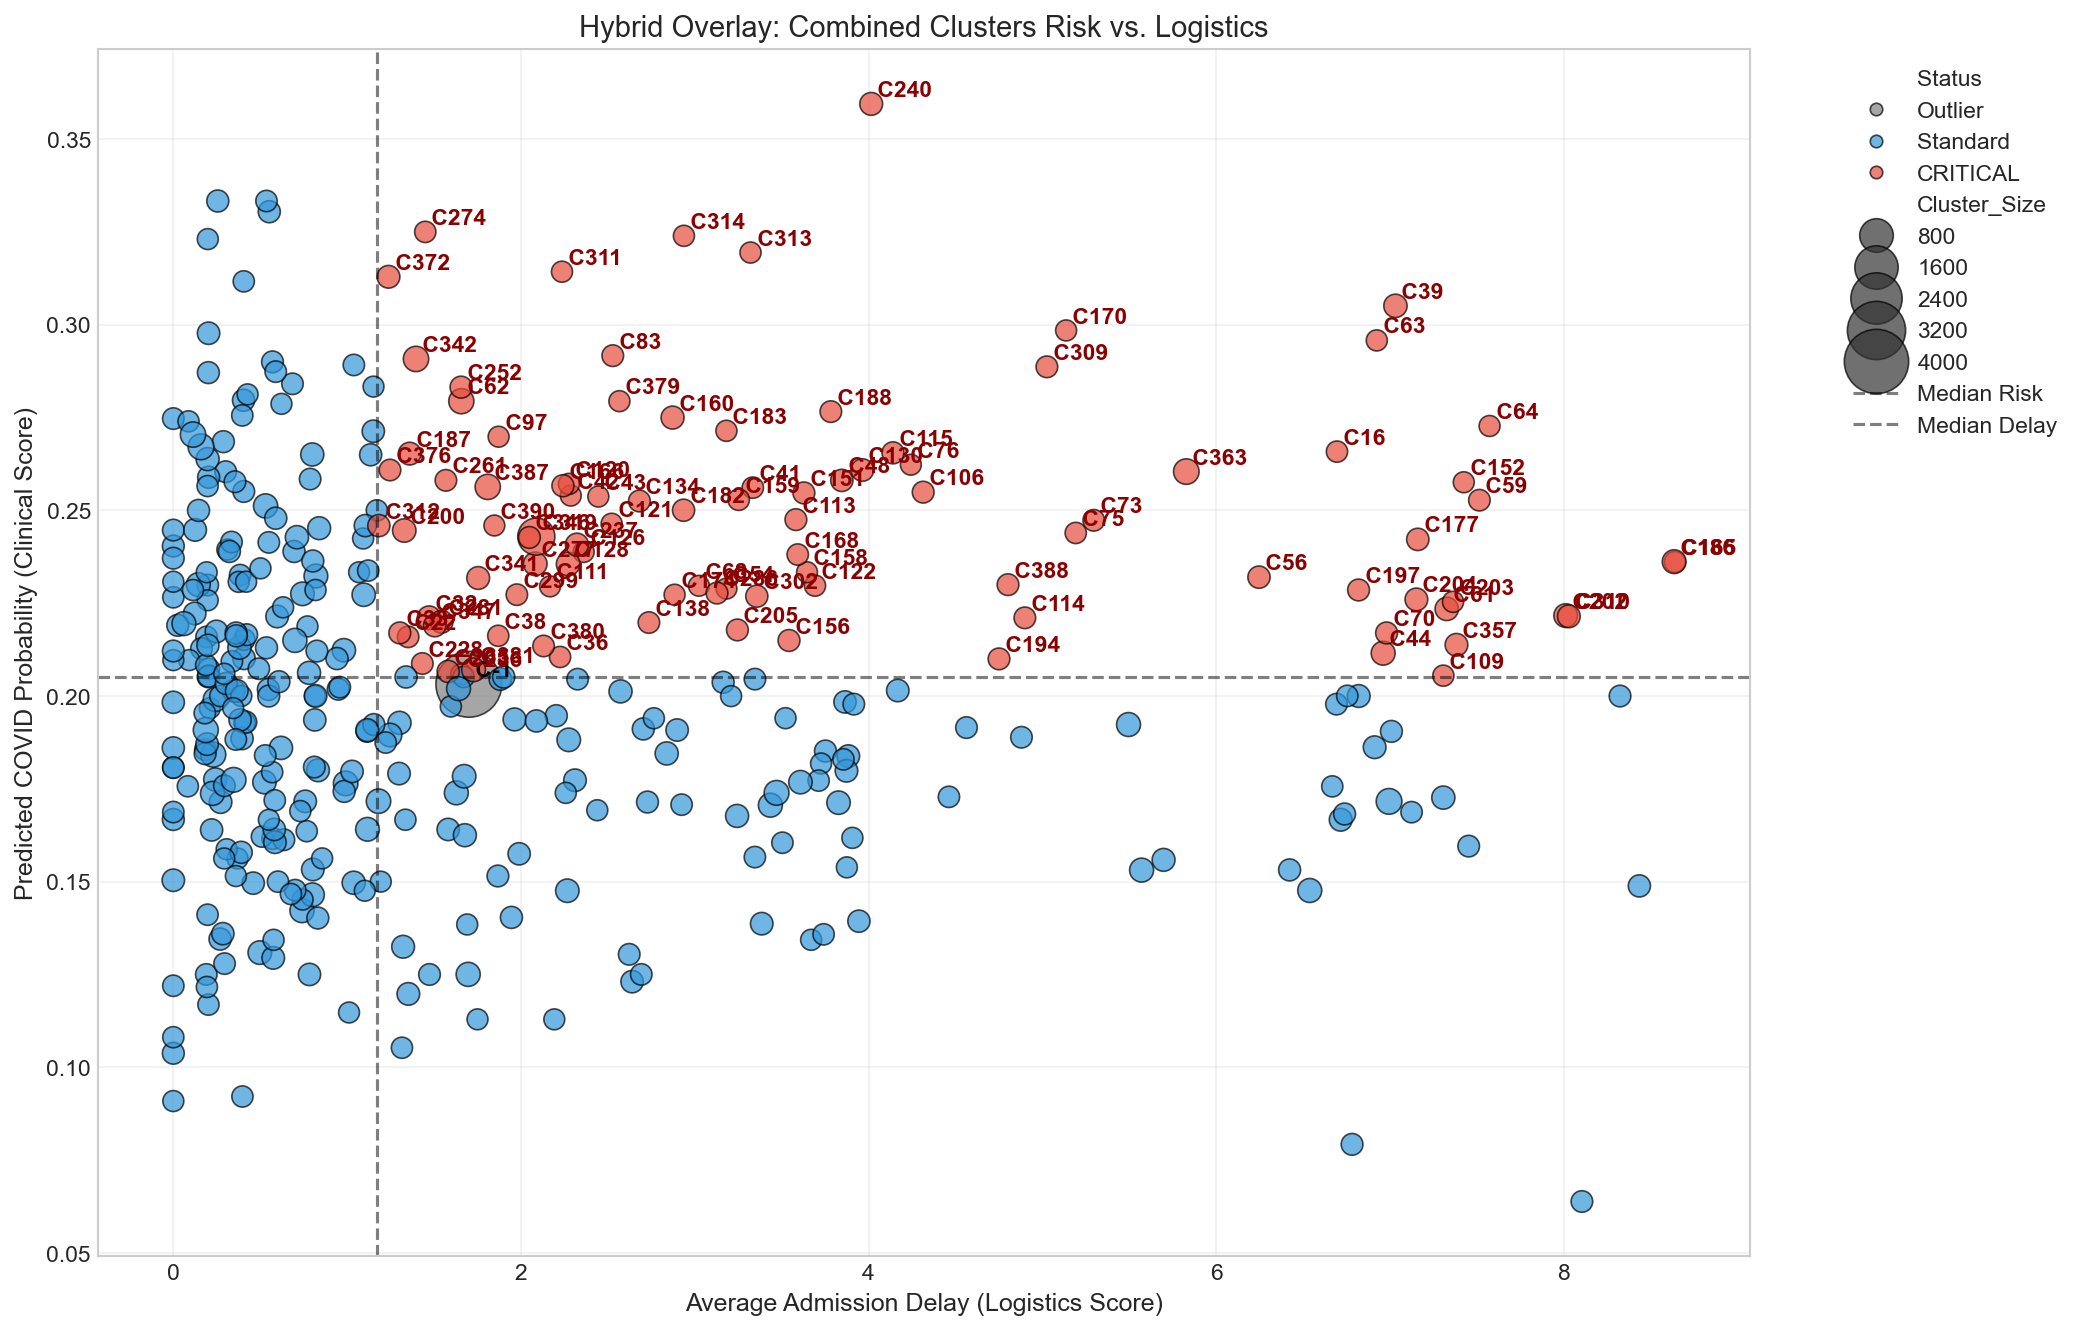

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ============================================================================
#             Hybrid Overlay on Combined (Mixed) Clustering
# ============================================================================

def run_hybrid_overlay_on_combined(df_clustered, classifier, label_encoder, feature_names, df_original=None):
    print("\n" + "="*60)
    print("Hybrid Overlay on Combined (Mixed) Clustering")
    print("="*60)

    # 1. Prepare Data & Merge State Info
    df_pred = df_clustered.copy()
    
    # Ensure we use the correct cluster column from the combined step
    if 'combined_cluster' in df_pred.columns:
        df_pred['cluster'] = df_pred['combined_cluster']
    elif 'cluster' not in df_pred.columns:
        print("❌ Error: No 'combined_cluster' or 'cluster' column found.")
        return None, None

    # Merge State Information (Critical for demographic analysis)
    if 'state' in df_pred.columns:
        pass 
    elif df_original is not None:
        # Pull state from original dataframe using index alignment
        common_indices = df_pred.index.intersection(df_original.index)
        df_pred.loc[common_indices, 'state'] = df_original.loc[common_indices, 'state']
    else:
        df_pred['state'] = "Unknown" 

    # Feature Engineering (Robust Checks)
    if 'comorbidity_index' not in df_pred.columns:
        risk_cols = ['risk_diabetes', 'risk_hypertension', 'risk_elderly', 'risk_lung_disease']
        available_risk = [c for c in risk_cols if c in df_pred.columns]
        df_pred['comorbidity_index'] = df_pred[available_risk].sum(axis=1) if available_risk else 0

    if 'gender_encoded' not in df_pred.columns:
        df_pred['gender_encoded'] = df_pred['gender'].apply(lambda x: 1 if str(x).lower().startswith('m') else 0) if 'gender' in df_pred.columns else 0

    # Select Features for Prediction
    X_pred = pd.DataFrame()
    for col in feature_names:
        X_pred[col] = df_pred[col] if col in df_pred.columns else 0
    X_pred = X_pred[feature_names]

    # 2. Predict Probability & Identify Labels
    classes = list(label_encoder.classes_)
    covid_idx = 0
    
    # Robustly find 'COVID' index
    if 'COVID' in classes:
        covid_idx = classes.index('COVID')
    elif any('covid' in str(c).lower() for c in classes):
        covid_idx = next(i for i, c in enumerate(classes) if 'covid' in str(c).lower())
    
    covid_label = classes[covid_idx]
    print(f"✅ Target Class for Risk: '{covid_label}' (Index {covid_idx})")

    # Predict
    probs = classifier.predict_proba(X_pred)
    df_pred['Predicted_COVID_Prob'] = probs[:, covid_idx]

    # Create Binary Column for Aggregation
    df_pred['is_covid_binary'] = (df_pred['disease'] == covid_label).astype(int)

    # 3. Aggregate Numeric Stats by Cluster
    hybrid_stats = df_pred.groupby('cluster').agg({
        'Predicted_COVID_Prob': 'mean',
        'access_admission_delay': 'mean',
        'access_distance_hospital': 'mean',
        'access_population_density': 'mean',
        'is_covid_binary': 'mean', # Rate of true covid cases
        'disease': 'count'         # Cluster size
    })
    
    # Rename columns to match standard format
    hybrid_stats.columns = [
        'Predicted_COVID_Prob', 'access_admission_delay', 
        'access_distance_hospital', 'access_population_density', 
        'True_COVID_Rate', 'Cluster_Size'
    ]
    
    # 4. Identify Critical Clusters
    valid_stats = hybrid_stats[hybrid_stats.index != -1]
    
    # Handle empty valid_stats
    if not valid_stats.empty:
        median_prob = valid_stats['Predicted_COVID_Prob'].median()
        median_delay = valid_stats['access_admission_delay'].median()
    else:
        median_prob = 0.5
        median_delay = 0

    def get_status(idx, row):
        if idx == -1: return 'Outlier'
        if (row['Predicted_COVID_Prob'] > median_prob) and (row['access_admission_delay'] > median_delay):
            return 'CRITICAL'
        return 'Standard'
    
    hybrid_stats['Status'] = [get_status(idx, row) for idx, row in hybrid_stats.iterrows()]

    # --- NEW: Calculate Top States per Cluster (Standardized Format) ---
    def get_top_states(group):
        if 'state' not in group.columns or group['state'].isnull().all():
            return pd.Series({'Top 1 State': '-', 'Top 2 State': '-', 'Top 3 State': '-'})
            
        counts = group['state'].value_counts(normalize=True) * 100
        top = counts.head(3)
        
        return pd.Series({
            'Top 1 State': f"{top.index[0]} ({top.iloc[0]:.1f}%)" if len(top) > 0 else "-",
            'Top 2 State': f"{top.index[1]} ({top.iloc[1]:.1f}%)" if len(top) > 1 else "-",
            'Top 3 State': f"{top.index[2]} ({top.iloc[2]:.1f}%)" if len(top) > 2 else "-"
        })

    # Apply state analysis
    print("🔄 Analyzing state demographics per combined cluster...")
    state_info = df_pred.groupby('cluster').apply(get_top_states)
    
    # Join State Info to Main Stats
    hybrid_stats = hybrid_stats.join(state_info)

    # 5. Output Table
    print("\n📊 Cluster Risk Profile (Sorted by Risk):")
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(hybrid_stats.sort_values('Predicted_COVID_Prob', ascending=False))
    
    print(f"\n🔍 Thresholds :: Risk > {median_prob:.3f} | Delay > {median_delay:.3f}")
    
    critical_clusters = hybrid_stats[hybrid_stats['Status'] == 'CRITICAL'].index.tolist()
    if critical_clusters:
        print(f"🚨 ALERT: Combined Clusters {critical_clusters} are CRITICAL PRIORITIES.")

    # 6. Visualization
    plt.figure(figsize=(14, 9))
    palette = {'CRITICAL': '#e74c3c', 'Standard': '#3498db', 'Outlier': 'grey'}
    
    sns.scatterplot(
        data=hybrid_stats,
        x='access_admission_delay',
        y='Predicted_COVID_Prob',
        size='Cluster_Size',
        sizes=(100, 1000), 
        hue='Status',
        palette=palette,
        alpha=0.7,
        edgecolor='black'
    )
    
    plt.axhline(y=median_prob, color='black', linestyle='--', alpha=0.5, label='Median Risk')
    plt.axvline(x=median_delay, color='black', linestyle='--', alpha=0.5, label='Median Delay')
    
    # Label Critical Clusters
    for idx, row in hybrid_stats.iterrows():
        if row['Status'] in ['CRITICAL', 'Outlier']:
            plt.text(
                row['access_admission_delay'], 
                row['Predicted_COVID_Prob'] + 0.002, 
                f" C{idx}", 
                fontsize=11, fontweight='bold', 
                color='darkred' if row['Status'] == 'CRITICAL' else 'black'
            )

    plt.title('Hybrid Overlay: Combined Clusters Risk vs. Logistics', fontsize=14)
    plt.xlabel('Average Admission Delay (Logistics Score)', fontsize=12)
    plt.ylabel('Predicted COVID Probability (Clinical Score)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return df_pred, hybrid_stats

# ============================================================================
# EXECUTION BLOCK
# ============================================================================

# Define model variable
model_var = globals().get('xgb_model', globals().get('model_xgb', None))

# Ensure df_full exists for state lookup
df_original_ref = globals().get('df_full', None) 
if df_original_ref is None:
    print("⚠️ 'df_full' not found. Attempting to reload for state info...")
    try:
        df_original_ref = pd.read_csv("Data/rm19_dataset_full.csv")
        print("✅ Loaded df_full from disk.")
    except:
        print("❌ Could not load original data. State info may be missing.")

# Identify the input dataframe from previous step (Mixed Clustering)
# Note: In the mixed clustering step, the output was likely just 'df_complete'
df_combined_var = globals().get('df_complete', None)

if model_var is not None and df_combined_var is not None:
    df_hybrid_combined, stats_hybrid_combined = run_hybrid_overlay_on_combined(
        df_combined_var, 
        model_var, 
        le_disease, 
        feature_names,
        df_original=df_original_ref
    )
else:
    print("⚠️ MISSING DEPENDENCIES. Please run Combined Clustering and XGBoost Training first.")

# 5.0 Discussion
## 5.1 Setup and Imports

In [ ]:
# Install additional libraries if missing
!pip install folium plotly hdbscan umap-learn shap

import folium
from folium.plugins import MarkerCluster
import plotly.express as px
import json
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print("✅ Enhanced Visualization libraries loaded.")


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Enhanced Visualization libraries loaded.


## 5.2 Cluster Validation (Silhouette & Stability)

In [ ]:
# ==========================================
# 6. TIDY CLUSTER VALIDATION REPORT
# ==========================================
from sklearn.metrics import silhouette_score
import numpy as np

def print_tidy_metrics(case_name, X, labels, clusterer, score_label="Silhouette Score (Noise-filtered)"):
    """Prints a clean, formatted report for cluster validation."""
    print(f"\n{case_name}")
    
    # 1. Silhouette Score
    # Filter out noise (-1) for a fair score
    mask = labels != -1
    if sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(X[mask], labels[mask])
        print(f"{score_label}: {score:.4f}")
    else:
        print(f"{score_label}: N/A (Not enough valid clusters)")
        
    # 2. Stability Score
    if clusterer is not None and hasattr(clusterer, 'probabilities_'):
        avg_prob = np.mean(clusterer.probabilities_)
        print(f"Average Cluster Stability (Probability): {avg_prob:.4f}")
    else:
        print("Average Cluster Stability (Probability): N/A")

# ---------------------------------------------------------
# EXECUTION BLOCKS
# ---------------------------------------------------------

# 1. Case HDBSCAN (Accessibility Only)
if 'X_scaled' in globals() and 'df_clustered' in globals():
    # Attempt to grab the clusterer if it exists from previous steps
    clus_obj = globals().get('clusterer_clustered') 
    print_tidy_metrics("Case HDBSCAN", 
                       X_scaled, 
                       df_clustered['cluster'].values, 
                       clus_obj)

# 2. Case HDBSCAN + UMAP
if 'df_umap' in globals() and 'clusterer_umap' in globals():
    # Use UMAP coordinates for correct 2D shape validation
    X_umap_2d = df_umap[['umap_x', 'umap_y']].values
    print_tidy_metrics("Case HDBSCAN + UMAP", 
                       X_umap_2d, 
                       df_umap['cluster'].values, 
                       clusterer_umap,
                       score_label="Silhouette Score (on UMAP projection)")

# 3. Case HDBSCAN + UMAP (Complete Dataset)
if 'df_complete' in globals() and 'clusterer_complete' in globals():
    # Use UMAP coordinates for correct 2D shape validation
    X_complete_2d = df_complete[['umap_x', 'umap_y']].values
    print_tidy_metrics("Case HDBSCAN + UMAP for complete dataset", 
                       X_complete_2d, 
                       df_complete['combined_cluster'].values, 
                       clusterer_complete)


Case HDBSCAN
Silhouette Score (Noise-filtered): 0.0765
Average Cluster Stability (Probability): 0.9924

Case HDBSCAN + UMAP
Silhouette Score (on UMAP projection): 0.4989
Average Cluster Stability (Probability): 0.7344

Case HDBSCAN + UMAP for complete dataset
Silhouette Score (Noise-filtered): 0.6775
Average Cluster Stability (Probability): 0.7702


In [ ]:
# ==========================================
# 6. TIDY CLUSTER VALIDATION REPORT (WITH DBI)
# ==========================================
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

def print_tidy_metrics(case_name, X, labels, clusterer, score_label="Silhouette Score (Noise-filtered)"):
    """
    Prints a clean, formatted report for cluster validation.
    Includes Silhouette Score, Davies-Bouldin Index, and Stability.
    """
    print(f"\n{'='*60}")
    print(f"{case_name}")
    print(f"{'='*60}")
    
    # Filter out noise (-1) for fair scoring
    mask = labels != -1
    valid_labels = labels[mask]
    X_valid = X[mask]
    
    # Check if we have enough valid clusters
    n_valid_samples = sum(mask)
    n_clusters = len(set(valid_labels))
    
    if n_valid_samples > 1 and n_clusters > 1:
        # 1. Silhouette Score (Higher is better: -1 to +1)
        sil_score = silhouette_score(X_valid, valid_labels)
        print(f"📊 {score_label}: {sil_score:.4f}")
        print(f"   → Range: [-1, +1] | Higher is better")
        print(f"   → Interpretation: ", end="")
        if sil_score > 0.5:
            print("Excellent separation ✅")
        elif sil_score > 0.25:
            print("Moderate separation ⚠️")
        else:
            print("Weak separation ❌")
        
        # 2. Davies-Bouldin Index (Lower is better: 0 to ∞)
        dbi_score = davies_bouldin_score(X_valid, valid_labels)
        print(f"\n📊 Davies-Bouldin Index (DBI): {dbi_score:.4f}")
        print(f"   → Range: [0, ∞) | Lower is better")
        print(f"   → Interpretation: ", end="")
        if dbi_score < 1.0:
            print("Excellent clustering ✅")
        elif dbi_score < 1.5:
            print("Good clustering ⚠️")
        else:
            print("Poor clustering ❌")
            
    else:
        print(f"📊 {score_label}: N/A (Not enough valid clusters)")
        print(f"📊 Davies-Bouldin Index (DBI): N/A (Not enough valid clusters)")
    
    # 3. Stability Score (HDBSCAN-specific)
    if clusterer is not None and hasattr(clusterer, 'probabilities_'):
        avg_prob = np.mean(clusterer.probabilities_)
        print(f"\n📊 Average Cluster Stability (HDBSCAN Probability): {avg_prob:.4f}")
        print(f"   → Range: [0, 1] | Higher is better")
        print(f"   → Interpretation: ", end="")
        if avg_prob > 0.7:
            print("High confidence assignments ✅")
        elif avg_prob > 0.5:
            print("Moderate confidence ⚠️")
        else:
            print("Low confidence ❌")
    else:
        print(f"\n📊 Average Cluster Stability: N/A (Not an HDBSCAN clusterer)")
    
    # 4. Cluster Distribution
    unique, counts = np.unique(valid_labels, return_counts=True)
    print(f"\n📊 Cluster Distribution:")
    print(f"   → Valid Clusters: {n_clusters}")
    print(f"   → Noise Points: {len(labels) - n_valid_samples} ({(len(labels) - n_valid_samples)/len(labels)*100:.1f}%)")
    print(f"   → Largest Cluster: {max(counts)} samples")
    print(f"   → Smallest Cluster: {min(counts)} samples")
    print(f"   → Avg Cluster Size: {np.mean(counts):.1f} samples")

# ---------------------------------------------------------
# EXECUTION BLOCKS
# ---------------------------------------------------------

print("\n" + "="*60)
print("CLUSTER VALIDATION METRICS REPORT")
print("="*60)

# 1. Case: HDBSCAN (Accessibility Only)
if 'X_scaled' in globals() and 'df_clustered' in globals():
    clus_obj = globals().get('clusterer_clustered') 
    print_tidy_metrics(
        "Case 1: HDBSCAN (Accessibility Features Only)", 
        X_scaled, 
        df_clustered['cluster'].values, 
        clus_obj
    )

# 2. Case: HDBSCAN + UMAP
if 'df_umap' in globals() and 'clusterer_umap' in globals():
    X_umap_2d = df_umap[['umap_x', 'umap_y']].values
    print_tidy_metrics(
        "Case 2: HDBSCAN + UMAP (Accessibility Features)", 
        X_umap_2d, 
        df_umap['cluster'].values, 
        clusterer_umap,
        score_label="Silhouette Score (on UMAP projection)"
    )

# 3. Case: HDBSCAN + UMAP (Complete Dataset with Comorbidity)
if 'df_complete' in globals() and 'clusterer_complete' in globals():
    X_complete_2d = df_complete[['umap_x', 'umap_y']].values
    print_tidy_metrics(
        "Case 3: HDBSCAN + UMAP (Accessibility + Comorbidity + Demographics)", 
        X_complete_2d, 
        df_complete['combined_cluster'].values, 
        clusterer_complete
    )

print("\n" + "="*60)
print("VALIDATION COMPLETE")
print("="*60)
print("\n💡 Tips for Interpretation:")
print("   • Silhouette: Measures how similar points are to their own cluster vs. others")
print("   • DBI: Ratio of within-cluster scatter to between-cluster separation")
print("   • Lower DBI + Higher Silhouette = Better clustering quality")
print("   • HDBSCAN Stability: Confidence of cluster assignments")


CLUSTER VALIDATION METRICS REPORT

Case 1: HDBSCAN (Accessibility Features Only)
📊 Silhouette Score (Noise-filtered): 0.0765
   → Range: [-1, +1] | Higher is better
   → Interpretation: Weak separation ❌

📊 Davies-Bouldin Index (DBI): 2.2960
   → Range: [0, ∞) | Lower is better
   → Interpretation: Poor clustering ❌

📊 Average Cluster Stability (HDBSCAN Probability): 0.9924
   → Range: [0, 1] | Higher is better
   → Interpretation: High confidence assignments ✅

📊 Cluster Distribution:
   → Valid Clusters: 23
   → Noise Points: 259 (0.5%)
   → Largest Cluster: 9018 samples
   → Smallest Cluster: 102 samples
   → Avg Cluster Size: 2162.7 samples

Case 2: HDBSCAN + UMAP (Accessibility Features)
📊 Silhouette Score (on UMAP projection): 0.4989
   → Range: [-1, +1] | Higher is better
   → Interpretation: Moderate separation ⚠️

📊 Davies-Bouldin Index (DBI): 0.7004
   → Range: [0, ∞) | Lower is better
   → Interpretation: Excellent clustering ✅

📊 Average Cluster Stability (HDBSCAN Probabil

## 5.3 State-Level Analysis & Map Data Preparation
Merging cluster results with State information.

In [ ]:
# ==========================================
# 6. STATE-LEVEL ANALYSIS
# ==========================================

def merge_state_data(df_clustered, df_full_original):
    """Merge state info and analyze dominant clusters per state."""
    print("\n" + "="*60)
    print("6. STATE-LEVEL ACCESSIBILITY ANALYSIS")
    print("="*60)
    
    # 1. Merge State Info
    # If df_clustered already has state, copy it; otherwise pull from original using index
    if 'state' in df_clustered.columns:
        df_merged = df_clustered.copy()
    else:
        df_merged = df_clustered.copy()
        df_merged['state'] = df_full_original.loc[df_merged.index, 'state']
        
    # 2. Aggregation
    # Check if we have the predicted probability, otherwise fallback to delay
    risk_col = 'Predicted_COVID_Prob' if 'Predicted_COVID_Prob' in df_merged.columns else 'access_admission_delay'
    
    state_stats = df_merged.groupby('state').agg(
        Count=('cluster', 'count'),
        Dominant_Cluster=('cluster', lambda x: x.mode()[0] if not x.mode().empty else -1),
        Avg_Admission_Delay=('access_admission_delay', 'mean'),
        Avg_Dist_Hospital=('access_distance_hospital', 'mean'),
        Avg_Risk_Level=(risk_col, 'mean')
    ).reset_index()
    
    # 3. Configure Display Options for Clean Output
    pd.set_option('display.max_columns', None)       # Show all columns
    pd.set_option('display.expand_frame_repr', False) # Don't wrap to next line
    pd.set_option('display.width', 1000)             # extend console width
    pd.set_option('display.float_format', '{:.5f}'.format) # Clean 2 decimal points

    print("\n📊 State Analysis (Sorted by Admission Delay):")
    print(state_stats.sort_values('Avg_Admission_Delay', ascending=False).head(10).to_string(index=False))
    
    # Reset options (optional, good practice)
    pd.reset_option('display.max_columns')
    pd.reset_option('display.expand_frame_repr')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')

    return df_merged, state_stats

# Execute
if 'df_clustered' in globals() and 'df_full' in globals():
    df_final, state_summary = merge_state_data(df_clustered, df_full)
else:
    print("⚠️ Dataframes not found. Ensure execution of previous blocks.")


6. STATE-LEVEL ACCESSIBILITY ANALYSIS

📊 State Analysis (Sorted by Admission Delay):
          state  Count  Dominant_Cluster  Avg_Admission_Delay  Avg_Dist_Hospital  Avg_Risk_Level
        Sarawak   3476                 5              5.24607            3.62270         5.24607
         Pahang   3477                18              4.97222            3.47412         4.97222
          Sabah   3451                18              4.60432            3.32512         4.60432
     Terengganu   3531                22              4.17275            3.07746         4.17275
       Kelantan   3556                22              3.69677            2.85996         3.69677
          Kedah   2130                11              1.46451            2.66761         1.46451
          Perak   2150                11              1.40480            2.51953         1.40480
         Perlis   2022                11              1.35957            2.48145         1.35957
Negeri Sembilan   2030                11 